In [1]:
import tensorflow as tf
print(tf.__version__)

import tensorflow_addons as tfa
print(tfa.__version__)
import tensorflow_probability as tfp
print(tfp.__version__)



from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.python.keras.layers import Input
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.python.keras.layers.merge import concatenate
from tensorflow.keras import Model
from tensorflow.keras import layers

from tensorflow.python.eager import context
from tensorflow.python.framework import ops

from tslearn.datasets import UCR_UEA_datasets



print("GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")

2.2.0
0.11.2
0.7.0
GPU is available


85

In [2]:
import os
import random
import numpy as np
import math
import scipy.stats
import pandas as pd
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import seaborn as sns
import antropy as ant
from datetime import datetime

from scipy.interpolate import interp1d

from os import walk

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from functools import reduce

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.utils import shuffle

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics

from scipy.stats import norm
from scipy.interpolate import interp1d
from scipy.io import arff

from pyts.approximation import SymbolicAggregateApproximation

from modules import helper
from modules import transformer
from modules import GCRPlus
from modules import GCR
from modules import dataset_selecter
from modules import mainHelper
from modules import modelCreator
from modules import dataset_selecter as ds

from collections import defaultdict

from sktime.transformations.panel.shapelets import ContractedShapeletTransform

Set random variables so that one run on the same computer always results in the same models

In [3]:
seed_value = 96
os.environ['PYTHONHASHSEED']=str(seed_value)# 2. Set `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)# 3. Set `numpy` pseudo-random generator at a fixed value
tf.random.set_seed(seed_value)
np.random.RandomState(seed_value)

np.random.seed(seed_value)

context.set_global_seed(seed_value)
ops.get_default_graph().seed = seed_value

#pip install tensorflow-determinism needed
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
np.random.seed(seed_value)
#tf.experimental.numpy.random.seed(seed_value)

Loading and preprocessing the test and train data

Change parameters for different settings

In [4]:


#Use saved model weights in the save folder
useSaves = False 
useEmbed = False

#number of symbolics for SAX
n_bins = 5
symbolCount = n_bins
#valuesA = [-1, 0, 1]
#valuesA = [-1, -0.3333333333333333, 0.3333333333333333, 1]
#valuesA = [-1, -0.5, 0, 0.5, 1]
valuesA = helper.getMapValues(n_bins)
print(valuesA)

#number of folds
nrFolds = 5

#1 out of them
doNormal = True
doGearBox = False
doCWRU = False
doFrequency = False
doANDOR = False
doUTC = False
dataNumber = 0#'ItalyPowerDemand'#0
takeName = False#True

multiVariant = False
calcComplexity = False
doSymbolify = True

# Initialize k-folds
kf = StratifiedKFold(nrFolds, shuffle=True, random_state=seed_value) # Use for StratifiedKFold classification
fold = 0

# Earlystopping callback
earlystop = EarlyStopping(monitor= 'val_loss', min_delta=0 , patience=70, verbose=0, mode='auto')

[-1.0, -0.5, 0.0, 0.5, 1.0]


In [5]:
if doNormal:
    

    weird = False
    #source: http://www.timeseriesclassification.com/description.php?Dataset=SyntheticControl
    data_path_train = './Datasets/SyntheticControl/SyntheticControl_TRAIN.arff'
    data_path_test = './Datasets/SyntheticControl/SyntheticControl_TEST.arff'
    num_of_classes = 6
    seqSize = 60
    dataName="SyntheticControl"
    #source: http://www.timeseriesclassification.com/description.php?Dataset=ECG5000
    #data_path_train = './Datasets/ecg5000/ECG5000_TRAIN.arff'
    #data_path_test = './Datasets/ecg5000/ECG5000_TEST.arff'
    #num_of_classes = 5
    #seqSize = 140
    #dataName = "ECG5000"
    #source: http://www.timeseriesclassification.com/description.php?Dataset=Plane
    #data_path_train = './Datasets/Plane/Plane_TRAIN.arff'
    #data_path_test = './Datasets/Plane/Plane_TEST.arff'
    #num_of_classes = 7
    #seqSize = 144
    #dataName = "Plane"
    ##source: http://www.timeseriesclassification.com/description.php?Dataset=PowerCons
    #data_path_train = './Datasets/PowerCons/PowerCons_TRAIN.arff'
    #data_path_test = './Datasets/PowerCons/PowerCons_TEST.arff'
    #num_of_classes = 2
    #seqSize = 144
    #dataName = "PowerCons"
    
    #info: 5 symbols sind zu wenig!!! Dafür hatte meine technik trotzdem gute ergebnisse!!!
    ##source: 
    #data_path_train = './Datasets/Car/Car_TRAIN.arff'
    #data_path_test = './Datasets/Car/Car_TEST.arff'
    #num_of_classes = 4
    #seqSize = 577

    #info: 5 symbols sind zu wenig!!!
    ##source: 
    #data_path_train = './Datasets/Lightning7/Lightning7_TRAIN.arff'
    #data_path_test = './Datasets/Lightning7/Lightning7_TEST.arff'
    #num_of_classes = 7
    #seqSize = 319
    #weird = True

    #info:
    ##source: 
    #data_path_train = './Datasets/Earthquakes/Earthquakes_TRAIN.arff'
    #data_path_test = './Datasets/Earthquakes/Earthquakes_TEST.arff'
    #num_of_classes = 2
    #seqSize = 512
    #weird = True





    #Load and formate data
    data_train, meta_train = arff.loadarff(data_path_train)
    data_test, meta_test = arff.loadarff(data_path_test)

    data_train = np.array(data_train.tolist())
    data_test = np.array(data_test.tolist())

    y_trainy = data_train[:,-1].astype(int)
    y_train = []
    X_train = data_train[:,:-1]
    y_testy_full = data_test[:,-1].astype(int)
    y_testy = y_testy_full
    y_test = []
    X_test = data_test[:,:-1]

    X_train, y_trainy = shuffle(X_train, y_trainy, random_state = seed_value)

    for y in y_trainy:
        y_train_puffer = np.zeros(num_of_classes)
        y_train_puffer[y-1] = 1
        y_train.append(y_train_puffer)

    for y in y_testy:
        y_puffer = np.zeros(num_of_classes)
        y_puffer[y-1] = 1
        y_test.append(y_puffer)

    y_train = np.array(y_train)
    y_train = y_train.astype(float)
    y_test_full = np.array(y_test)
    y_test_full = y_test_full.astype(float)
    y_test = y_test_full  
    y_test = y_test.astype(float)

    print(X_test.shape)
    print(X_train.shape)
    print(y_test.shape)
    print(y_train.shape)

    X_test = X_test.astype(float)
    X_train = X_train.astype(float)

    print('done')
    
if doUTC:
    X_train, X_test, y_train, y_test, y_trainy, y_testy, seqSize, dataName, num_of_classes = ds.datasetSelector('utc', 96, dataNumber, takeName=takeName, use_cache=True)
    #dName = "SyntheticControl"
    #X_train, X_test, y_train, y_test, y_trainy, y_testy, seqSize, dataName, num_of_classes = dataset_selecter.doUTC(42, dName)
    data_path_train = './Datasets/Lightning7/' +dataName
    #y_train = np.array(y_train)
    #y_train = y_train.astype(float)
    #y_test_full = np.array(y_test)
    #y_test_full = y_test_full.astype(float)
    #y_test = y_test_full  
    #y_test = y_test.astype(float)
    #y_trainy = np.array(y_trainy)

(300, 60)
(300, 60)
(300, 6)
(300, 6)
done


In [6]:
len(y_testy)

300

In [7]:
def split_dataframe(df, chunk_size = 10000): 
    chunks = list()
    num_chunks = len(df) // chunk_size + 1
    for i in range(num_chunks):
        chunks.append(df[i*chunk_size:(i+1)*chunk_size])
    return chunks

if(doGearBox):
    

    data_path1 = './Datasets/GearBox/BrokenTooth Data/'
    data_path2 = './Datasets/GearBox/Healthy Data/'
    data_path_train = './Datasets/GearBox/GearBox'
    chunk_size = 128
    seqSize = chunk_size
    features = []
    labels = []
    for (dirpath, dirnames, filenames) in walk(data_path1):
        print(filenames)
        for file in filenames:
            data = pd.read_csv(data_path1+file, sep="	", header=None)
            feature = data.copy()
            feature.pop(4)
            for chunk in split_dataframe(feature, chunk_size = chunk_size)[:-1]:
                features.append(chunk.to_numpy())
                labels.append(1)
            #print(abalone_features)
        break

    for (dirpath, dirnames, filenames) in walk(data_path2):
        print(filenames)
        for file in filenames:
            data = pd.read_csv(data_path2+file, sep="	", header=None)
            feature = data.copy()
            feature.pop(4)
            for chunk in split_dataframe(feature, chunk_size = chunk_size)[:-1]:
                features.append(chunk.to_numpy())
                labels.append(0)
            #print(abalone_features)
        break
    features = np.array(features)
    labels = np.array(labels)
    features.shape

    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.20, shuffle=True, random_state=seed_value)

    y_trainy = y_train +1
    y_train = []
    X_train = X_train
    #y_testy_full = data_test[:,-1].astype(int) 
    y_testy = y_test +1
    y_test = []
    X_test = X_test
    num_of_classes = len(set(y_trainy))

    for y in y_trainy:
        y_train_puffer = np.zeros(num_of_classes)
        y_train_puffer[y-1] = 1
        y_train.append(y_train_puffer)

    for y in y_testy:
        y_puffer = np.zeros(num_of_classes)
        y_puffer[y-1] = 1
        y_test.append(y_puffer)

    y_train = np.array(y_train)
    y_train = y_train.astype(float)
    y_test_full = np.array(y_test)
    y_test_full = y_test_full.astype(float)
    y_test = y_test_full  
    y_test = y_test.astype(float)

    print(X_test.shape)
    print(X_train.shape)
    print(y_test.shape)
    print(y_train.shape)

    X_test = X_test.astype(float)
    X_train = X_train.astype(float)



In [8]:
import cwru2

if doCWRU:
    #dataSize = 148
    dataSize = 296
    seqSize = dataSize
    data = cwru2.CWRU("12FanEndFault", dataSize, 0.8, 1, '1797','1750')
    data_path_train = './Datasets/GearBox/cwru'

    # Create dummies for the labels
    print(data.y_train)
    data.y_train = pd.DataFrame(data.y_train, columns=['label'])
    dummies = pd.get_dummies(data.y_train['label']) # Classification
    products = dummies.columns
    y_train = dummies.values

    data.y_test = pd.DataFrame(data.y_test, columns=['label'])
    dummies = pd.get_dummies(data.y_test['label']) # Classification
    products = dummies.columns
    y_test = dummies.values

    X_train = data.X_train
    X_test = data.X_test
    print(y_train)

    y_trainy = np.argmax(y_train,axis=1) +1  
    y_train = []
    X_train = X_train
    #y_testy_full = data_test[:,-1].astype(int) 
    y_testy = np.argmax(y_test,axis=1) +1
    y_test = []
    X_test = X_test

    num_of_classes = len(set(y_trainy.tolist()))

    for y in y_trainy:
        y_train_puffer = np.zeros(num_of_classes)
        y_train_puffer[y-1] = 1
        y_train.append(y_train_puffer)

    for y in y_testy:
        y_puffer = np.zeros(num_of_classes)
        y_puffer[y-1] = 1
        y_test.append(y_puffer)

    y_train = np.array(y_train)
    y_train = y_train.astype(float)
    y_test_full = np.array(y_test)
    y_test_full = y_test_full.astype(float)
    y_test = y_test_full  
    y_test = y_test.astype(float)

    print(X_test.shape)
    print(X_train.shape)
    print(y_test.shape)
    print(y_train.shape)

    X_test = X_test.astype(float)
    X_train = X_train.astype(float)

In [9]:
if(doFrequency):
    doSymbolify = False
    n_bins = 2
    symbols = 2
    dataLen = 10
    valuesA = [-1,1]
    seqSize = dataLen
    data_path_train = './Datasets/counter/counter'
    size = pow(symbols, dataLen)
    #dataSet = np.zeros((size,dataLen))
    dataSet = []
    labelSet = []

    n = -1
    for i in range(size):
        binary = format(i, '0'+str(dataLen)+'b')
        #if int(binary.count('1')) == 4 or int(binary.count('1')) == 5:
        if True:
            dataSet.append(np.zeros(dataLen))
            n+=1
            for j in range(dataLen):
                if int(binary[j]) == 0:
                    dataSet[n][j] = -1
                else:
                    dataSet[n][j] = int(binary[j])
            #labelSet.append(int(binary.count('1') > 4))
            labelSet.append(int(binary.count('1')))
    num_of_classes = len(set(labelSet))
    dataSet = np.array(dataSet)

    X_train, X_test, y_train, y_test = train_test_split(dataSet, labelSet, test_size=0.50, shuffle=True, random_state=seed_value)


    y_trainy = np.array(y_train) +1
    y_train = []
    X_train = X_train
    #y_testy_full = data_test[:,-1].astype(int) 
    y_testy = np.array(y_test) +1
    y_test = []
    X_test = X_test
    

    for y in y_trainy:
        y_train_puffer = np.zeros(num_of_classes)
        y_train_puffer[y-1] = 1
        y_train.append(y_train_puffer)

    for y in y_testy:
        y_puffer = np.zeros(num_of_classes)
        y_puffer[y-1] = 1
        y_test.append(y_puffer)

    y_train = np.array(y_train)
    y_train = y_train.astype(float)
    y_test_full = np.array(y_test)
    y_test_full = y_test_full.astype(float)
    y_test = y_test_full  
    y_test = y_test.astype(float)

    print(X_test.shape)
    print(X_train.shape)
    print(y_test.shape)
    print(y_train.shape)

    X_test = X_test.astype(float)
    X_train = X_train.astype(float)

In [10]:
if doANDOR:
    doSymbolify = False
    n_bins = 2
    symbols = 2
    dataLen = 4
    valuesA = [-1,1]
    seqSize = dataLen
    data_path_train = './Datasets/counter/andor'
    size = pow(symbols, dataLen)
    #dataSet = np.zeros((size,dataLen))
    dataSet = []
    labelSet = []

    n = -1
    for i in range(size):
        binary = format(i, '0'+str(dataLen)+'b')
        #if int(binary.count('1')) == 4 or int(binary.count('1')) == 5:
        if True:
            dataSet.append(np.zeros(dataLen))
            n+=1
            for j in range(dataLen):
                if int(binary[j]) == 0:
                    dataSet[n][j] = -1
                else:
                    dataSet[n][j] = int(binary[j])
            #labelSet.append(int(binary.count('1') > 4))
            if i < 13:
                labelSet.append(0)
            else:
                labelSet.append(1)
    num_of_classes = len(set(labelSet))
    dataSet = np.array(dataSet)

    #X_train, X_test, y_train, y_test = train_test_split(dataSet, labelSet, test_size=0.00, shuffle=True, random_state=seed_value)
    X_train = dataSet
    y_train = labelSet
    X_test = X_train
    y_test = y_train

    y_trainy = np.array(y_train) +1
    y_train = []
    X_train = X_train
    #y_testy_full = data_test[:,-1].astype(int) 
    y_testy = np.array(y_test) +1
    y_test = []
    X_test = X_test
    

    for y in y_trainy:
        y_train_puffer = np.zeros(num_of_classes)
        y_train_puffer[y-1] = 1
        y_train.append(y_train_puffer)

    for y in y_testy:
        y_puffer = np.zeros(num_of_classes)
        y_puffer[y-1] = 1
        y_test.append(y_puffer)

    y_train = np.array(y_train)
    y_train = y_train.astype(float)
    y_test_full = np.array(y_test)
    y_test_full = y_test_full.astype(float)
    y_test = y_test_full  
    y_test = y_test.astype(float)

    print(X_test.shape)
    print(X_train.shape)
    print(y_test.shape)
    print(y_train.shape)

    X_test = X_test.astype(float)
    X_train = X_train.astype(float)

Plots to exam the data

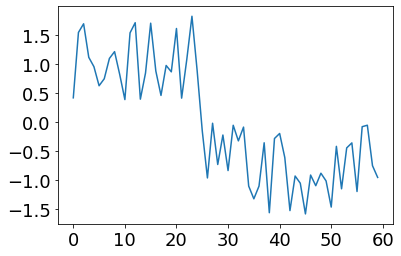

[1. 0. 0. 0. 0. 0.]


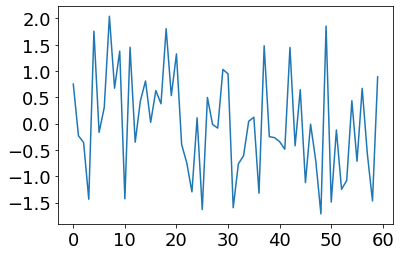

[1. 0. 0. 0. 0. 0.]


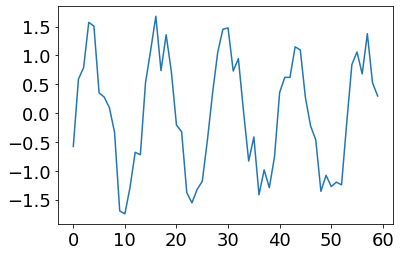

[1. 0. 0. 0. 0. 0.]


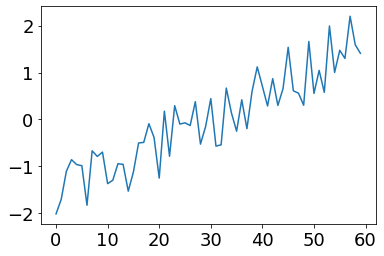

[1. 0. 0. 0. 0. 0.]


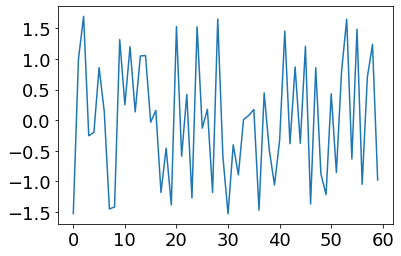

[1. 0. 0. 0. 0. 0.]


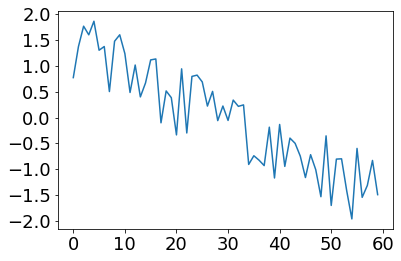

[1. 0. 0. 0. 0. 0.]


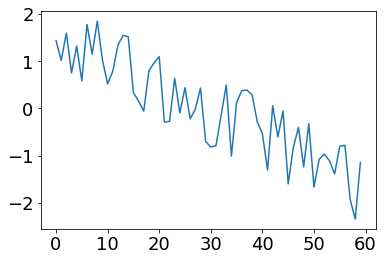

[1. 0. 0. 0. 0. 0.]


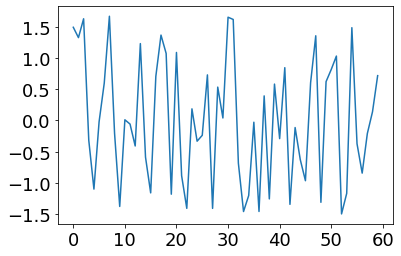

[1. 0. 0. 0. 0. 0.]


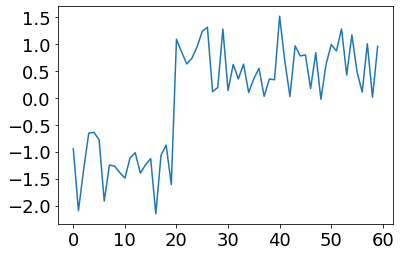

[1. 0. 0. 0. 0. 0.]


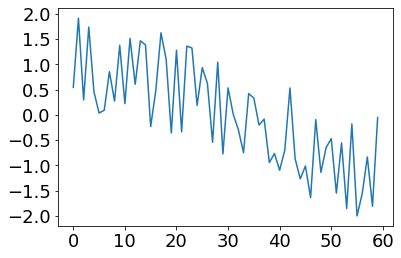

[1. 0. 0. 0. 0. 0.]


In [11]:
#import datetime

#z = 1

#for z in range(290,299):

#    x = range(seqSize)
#    y = outMixedAverage[-5][z]
#    print(y.shape)
#    
#    plt.plot(x,y)
#    plt.show()
#    print(y_test[z])
#    print(outMixedAverage[3][z])
#    print(outSax[3][z])

#output = np.expand_dims(np.array(outAvgAverage[6]).squeeze(), axis=1)
output = X_train
#output = outMixedAverage[-5]

z = 1

for z in range(0,10):

    x = range(seqSize)
    y = output[z]
    
    plt.plot(x,y)
    plt.yticks(fontsize=18)
    plt.xticks(fontsize=18)
    plt.savefig('./Bilder/examples/Example' + str(z) +'fullmatrix.png', dpi = 300)
    plt.show()
    print(y_test[z])


Methods for attention combination

In [12]:
def getMinMax(rMS, lable):
    minV = float('inf')
    maxV = float('-inf')
    for k1 in rMS[lable].keys():
        for k2 in rMS[lable].keys():
            cmv = np.max(rMS[lable][k1][k2])
            if cmv > maxV:
                maxV = cmv
            cmiv = np.min(rMS[lable][k1][k2])
            if cmiv < minV:
                minV = cmiv

    print(minV)
    print(maxV)
    return minV, maxV

In [13]:
# creating all cohrence attention combinations
#TODO abstracting first geht nur wenn wir nochmal trainieren

def makeAttention(outSax, x_train1, y_train1):

    #predicted lables
    attentionQ = outSax[9]
    print('2222222222222')
    print(len(attentionQ[2]))
    print(len(attentionQ[2][0]))
    print(len(attentionQ[2][0][0]))

    
    #data_att = np.flip(np.array(attentionQ[2][0][0][5]), axis=0)
    #attentionQ[1] = np.sum(attentionQ[2], axis=2)
    #attentionQ[1] = np.sum(attentionQ[1], axis=0)
    
    if(order == 'lh'):
        axis1 = 0
        axis2 = 1
    elif(order == 'hl'):
        axis1 = 2
        axis2 = 0
    
    attentionQ[1] = doCombiStep(step1, attentionQ[2], axis1)
    attentionQ[1] = doCombiStep(step2, attentionQ[1], axis2) 
    
    #compared to original predictions
    #predictions = outSax[4].predict(outSax[6])
    #predictions = np.argmax(predictions,axis=1) +1 
    

    #true lables
    predictions = np.argmax(y_train1,axis=1) +1  


    #nestest dict for saves
    def nested_dict(n, type):
        if n == 1:
            return defaultdict(type)
        else:
            return defaultdict(lambda: nested_dict(n-1, type))

    #position counter
    rM = nested_dict(3, list)
    #attention sum at each point
    rMS = nested_dict(3, list)
    #relative average at each point + more side combinations
    rMA = nested_dict(3, list)
    
    labelSet = set(predictions)
    laCount = dict()
    entropyDic = dict()
    for la in labelSet:
        laCount[la] = predictions.tolist().count(la)
        part = laCount[la] / len(predictions)
        entropy = -(part * np.log(part))
        entropyDic[la] = entropy
    
    data_att = attentionQ[1][0]
    for lable in range(1,num_of_classes+1):
        

            for toL in valuesA:

                for fromL in valuesA:
                    if(len(rM[lable][fromL][toL]) is 0):
                        rM[lable][fromL][toL] = np.zeros((len(data_att), len(data_att[0])))
                        rMS[lable][fromL][toL] = np.zeros((len(data_att), len(data_att[0])))
                        rMA[lable][fromL][toL] = np.zeros((len(data_att), len(data_att[0])))

                if len(rMA[lable]['x'][toL]) is 0:
                    rMA[lable]['x'][toL] = np.zeros((len(data_att), len(data_att[0])))

                if len(rMA[lable]['xAvg'][toL]) is 0:
                    rMA[lable]['xAvg'][toL] = np.zeros((len(data_att), len(data_att[0])))

    #put together all train attention to from symbol x to symbol y representation
    z = 0
    x_train1s = np.array(x_train1).squeeze()
    
    
    #heat = doCombiStep(step3, attentionQ[1][index], 0) 

    #max mit 2 und 3, median mit 1 und 1.5
    if doMax:
        maxHeat = np.max(data_att)
        borderHeat = maxHeat/2
        borderHeat2 = maxHeat/3
    else:
        maxHeat = np.average(data_att)
        borderHeat = 0# maxHeat/1.5
       # if predictions[index] == 1:
       #     borderHeat = maxHeat/1.7
       # if predictions[index] == 2:
       #     borderHeat = 0 
       # borderHeat2 = maxHeat/1.65
    
    
    for index in range(len(attentionQ[1])):
        data_word = x_train1s[index]
        X_ori = data_word
        data_att = attentionQ[1][index]
        


        for i in range(len(data_att)):
            for j in range(len(data_att[i])):
                if data_att[i][j] != 0 and data_att[i][j] > borderHeat:
                    rM[predictions[index]][X_ori[i]][X_ori[j]][i][j] += 1           

                    
                    if doPenalty:
                        entropy = entropyDic[predictions[index]]
                        #sum FCAM
                        #rMS[predictions[index]][X_ori[i]][X_ori[j]][i][j] += (1 * (num_of_classes + 1) * data_att[i][j])/ laCount[predictions[index]]

                        adding = num_of_classes * (data_att[i][j]/ entropy)
                        rMS[predictions[index]][X_ori[i]][X_ori[j]][i][j] += adding

                        #CRCAM Sum
                        #rMA[predictions[index]]['x'][X_ori[j]][i][j] += (1 * (num_of_classes + 1) *  data_att[i][j])/ laCount[predictions[index]]
                        rMA[predictions[index]]['x'][X_ori[j]][i][j] += adding
                    
                        for la in labelSet:
                            #rMS[la][X_ori[i]][X_ori[j]][i][j] -= data_att[i][j] / (laCount[predictions[index]])# * num_of_classes)
                            #rMA[la]['x'][X_ori[j]][i][j] -= data_att[i][j] / (laCount[predictions[index]])# * num_of_classes)
                            subbiung = data_att[i][j] / (entropy * num_of_classes)
                            rMS[la][X_ori[i]][X_ori[j]][i][j] -= subbiung
                            rMA[la]['x'][X_ori[j]][i][j] -= subbiung

                    else:
                        rMS[predictions[index]][X_ori[i]][X_ori[j]][i][j] += data_att[i][j]
                        rMA[predictions[index]]['x'][X_ori[j]][i][j] += data_att[i][j]
                #if data_att[i][j] > borderHeat2:
                #    #sum FCAM
                #    rMS[predictions[index]][X_ori[i]][X_ori[j]][i][j] += data_att[i][j] / 1.5
                #    #CRCAM Sum
                #    rMA[predictions[index]]['x'][X_ori[j]][i][j] += data_att[i][j] / 1.5

    
    for lable in rMA.keys():
        #minV, maxV = getMinMax(rMS, lable)
        for toL in valuesA:

            for fromL in valuesA:
                #rMS[lable][fromL][toL] = (rMS[lable][fromL][toL] - minV) / (maxV - minV)
                #X_scaled = X_std * (1 - 0) + 0
                for i in range(len(data_att)):
                    for j in range(len(data_att[i])): 
                        
                        

                        #FCAM r. average
                        if rM[lable][fromL][toL][i][j] > 0:
                            rMA[lable][fromL][toL][i][j] = rMS[lable][fromL][toL][i][j] / float(rM[lable][fromL][toL][i][j])
                        #else:
                        #    rMA[lable][fromL][toL][i][j] = rMS[lable][fromL][toL][i][j]

                        #CRCAM r. average
                        if rM[lable][fromL][toL][i][j] > 0:
                            rMA[lable]['xAvg'][toL][i][j] += rMS[lable][fromL][toL][i][j] / float(rM[lable][fromL][toL][i][j])
                        #else:
                        #    rMA[lable]['xAvg'][toL][i][j] += rMS[lable][fromL][toL][i][j]

            #GTM max of sum                
            rMA[lable]['max'][toL] = np.max(rMA[lable]['x'][toL], axis=0) 
            #GTM average of sum         
            rMA[lable]['average'][toL] = np.mean(rMA[lable]['x'][toL], axis=0) 
            #GTM median of sum         
            rMA[lable]['median'][toL] = np.median(rMA[lable]['x'][toL], axis=0) 
            #GTM max of r.average          
            rMA[lable]['max+'][toL] = np.max(rMA[lable]['xAvg'][toL], axis=0)  
            #GTM average of r.average          
            rMA[lable]['average+'][toL] = np.mean(rMA[lable]['xAvg'][toL], axis=0)
            #GTM median of r.average         
            rMA[lable]['median+'][toL] = np.median(rMA[lable]['xAvg'][toL], axis=0) 
    print('done')

    return rMA, rMS

In [14]:
# creating all cohrence attention combinations
#TODO abstracting first geht nur wenn wir nochmal trainieren

def makeSimpleAttention(outSax, x_train1, y_train1):

    #predicted lables
    attentionQ = outSax[9]
    print('2222222222222')
    print(len(attentionQ[2]))
    print(len(attentionQ[2][0]))
    print(len(attentionQ[2][0][0]))
    
    #data_att = np.flip(np.array(attentionQ[2][0][0][5]), axis=0)
    #attentionQ[1] = np.sum(attentionQ[2], axis=2)
    #attentionQ[1] = np.sum(attentionQ[1], axis=0)
    
    if(order == 'lh'):
        axis1 = 0
        axis2 = 1
    elif(order == 'hl'):
        axis1 = 2
        axis2 = 0
    
    attentionQ[1] = doCombiStep(step1, attentionQ[2], axis1)
    attentionQ[1] = doCombiStep(step2, attentionQ[1], axis2) 
    
    #compared to original predictions
    #predictions = outSax[4].predict(outSax[6])
    #predictions = np.argmax(predictions,axis=1) +1 
    

    #true lables
    predictions = np.argmax(y_train1,axis=1) +1  


    #nestest dict for saves
    def nested_dict(n, type):
        if n == 1:
            return defaultdict(type)
        else:
            return defaultdict(lambda: nested_dict(n-1, type))

    #position counter
    rM = nested_dict(3, list)
    #attention sum at each point
    rMS = nested_dict(3, list)
    #relative average at each point + more side combinations
    rMA = nested_dict(3, list)

    labelSet = set(predictions)
    laCount = dict()
    for la in labelSet:
        laCount[la] = predictions.tolist().count(la)

    #put together all train attention to from symbol x to symbol y representation
    
    data_att = attentionQ[1][0]
    for lable in range(1,num_of_classes+1):
            for toL in valuesA:

                for fromL in valuesA:
                    if(len(rM[lable][fromL][toL]) is 0):
                        rM[lable][fromL][toL] = np.zeros((len(data_att), len(data_att[0])))
                        rMS[lable][fromL][toL] = np.zeros((len(data_att), len(data_att[0])))
                        rMA[lable][fromL][toL] = np.zeros((len(data_att), len(data_att[0])))

                if len(rMA[lable]['x'][toL]) is 0:
                    rMA[lable]['x'][toL] = np.zeros((len(data_att), len(data_att[0])))

                if len(rMA[lable]['xAvg'][toL]) is 0:
                    rMA[lable]['xAvg'][toL] = np.zeros((len(data_att), len(data_att[0])))
    
    
    z = 0
    for index in range(len(attentionQ[1])):
        data_word = np.array(x_train1).squeeze()[index]
        X_ori = data_word
        data_att = attentionQ[1][index]
        
        #heat = doCombiStep(step3, attentionQ[1][index], 0) 
    
        #max mit 2 und 3, median mit 1 und 1.5
        borderHeat = 0 

        for i in range(len(data_att)):
            for j in range(len(data_att[i])):


                #if data_att[i][j] != 0 and data_att[i][j] > borderHeat:
                #    rM[predictions[index]][X_ori[i]][X_ori[j]][i][j] += 1           

                
                if data_att[i][j] >= borderHeat:
                    part = laCount[predictions[index]] / len(predictions)
                    entropy = -(part * np.log(part))
                    #rMS[predictions[index]][X_ori[i]][X_ori[j]][i][j] += 2*(data_att[i][j]/ entropy)
                    
                    rM[predictions[index]][X_ori[i]][X_ori[j]][i][j] += 1
                    #sum FCAM
                    rMS[predictions[index]][X_ori[i]][X_ori[j]][i][j] += 1
                    rMA[predictions[index]]['x'][X_ori[j]][i][j] += 1
                    #rMS[predictions[index]][X_ori[i]][X_ori[j]][i][j] += 2/entropy
                    #CRCAM Sum
                    #rMA[predictions[index]]['x'][X_ori[j]][i][j] += 2/entropy
                    
                    #for la in labelSet:          
                        #rMS[la][X_ori[i]][X_ori[j]][i][j] -= 1 / (entropy * num_of_classes)
                        #rMA[la]['x'][X_ori[j]][i][j] -= 1 / (entropy * num_of_classes)
                    

                #if data_att[i][j] > borderHeat2:
                #    #sum FCAM
                #    rMS[predictions[index]][X_ori[i]][X_ori[j]][i][j] += data_att[i][j] / 1.5
                #    #CRCAM Sum
                #    rMA[predictions[index]]['x'][X_ori[j]][i][j] += data_att[i][j] / 1.5

    
    for lable in rMA.keys():
        for toL in valuesA:

            for fromL in valuesA:
                for j in range(len(data_att[i])):
                    for i in range(len(data_att)): 
                        #
                        #FCAM r. average

                        
                        if rM[lable][fromL][toL][i][j] > 0:
                            #TODO WILL ich das so????
                            rMA[lable][fromL][toL][i][j] = rMS[lable][fromL][toL][i][j] / float(rM[lable][fromL][toL][i][j])
                        else:
                            rMA[lable][fromL][toL][i][j] = rMS[lable][fromL][toL][i][j]

                        #CRCAM r. average
                        if rM[lable][fromL][toL][i][j] > 0:
                            rMA[lable]['xAvg'][toL][i][j] += rMS[lable][fromL][toL][i][j] / float(rM[lable][fromL][toL][i][j])
                        else:
                            rMA[lable]['xAvg'][toL][i][j] += rMS[lable][fromL][toL][i][j]

            #GTM max of sum                
            rMA[lable]['max'][toL] = np.max(rMA[lable]['x'][toL], axis=0) 
            #GTM average of sum         
            rMA[lable]['average'][toL] = np.mean(rMA[lable]['x'][toL], axis=0) 
            #GTM median of sum         
            rMA[lable]['median'][toL] = np.median(rMA[lable]['x'][toL], axis=0) 
            #GTM max of r.average          
            rMA[lable]['max+'][toL] = np.max(rMA[lable]['xAvg'][toL], axis=0)  
            #GTM average of r.average          
            rMA[lable]['average+'][toL] = np.mean(rMA[lable]['xAvg'][toL], axis=0)
            #GTM median of r.average         
            rMA[lable]['median+'][toL] = np.median(rMA[lable]['xAvg'][toL], axis=0) 
    print('done')

    return rMA, rMS

In [15]:
# creating all cohrence attention combinations
#TODO abstracting first geht nur wenn wir nochmal trainieren

def makeAttentionFromAbstract(outSax, x_train1, y_train1):

    #predicted lables
    attentionQ = outSax[9]
    print('2222222222222')
    print(len(attentionQ[2]))
    print(len(attentionQ[2][0]))
    print(len(attentionQ[2][0][0]))
    
    #data_att = np.flip(np.array(attentionQ[2][0][0][5]), axis=0)
    #attentionQ[1] = np.sum(attentionQ[2], axis=2)
    #attentionQ[1] = np.sum(attentionQ[1], axis=0)
    
    if(order == 'lh'):
        axis1 = 0
        axis2 = 1
    elif(order == 'hl'):
        axis1 = 2
        axis2 = 0
    
    attentionQ[1] = doCombiStep(step1, attentionQ[2], axis1)
    attentionQ[1] = doCombiStep(step2, attentionQ[1], axis2) 
    
    #compared to original predictions
    #predictions = outSax[4].predict(outSax[6])
    #predictions = np.argmax(predictions,axis=1) +1 
    

    #true lables
    predictions = np.argmax(y_train1,axis=1) +1  


    #nestest dict for saves
    def nested_dict(n, type):
        if n == 1:
            return defaultdict(type)
        else:
            return defaultdict(lambda: nested_dict(n-1, type))

    #position counter
    rM = nested_dict(3, list)
    #attention sum at each point
    rMS = nested_dict(3, list)
    #relative average at each point + more side combinations
    rMA = nested_dict(3, list)


    #put together all train attention to from symbol x to symbol y representation
    z = 0
    for index in range(len(attentionQ[1])):
        data_word = np.array(x_train1).squeeze()[index]
        X_ori = data_word
        data_att = attentionQ[1][index]
        
        #heat = doCombiStep(step3, attentionQ[1][index], 0) 
    
        #max mit 2 und 3, median mit 1 und 1.5
        if doMax:
            maxHeat = np.max(data_att)
            borderHeat = maxHeat/2
            borderHeat2 = maxHeat/3
        else:
            maxHeat = np.average(data_att)
            borderHeat = 0
            borderHeat2 = maxHeat/1.2

        for i in range(len(data_att)):
            for j in range(len(data_att[i])):
                out = checkAbstractInput(X_ori[j])
                inputj1 = out[3]
                inputj2 = out[4]
                out = checkAbstractInput(X_ori[i])
                inputi1 = out[3]
                inputi2 = out[4]
                
                if(len(rM[predictions[index]][inputi1][inputj1]) is 0):
                    rM[predictions[index]][inputi1][inputj1] = np.zeros((len(data_att), len(data_att[i])))
                    rMS[predictions[index]][inputi1][inputj1] = np.zeros((len(data_att), len(data_att[i])))
                    rMA[predictions[index]][inputi1][inputj1] = np.zeros((len(data_att), len(data_att[i])))

                    if len(rMA[predictions[index]]['x'][inputj1]) is 0:
                        rMA[predictions[index]]['x'][inputj1] = np.zeros((len(data_att), len(data_att[i])))

                    if len(rMA[predictions[index]]['xAvg'][inputj1]) is 0:
                        rMA[predictions[index]]['xAvg'][inputj1] = np.zeros((len(data_att), len(data_att[i])))
                        
                if(len(rM[predictions[index]][inputi2][inputj2]) is 0):
                    rM[predictions[index]][inputi2][inputj2] = np.zeros((len(data_att), len(data_att[i])))
                    rMS[predictions[index]][inputi2][inputj2] = np.zeros((len(data_att), len(data_att[i])))
                    rMA[predictions[index]][inputi2][inputj2] = np.zeros((len(data_att), len(data_att[i])))

                    if len(rMA[predictions[index]]['x'][inputj2]) is 0:
                        rMA[predictions[index]]['x'][inputj2] = np.zeros((len(data_att), len(data_att[i])))

                    if len(rMA[predictions[index]]['xAvg'][inputj2]) is 0:
                        rMA[predictions[index]]['xAvg'][inputj2] = np.zeros((len(data_att), len(data_att[i])))
     

                
                if data_att[i][j] > borderHeat:
                    #sum FCAM
                    if not float(X_ori[j]).is_integer():
                        out = checkAbstractInput(X_ori[j])
                        inputj1v = out[1]
                        inputj2v = out[2]
                        inputj1 = out[3]
                        inputj2 = out[4]

                        rMA[predictions[index]]['x'][inputj1][i][j] += data_att[i][j] * inputj1v
                        rMA[predictions[index]]['x'][inputj2][i][j] += data_att[i][j] * inputj2v

                        
                        if not float(X_ori[i]).is_integer():
                            out = checkAbstractInput(X_ori[i])
                            inputi1v = out[1]
                            inputi2v = out[2]
                            inputi1 = out[3]
                            inputi2 = out[4]
                            
                            rMS[predictions[index]][inputi1][inputj1][i][j] += data_att[i][j] * inputi1v * inputj1v
                            rMS[predictions[index]][inputi2][inputj2][i][j] += data_att[i][j] * inputi2v * inputj2v
                            rMS[predictions[index]][inputi1][inputj2][i][j] += data_att[i][j] * inputi1v * inputj2v
                            rMS[predictions[index]][inputi2][inputj1][i][j] += data_att[i][j] * inputi2v * inputj1v
                            if data_att[i][j] != 0:
                                rM[predictions[index]][inputi1][inputj1][i][j] += 1
                                rM[predictions[index]][inputi2][inputj2][i][j] += 1
                        else:
                            
                            rMS[predictions[index]][X_ori[i]][inputj1][i][j] += data_att[i][j] * inputj1v
                            rMS[predictions[index]][X_ori[i]][inputj2][i][j] += data_att[i][j] * inputj2v
                            if data_att[i][j] != 0:
                                rM[predictions[index]][X_ori[i]][inputj1][i][j] += 1
                                rM[predictions[index]][X_ori[i]][inputj2][i][j] += 1
                            
                    else:
                        rMA[predictions[index]]['x'][X_ori[j]][i][j] += data_att[i][j]

                        if not float(X_ori[i]).is_integer():
                            out = checkAbstractInput(X_ori[i])
                            inputi1v = out[1]
                            inputi2v = out[2]
                            inputi1 = out[3]
                            inputi2 = out[4]

                            rMS[predictions[index]][inputi1][X_ori[j]][i][j] += data_att[i][j] * inputi1v
                            rMS[predictions[index]][inputi2][X_ori[j]][i][j] += data_att[i][j] * inputi2v
                            if data_att[i][j] != 0:
                                rM[predictions[index]][inputi1][X_ori[j]][i][j] += 1
                                rM[predictions[index]][inputi2][X_ori[j]][i][j] += 1
                        else:
                            rMS[predictions[index]][X_ori[i]][X_ori[j]][i][j] += data_att[i][j]
                            if data_att[i][j] != 0:
                                rM[predictions[index]][X_ori[i]][X_ori[j]][i][j] += 1

                    #CRCAM Sum
                    
                #if data_att[i][j] > borderHeat2:
                #    #sum FCAM
                #    rMS[predictions[index]][X_ori[i]][X_ori[j]][i][j] += data_att[i][j] / 1.5
                #    #CRCAM Sum
                #    rMA[predictions[index]]['x'][X_ori[j]][i][j] += data_att[i][j] / 1.5

    #valuesA = [-1, -0.5, 0, 0.5, 1]
    for lable in rMA.keys():
        for toL in valuesA:

            for fromL in valuesA:
                for j in range(len(data_att[i])):
                    for i in range(len(data_att)): 
                        
                        #FCAM r. average
                        if rM[lable][fromL][toL][i][j] > 0:
                            rMA[lable][fromL][toL][i][j] = rMS[lable][fromL][toL][i][j] / float(rM[lable][fromL][toL][i][j])
                        else:
                            rMA[lable][fromL][toL][i][j] = rMS[lable][fromL][toL][i][j]

                        #CRCAM r. average
                        if rM[lable][fromL][toL][i][j] > 0:
                            rMA[lable]['xAvg'][toL][i][j] += rMS[lable][fromL][toL][i][j] / float(rM[lable][fromL][toL][i][j])
                        else:
                            rMA[lable]['xAvg'][toL][i][j] += rMS[lable][fromL][toL][i][j]

            #GTM max of sum                
            rMA[lable]['max'][toL] = np.max(rMA[lable]['x'][toL], axis=0) 
            #GTM average of sum         
            rMA[lable]['average'][toL] = np.mean(rMA[lable]['x'][toL], axis=0) 
            #GTM median of sum         
            rMA[lable]['median'][toL] = np.median(rMA[lable]['x'][toL], axis=0) 
            #GTM max of r.average          
            rMA[lable]['max+'][toL] = np.max(rMA[lable]['xAvg'][toL], axis=0)  
            #GTM average of r.average          
            rMA[lable]['average+'][toL] = np.mean(rMA[lable]['xAvg'][toL], axis=0)
            #GTM median of r.average         
            rMA[lable]['median+'][toL] = np.median(rMA[lable]['xAvg'][toL], axis=0) 
    print('done')

    return rMA, rMS

In [16]:
def checkAbstractInput(aInput):
    symbols = [-1, -0.5, 0, 0.5, 1]
    if(aInput in symbols):
        return False, aInput, aInput, aInput, aInput
    
    for a in range(len(symbols)-1):
            if(aInput > symbols[a] and aInput < symbols[a+1]):
                factor1 = (aInput - symbols[a]) / (symbols[a+1] - symbols[a])
                factor2 = 1 - factor1
                symbol1 = symbols[a]
                symbol2 = symbols[a+1]
                return True, factor1, factor2, symbol1, symbol2
            
    return False, -2, -2, -2, -2

In [17]:
#validate the full coherence matrices 
def classFullAtt(rMG, x_test, y_testy, inputKeys):
    results = []
    predictResults = []
    allLableScores = []


    maxFound = False

    #sum maximum score
    maxScores = dict()
    for lable in rMG.keys():
        maxis = []
        for fromV in inputKeys:
            print('starting maxing ' + str(lable) + ' progress: ' + str(fromV) + '/' + str(len(inputKeys)))
            maxis.append(np.max(list(rMG[lable][float(fromV)].values()), axis=0))
        if len(maxis) is not 0:
            maxScores[lable]  = np.sum(np.max(maxis, axis=0))
        else:
            maxScores[lable] = -1

    print('done summing max')

    #sum normal score
    for ti in range(len(x_test)):
        print('starting trial ' + str(ti) + '/' + str(len(x_test)))
        trial = x_test[ti]
        lableScores = dict()
        
        for lable in rMG.keys():
            lableScores[lable] = 0

        for fromVi in range(len(trial)):
            fromV = trial[fromVi]
            for toVi in range(len(trial)):
                toV = trial[toVi]

                for lable in rMG.keys():
                    lableScores[lable] += rMG[lable][float(fromV)][float(toV)][fromVi][toVi]

        maxFound = True

        #get final score
        for lable in rMG.keys():
            #if maxScores[lable] > 0 and lableScores[lable] > 0:
            lableScores[lable] = lableScores[lable]/maxScores[lable]
            

        allLableScores.append(lableScores)

        #classification
        biggestValue = float('-inf')
        biggestLable = np.nan
        for lable in lableScores.keys():
            if lableScores[lable] > biggestValue:
                biggestValue = lableScores[lable]
                biggestLable = lable
        predictResults.append(biggestLable)
        results.append(biggestLable == y_testy[ti])

    print(sum(results)/len(results))
    return sum(results)/len(results), allLableScores, results, predictResults

In [18]:
#validate the full coherence matrices 
def classFullAtt2(rMG, x_test, y_testy, inputKeys):
    results = []
    predictResults = []
    allLableScores = []


    maxFound = False

    #sum maximum score
    maxScores = dict()
    for lable in rMG.keys():
        maxis = []
        for fromV in inputKeys:
                maxis.append(np.max(list(rMG[lable][float(fromV)].values()), axis=0))
        maxScores[lable]  = np.sum(np.max(maxis, axis=0))

    print('done summing')

    #sum normal score
    for ti in range(len(x_test)):
        trial = x_test[ti]
        lableScores = dict()
        
        for lable in rMG.keys():
            lableScores[lable] = 0

        for fromVi in range(len(trial)):
            fromV = trial[fromVi]
            outV = checkAbstractInput(float(fromV))
            for toVi in range(len(trial)):
                toV = trial[toVi]
                outT = checkAbstractInput(float(toVi))

                if outV[0]:
                    if outT[0]:
                        for lable in rMG.keys():
                            lableScores[lable] += rMG[lable][outV[3]][outT[3]][fromVi][toVi] * outV[1] *outT[1]
                            lableScores[lable] += rMG[lable][outV[4]][outT[4]][fromVi][toVi] * outV[2] *outT[2]
                            lableScores[lable] += rMG[lable][outV[3]][outT[4]][fromVi][toVi] * outV[1] *outT[2]
                            lableScores[lable] += rMG[lable][outV[4]][outT[3]][fromVi][toVi] * outV[2] *outT[1]
                    else:
                        for lable in rMG.keys():
                            lableScores[lable] += rMG[lable][outV[3]][float(toV)][fromVi][toVi] *outV[1]
                            lableScores[lable] += rMG[lable][outV[4]][float(toV)][fromVi][toVi] *outV[2]
                else:
                    if outT[0]:
                            lableScores[lable] += rMG[lable][float(fromV)][outT[3]][fromVi][toVi] *outT[1]
                            lableScores[lable] += rMG[lable][float(fromV)][outT[4]][fromVi][toVi] *outT[2]
                    else:
                        for lable in rMG.keys():
                            lableScores[lable] += rMG[lable][float(fromV)][float(toV)][fromVi][toVi]
                        
        maxFound = True

        #get final score
        for lable in rMG.keys():
            lableScores[lable] = lableScores[lable]/maxScores[lable]

        allLableScores.append(lableScores)

        #classification
        biggestValue = 0
        biggestLable = np.nan
        for lable in lableScores.keys():
            if lableScores[lable] > biggestValue:
                biggestValue = lableScores[lable]
                biggestLable = lable
        predictResults.append(biggestLable)
        results.append(biggestLable == y_testy[ti])

    print(sum(results)/len(results))
    return sum(results)/len(results)

In [19]:
#validate the column reduced coherence matrices 
def xAttentionMatch(rMA, x_test, y_testy, inputKeys, key):    
    results = []
    predictResults = []
    
    #sum max score
    maxScores = dict()
    for lable in rMA.keys():
            maxScores[lable] = np.sum(np.max(list(rMA[lable][key].values()), axis=0))
    print('done summing')

    #sum normal score
    for ti in range(len(x_test)):
        trial = x_test[ti]
        lableScores = dict()
        
        for lable in rMA.keys():
            lableScores[lable] = 0
        
        for fromVi in range(len(trial)):
            for toVi in range(len(trial)):
                toV = trial[toVi]

                for lable in rMA.keys():
                    lableScores[lable] += rMA[lable][key][float(toV)][fromVi][toVi]

        #get final score                
        for lable in rMA.keys():
            lableScores[lable] = lableScores[lable]/maxScores[lable]
            
        #classification
        biggestValue = 0
        biggestLable = np.nan
        for lable in lableScores.keys():
            if lableScores[lable] > biggestValue:
                biggestValue = lableScores[lable]
                biggestLable = lable
        predictResults.append(biggestLable)
        results.append(biggestLable == y_testy[ti])

    print(sum(results)/len(results))
    return sum(results)/len(results)

In [20]:
#validate the minimal coherence matrix 
def calcFullAbstractAttention(reductionInt, x_test, rMA):
    results = []
    predictResults = []
    
    #all possible implemented reductions
    reduceStrings = ['max','max+','average','average+','median','median+']
    reduceString = reduceStrings[reductionInt]
    
    # calc normal and max scores
    for ti in range(len(x_test)):
        trial = x_test[ti]
        lableScores = dict()
        maxScores = dict()
        for toVi in range(len(trial)):
            toV = trial[toVi]

            for lable in rMA.keys():
                if lable in lableScores.keys():
                    lableScores[lable] += rMA[lable][reduceString][float(toV)][toVi] 
                    maxScores[lable] += np.max(list(rMA[lable][reduceString].values()), axis=0)[toVi]
                else:
                    lableScores[lable] = rMA[lable][reduceString][float(toV)][toVi] 
                    maxScores[lable] =  np.max(list(rMA[lable][reduceString].values()), axis=0)[toVi]

        #get final score
        for lable in rMS.keys():
            lableScores[lable] = lableScores[lable]/maxScores[lable]
        
        #classification
        biggestValue = 0
        biggestLable = np.nan
        for lable in lableScores.keys():
            if lableScores[lable] > biggestValue:
                biggestValue = lableScores[lable]
                biggestLable = lable
        predictResults.append(biggestLable)
        results.append(biggestLable == y_testy[ti])

    print(sum(results)/len(results))
    return sum(results)/len(results)

Model and process methods

In [21]:
#create the transformer model with given information
def createModel(splits, x_train, x_val, x_test, batchSize, num_of_classes, doMask= False, rate = 0, numOfAttentionLayers=2, useEmbed=False):    
        print(np.array(x_train1).shape)
        x_trains = np.dsplit(x_train, splits)
        print(np.array(x_trains).shape)

        x_trainsBatch = np.dsplit(x_train[:batchSize], splits)

        x_tests = np.dsplit(x_test, splits)
        x_vals = np.dsplit(x_val, splits)
        maxLen = len(x_trains[0][0])
        print(maxLen)
        
        if(useEmbed):
            for i in range(splits):
                x_trains[i]= np.array([[" ".join([item[0] for item in x])] for x in x_trains[i]])
                x_trainsBatch[i]= np.array([[" ".join([item[0] for item in x])] for x in x_trainsBatch[i]])
                x_tests[i]= np.array([[" ".join([item[0] for item in x])] for x in x_tests[i]])
                x_vals[i]= np.array([[" ".join([item[0] for item in x])] for x in x_vals[i]])

        print(np.array(x_trains).shape)
        flattenArray = []
        inputShapes = []
        encClasses = []
        for i in range(len(x_trains)):
            if doMask:

                masky = createMask(x_trains[i], 6)
                x_part = np.array(x_trains[i])
                print(np.array(x_part).shape)
            
                seq_len1 = x_part.shape[1]
                if(useEmbed):
                    left_input1 = Input(shape=(1,), dtype=tf.string)
                else:
                    sens1 = x_part.shape[2]
                    input_shape1 = (seq_len1, sens1)
                    left_input1 = tf.keras.layers.Input(input_shape1, name='input_ids')
                    
                mask = tf.keras.layers.Input(shape=masky.shape[1:], name='attention_mask')
                print('masky shape')
                print(masky.shape)
                print(mask)
            else: 
                mask = Input(1)
                x_part = np.array(x_trains[i])
                print(np.array(x_part).shape)
            
                seq_len1 = x_part.shape[1]
                
                if(useEmbed):
                    left_input1 = Input(shape=(1,), dtype=tf.string)
                else:
                    sens1 = x_part.shape[2]
                    input_shape1 = (seq_len1, sens1)
                    left_input1 = Input(input_shape1)

            inputShapes.append(left_input1)
            if doMask:
                inputShapes.append(mask)

            if(useEmbed):
                encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
                    max_tokens=50, output_sequence_length=maxLen)
                encoder.adapt(x_part)

                encoded = encoder(left_input1)
                print(encoder.get_vocabulary())
                input_vocab_size = len(np.array(encoder.get_vocabulary()))
            else:
                encoded = left_input1
                input_vocab_size = 0
            
            #create transformer encoder layer 
            if(useEmbed):
                encClass1 = transformer.Encoder(numOfAttentionLayers, d_model, header, dff, maxLen, rate=rate, input_vocab_size = input_vocab_size + 2, maxLen = maxLen, doEmbedding=useEmbed, doMask=doMask, seed_value=seed_value)
            else:#16,16,16
                encClass1 = transformer.Encoder(numOfAttentionLayers, d_model, header, dff, 5000, rate=rate, input_vocab_size = input_vocab_size + 2, maxLen = maxLen, seed_value=seed_value)
                
            encClasses.append(encClass1)

            maskLayer = tf.keras.layers.Masking(mask_value=-2)
            encInput = maskLayer(encoded)
            enc1, attention, fullAttention = encClass1(encInput)
            flatten1 = Flatten()(enc1)
            flattenArray.append(flatten1)
        

        # Merge nets
        if splits == 1:
            merged = flattenArray[0]
        else:
            merged = concatenate(flattenArray)

        output = Dense(num_of_classes, activation = "sigmoid")(merged)
        
        # Create combined model
        wdcnnt_multi = Model(inputs=inputShapes,outputs=(output))
        print(wdcnnt_multi.summary())
        
        print(wdcnnt_multi.count_params())
        
        tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=seed_value)

        learning_rate = transformer.CustomSchedule(16)
        optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.99, 
                                     epsilon=1e-9)
        
        wdcnnt_multi.compile(optimizer=optimizer,
                    loss='mean_squared_error',
                    metrics=['accuracy'], run_eagerly=False)
        
        print('done')
        
        return wdcnnt_multi, inputShapes, x_trains, x_tests, x_vals

In [22]:
def doCombiStep(step, field, axis):
    if(step == 'max'):
        return np.max(field, axis=axis)
    elif (step == 'sum'):
        return np.sum(field, axis=axis)
    
#interpolation with customized combinations
def abstractDataS(data, earlyPredictorZ, takeAvg = True, heatLayer = 0, interpolate = True):
    limit = 300
    attentionQ0 = []
    attentionQ1 = []
    attentionQ2 = []
    
    splits = 1
    
    
    #data2
    #if(useEmbed):
    #    interpolate = False
    #    data2 = np.dsplit(data, splits)
    #    for i in range(splits):
    #        data2[i]= np.array([[" ".join([item[0] for item in x])] for x in data[i]])
                
                
    for bor in range(int(math.ceil(len(data)/limit))):
        attOut = earlyPredictorZ.predict([data[bor*limit:(bor+1)*limit]])
        attentionQ0.extend(attOut[0]) 
        attentionQ1.extend(attOut[1])

        if len(attentionQ2) == 0:
            attentionQ2 = attOut[2]
        else:
            print(np.array(attentionQ2).shape)
            for k in range(len(attentionQ2)):
                
                attentionQ2[k] = np.append(attentionQ2[k], attOut[2][k], 0)
            print(np.array(attentionQ2).shape)
    
    attentionFQ = [np.array(attentionQ0), np.array(attentionQ1), np.array(attentionQ2)]
    
    print('##########################################')
    print('111111112')
    print(attentionFQ[1].shape)
    print(attentionFQ[2].shape)
    
    if(order == 'lh'):
        axis1 = 0
        axis2 = 1#2
    elif(order == 'hl'):
        axis1 = 2
        axis2 = 0

    attentionFQ[1] = doCombiStep(step1, attentionFQ[2], axis1)
    attentionFQ[1] = doCombiStep(step2, attentionFQ[1], axis2) 

    print(attentionFQ[1].shape)
    newX = []
    reduction = []
    for index in range(len(attentionFQ[1])):        
            if(useEmbed):
                earlyPredictorE = tf.keras.Model(model.inputs, model.layers[1].output)
                X_ori = earlyPredictorE.predict(data2)
                #X_sax = data#np.array(data).squeeze()[index].split(" ")
                #vocab = helper.getMapValues(len(set(X_sax)))
                #X_ori = data#[helper.trans(valx, vocab) for valx in np.array(data).squeeze()[index].split(" ")]
                #X_ori = embedding(data2)
            else:
                X_sax = np.array(data).squeeze()[index]
                X_ori = X_sax 
  
            heat = doCombiStep(step3, attentionFQ[1][index], 0) 
    
            #max mit 2 und 3, median mit 1 und 1.5
            if doMax:
                maxHeat = np.max(heat)
                borderHeat = maxHeat/2
                borderHeat2 = maxHeat/3
            else:
                maxHeat = np.average(heat)
                borderHeat = maxHeat#/0.8
                borderHeat2 = maxHeat/1.2

                
            minLimitMedium = 0
            if interpolate:
                fitleredSet = []
                indexSet = []
                avgSet = []
                for h in range(len(heat)):
                    if heat[h] > borderHeat:
                        if len(avgSet) > minLimitMedium:
                            fitleredSet.append(np.median(avgSet, axis = 0)) #TODO maybe?
                            indexSet.append(h - math.ceil(len(avgSet)/2))
                            avgSet = []
                        fitleredSet.append(X_ori[h])
                        indexSet.append(h)
                    elif heat[h] > borderHeat2:
                        #fitleredSet.append([-1e9])
                        avgSet.append(X_ori[h])
                        #avgSet = []
                    elif len(avgSet) > minLimitMedium:
                        #fitleredSet.append([-1e9])
                        fitleredSet.append(np.median(avgSet, axis = 0)) #TODO maybe
                        indexSet.append(h - math.ceil(len(avgSet)/2))
                        avgSet = []


                if len(avgSet) != 0:
                    fitleredSet.append(np.median(avgSet, axis = 0))
                    indexSet.append(h - math.ceil(len(avgSet)/2))

                reduction.append(1 - len(fitleredSet)/len(heat))

                if(len(fitleredSet) < 2):
                    fitleredSet.append(0)
                    indexSet.append(len(heat))
                newXTemp = interp1d(indexSet, fitleredSet, bounds_error = False, fill_value = -2)
                newX.append([[x] for x in newXTemp(range(len(heat)))])
            
            
            else: 
                fitleredSet = []
                indexSet = []
                avgSet = []
                r = 0
                if useEmbed:
                    fillValue = np.full(X_ori[0], -2)
                else:
                    fillValue = -2
                for h in range(len(heat)):
                    if heat[h] > borderHeat:
                        if len(avgSet) != 0:
                            fitleredSet[h - math.ceil(len(avgSet)/2)] = np.median(avgSet, axis = 0)
                            #indexSet.append(h - math.ceil(len(avgSet)/2))
                            avgSet = []
                        fitleredSet.append(X_ori[h])
                        #indexSet.append(h)
                    elif heat[h] > borderHeat2:
                        fitleredSet.append(fillValue)
                        r += 1
                        avgSet.append(X_ori[h])
                        #avgSet = []
                    elif len(avgSet) != 0:
                        fitleredSet.append(fillValue)
                        r +=1
                        fitleredSet[h - math.ceil(len(avgSet)/2)] = np.median(avgSet, axis = 0)

                        avgSet = []
                    else:
                        fitleredSet.append(fillValue)
                        r +=1
                if len(avgSet) != 0:
                    fitleredSet[h - math.ceil(len(avgSet)/2)] = np.median(avgSet, axis = 0)
                if(useEmbed):
                    reduction.append(1 - r)
                else:
                    reduction.append(1 - len([x for x in fitleredSet if x != -2])/len(heat))
                newX.append([[x] for x in fitleredSet])

            #newX.append([[x] for x in fitleredSet])
    if not useEmbed:
        newX = np.array(newX, dtype=np.float32)
        #newX = np.array(newX *  np.not_equal(newX, -2))
        print(np.array(newX).shape)
        print(data.shape)
    else:
        newX = np.array(newX)
    return newX, reduction, 0

In [23]:
def classifyGlobal(trial, rMG, maxScores):
    lableScores = dict()

    for lable in rMG.keys():
        lableScores[lable] = 0

    for fromVi in range(len(trial)):
        fromV = trial[fromVi]
        for toVi in range(len(trial)):
            toV = trial[toVi]

            for lable in rMG.keys():
                lableScores[lable] += rMG[lable][float(fromV)][float(toV)][fromVi][toVi]

    #get final score
    for lable in rMG.keys():
        #if maxScores[lable] > 0 and lableScores[lable] > 0:
        lableScores[lable] = lableScores[lable]/maxScores[lable]

    #classification
    biggestValue = float('-inf')
    biggestLable = np.nan
    for lable in lableScores.keys():
        if lableScores[lable] > biggestValue:
            biggestValue = lableScores[lable]
            biggestLable = lable
    return biggestLable

def classifyGTM(trial, rMG, reduceString):
    lableScores = dict()
    maxScores = dict()
    for toVi in range(len(trial)):
        toV = trial[toVi]

        for lable in rMG.keys():
            if lable in lableScores.keys():
                lableScores[lable] += rMG[lable][reduceString][float(toV)][toVi] 
                maxScores[lable] += np.max(list(rMG[lable][reduceString].values()), axis=0)[toVi]
            else:
                lableScores[lable] = rMG[lable][reduceString][float(toV)][toVi] 
                maxScores[lable] =  np.max(list(rMG[lable][reduceString].values()), axis=0)[toVi]

    #get final score
    for lable in rMG.keys():
        lableScores[lable] = lableScores[lable]/maxScores[lable]

    #classification
    biggestValue = 0
    biggestLable = np.nan
    for lable in lableScores.keys():
        if lableScores[lable] > biggestValue:
            biggestValue = lableScores[lable]
            biggestLable = lable
    return biggestLable

def getHeatForDataPoint(trial ,indextPoint, rMG, targetLabel):
    score = 0
    fromV = trial[indextPoint]
    for toVi in range(len(trial)):
        toV = trial[toVi]

        score += rMG[lable][float(fromV)][float(toV)][indextPoint][toVi]
    return score

def abstractDataMix(data, rMG, interpolate = True):
    limit = 300
    skipCounter = 0
    
    print('##########################################')
    print('111111112')
    
    #sum maximum score
    maxScores = dict()
    avgScores = dict()
    for lable in rMG.keys():
        maxis = []
        averagies = []
        for fromV in inputKeys:
            print('starting maxing ' + str(lable) + ' progress: ' + str(fromV) + '/' + str(len(inputKeys)))
            maxis.append(np.max(list(rMG[lable][float(fromV)].values()), axis=0))
            averagies.append(np.mean(list(rMG[lable][float(fromV)].values()), axis=0))
        if len(maxis) is not 0:
            maxScores[lable]  = np.sum(np.max(maxis, axis=0))
            avgScores[lable] = np.sum(np.mean(averagies, axis=0), axis=1)
        else:
            maxScores[lable] = -1
            avgScores[lable] = [-1]#* x
    

    newX = []
    reduction = []
    
    dataN = np.array(data).squeeze()
    

    
    for index in range(len(dataN)):        
            if(useEmbed):
                X_sax = dataN[index].split(" ")
                
                vocab = helper.getMapValues(len(set(X_sax)))
                X_ori = [helper.trans(valx, vocab) for valx in np.array(data).squeeze()[index].split(" ")]
            else:
                X_sax = dataN[index]
                X_ori = X_sax 
  
            #heat = doCombiStep(step3, attentionFQ[1][index], 0) 
    
            targetLabel = classifyGlobal(X_sax, rMG, maxScores)
    
            #max mit 2 und 3, median mit 1 und 1.5
            if doMax:
                maxHeat = np.max(heat)
                borderHeat = maxHeat/2
                borderHeat2 = maxHeat/3
            else:
                #maxHeat = np.average(heat)
                #borderHeat = maxHeat
                #borderHeat2 = maxHeat/1.2
                borderHeat = avgScores[targetLabel]/0.8
                borderHeat2 = avgScores[targetLabel]/1.1
                
            #print('borderheat:')
            #print(borderHeat)
            #print('--------')

            if interpolate:
                fitleredSet = []
                indexSet = []
                avgSet = []
                for h in range(len(X_ori)):
                    score = getHeatForDataPoint(X_sax ,h, rMG, targetLabel)
                    #print(score)
                    if score > borderHeat[h]:
                        if len(avgSet) != 0:
                            fitleredSet.append(np.median(avgSet))
                            indexSet.append(h - math.ceil(len(avgSet)/2))
                            avgSet = []
                        fitleredSet.append(X_ori[h])
                        indexSet.append(h)
                    elif score > borderHeat2[h]:
                        #fitleredSet.append([-1e9])
                        avgSet.append(X_ori[h])
                        #avgSet = []
                    elif len(avgSet) != 0:
                        #fitleredSet.append([-1e9])
                        fitleredSet.append(np.median(avgSet))
                        indexSet.append(h - math.ceil(len(avgSet)/2))

                        avgSet = []
                    #else:
                        #fitleredSet.append([-1e9])

                if len(avgSet) != 0:
                    fitleredSet.append(np.median(avgSet))
                    indexSet.append(h - math.ceil(len(avgSet)/2))

                
                #print('#######')
                #print(len(fitleredSet))

                if(len(fitleredSet) < 2):
                    print('doSkip')
                    fitleredSet = []
                    indexSet = []
                    fitleredSet.append(0)
                    fitleredSet.append(0)
                    indexSet.append(0)
                    indexSet.append(len(X_ori))
                    reduction.append(0)
                    skipCounter += 1
                else:
                    reduction.append(1 - len(fitleredSet)/len(X_ori))
                    
                newXTemp = interp1d(indexSet, fitleredSet, bounds_error = False, fill_value = -2)
                newX.append([[x] for x in newXTemp(range(len(X_ori)))])
            
            
            else: 
                print('error')
                #TODO

            #newX.append([[x] for x in fitleredSet])

    newX = np.array(newX, dtype=np.float32)
    #newX = np.array(newX *  np.not_equal(newX, -2))
    print(np.array(newX).shape)
    print(data.shape)
    return newX, reduction, skipCounter

def abstractDataMixGTM(data, rMG, reductionInt, interpolate = True):
    limit = 300
    skipCounter = 0
    
    print('##########################################')
    print('111111112')
    
    reduceStrings = ['max','max+','average','average+','median','median+']
    reduceString = reduceStrings[reductionInt]
    reductionWith = reduceString
    
    newX = []
    reduction = []
    
    dataN = np.array(data).squeeze()
    

    
    for index in range(len(dataN)):        
            if(useEmbed):
                X_sax = dataN[index].split(" ")
                X_ori = [helper.trans(valx) for valx in np.array(data).squeeze()[index].split(" ")]
            else:
                X_sax = dataN[index]
                X_ori = X_sax 
  
            #heat = doCombiStep(step3, attentionFQ[1][index], 0) 
    
            targetLabel = classifyGTM(X_sax, rMG, reduceString)
    
            #max mit 2 und 3, median mit 1 und 1.5
            if doMax:
                maxHeat = np.max(heat)
                borderHeat = maxHeat/2
                borderHeat2 = maxHeat/3
            else:
                borderHeat = np.sum(np.array(list(rMG[targetLabel][reductionWith].values())))
                borderHeat = (borderHeat / np.sum([[a > 0 for a in list(rMG[targetLabel][reductionWith].values())]])) 
                borderHeat2 = borderHeat#/1.2       
                
                #borderHeat = np.mean(np.array(list(rMG[targetLabel][reductionWith].values())), axis=0)
                #borderHeat2 = np.mean(np.array(list(rMG[targetLabel][reductionWith].values())), axis= 0)/1.2
                
            #print('borderheat:')
            #print(borderHeat)
            #print('--------')

            if interpolate:
                fitleredSet = []
                indexSet = []
                avgSet = []
                for h in range(len(X_ori)):
                    score = rMG[targetLabel][reductionWith][float(X_sax[h])][h]
                    #print(score)
                    if score > borderHeat:
                        if len(avgSet) != 0:
                            fitleredSet.append(np.median(avgSet))
                            indexSet.append(h - math.ceil(len(avgSet)/2))
                            avgSet = []
                        fitleredSet.append(X_ori[h])
                        indexSet.append(h)
                    elif score > borderHeat2:
                        #fitleredSet.append([-1e9])
                        avgSet.append(X_ori[h])
                        #avgSet = []
                    elif len(avgSet) != 0:
                        #fitleredSet.append([-1e9])
                        fitleredSet.append(np.median(avgSet))
                        indexSet.append(h - math.ceil(len(avgSet)/2))
                    
                        avgSet = []
                    #else:
                        #fitleredSet.append([-1e9])

                if len(avgSet) != 0:
                    fitleredSet.append(np.median(avgSet))
                    indexSet.append(h - math.ceil(len(avgSet)/2))

                
                #print('#######')
                #print(len(fitleredSet))

                if(len(fitleredSet) < 2):
                    print('doSkip')
                    fitleredSet = []
                    indexSet = []
                    fitleredSet.append(0)
                    fitleredSet.append(0)
                    indexSet.append(0)
                    indexSet.append(len(X_ori))
                    reduction.append(0)
                    skipCounter += 1
                else:
                    reduction.append(1 - len(fitleredSet)/len(X_ori))
                    
                newXTemp = interp1d(indexSet, fitleredSet, bounds_error = False, fill_value = -2)
                newX.append([[x] for x in newXTemp(range(len(X_ori)))])
            
            
            else: 
                print('error')
                #TODO

            #newX.append([[x] for x in fitleredSet])
    
    newX = np.array(newX, dtype=np.float32)
    #newX = np.array(newX *  np.not_equal(newX, -2))
    print(np.array(newX).shape)
    print(data.shape)
    return newX, reduction, skipCounter

In [24]:
#np.array(list(rMA[3]['average+'].values()))
#t = (np.sum(np.array(list(rMA[1]['average+'].values()))) / np.sum([[a > 0 for a in list(rMA[1]['average+'].values())]])) / 0.9
#[a > t for a in list(rMA[1]['average+'].values())]

In [25]:
# building saving name for model weights
def getWeightName(learning = True):
    baseName = "./saves/weights-" + str(data_path_train.split('/')[-1].split('.')[0]) + '-size' + str(seqSize) + '-threshold' + maxString + '-input' + abstractionString + '-fold' + str(fold) + '-bins' + str(n_bins)
    if learning:
        return baseName + '-learning.tf'
    else:
        return baseName + '.tf'

    
# do training for the given model def
def doAbstractedTraining(trainD, valD, testD, abstraction = 0, earlyPredictorZ = None, takeAvg = True, rate=0, heatLayer = 0, numOfAttentionLayers = 1, moddedSteps = False):
    useEmbed2 = useEmbed
    if abstraction == 2 and moddedSteps:
        newTrain, trainReduction, skipCounterTrain = abstractDataS(trainD, earlyPredictorZ, takeAvg = takeAvg, heatLayer = heatLayer)
        newVal, valReduction, skipCounterVal = abstractDataS(valD, earlyPredictorZ, takeAvg = takeAvg, heatLayer = heatLayer)
        newTest, testReduction, skipCounterTest = abstractDataS(testD, earlyPredictorZ, takeAvg = takeAvg, heatLayer = heatLayer)
        useEmbed2 = False
    elif abstraction == 3 and moddedSteps:
        newTrain, trainReduction, skipCounterTrain = abstractDataS(trainD, earlyPredictorZ, takeAvg = takeAvg, heatLayer = heatLayer, interpolate=False)
        newVal, valReduction, skipCounterVal = abstractDataS(valD, earlyPredictorZ, takeAvg = takeAvg, heatLayer = heatLayer, interpolate=False)
        newTest, testReduction, skipCounterTest = abstractDataS(testD, earlyPredictorZ, takeAvg = takeAvg, heatLayer = heatLayer, interpolate=False)
    elif abstraction == 4:
        newTrain, trainReduction, skipCounterTrain = abstractDataMixGTM(trainD, rMA, 1)#abstractDataMix(trainD, rMA)
        newVal, valReduction, skipCounterVal = abstractDataMixGTM(valD, rMA, 1)#abstractDataMix(valD, rMA)
        newTest, testReduction, skipCounterTest = abstractDataMixGTM(testD, rMA, 1)#abstractDataMix(testD, rMA)
    else:
        newTrain = trainD
        newVal = valD
        newTest = testD
        trainReduction = 0
        valReduction = 0
        testReduction = 0
        skipCounterTrain = 0
        skipCounterVal = 0
        skipCounterTest = 0
        
    
    if calcComplexity:
    
        #TODO Avg of all Samples!!!!!
        valShifts = []
        smallerValSet = []
        for val in newVal:
            shifts = -1
            smallerSet = 2
            lastVal = val[0][0]
            rise = -3
            timeSkip = 1
            for v in val[1:]:
                v = v[0]

                if v == -2:
                    timeSkip += 1
                elif helper.truncate((v - lastVal) / timeSkip) != rise:
                    shifts += 1
                    smallerSet += 1
                    rise = helper.truncate((v - lastVal) / timeSkip)
                    lastVal = v
                    timeSkip = 1
                else:
                    lastVal = v
            valShifts.append(shifts)
            smallerValSet.append(smallerSet)

        valShifts = np.average(valShifts)
        smallerValSet = np.average(smallerValSet)


        testShifts = []
        smallerTestSet = []
        print(newTest.shape)
        for val in newTest:
            shifts = -1
            smallerSet = 2
            lastVal = val[0][0]
            rise = -3
            timeSkip = 1
            for v in val[1:]:
                v = v[0]
                if v == -2:
                    timeSkip += 1
                elif round(v - lastVal / timeSkip, 1) != rise:
                    shifts += 1
                    smallerSet += 1
                    rise = round(v - lastVal / timeSkip, 1)
                    lastVal = v
                    timeSkip = 1
                else:
                    lastVal = v
            testShifts.append(shifts)
            smallerTestSet.append(smallerSet)

        testShifts = np.average(testShifts)
        smallerTestSet = np.average(smallerTestSet)

        permutationEntropyVal = 0
        spectralEntropyVal = 0
        decompositionEntropyVal = 0
        approximateEntropyVal = 0
        sampleEntropyVal = 0
        spectralEntropyTest = 0
        permutationEntropyTest = 0
        decompositionEntropyTest = 0
        approximateEntropyTest = 0
        sampleEntropyTest = 0

        print('calc entropies val')
        for x in newVal.squeeze():
            permutationEntropyVal += ant.perm_entropy(x, normalize=True)
            spectralEntropyVal += ant.spectral_entropy(x, sf=100, method='welch', normalize=True, nperseg = seqSize)
            decompositionEntropyVal += ant.svd_entropy(x, normalize=True)
            approximateEntropyVal += ant.app_entropy(x)
            sampleEntropyVal += ant.sample_entropy(x)

        print('calc entropies tests')
        for x in newTest.squeeze():
            spectralEntropyTest += ant.spectral_entropy(x, sf=100, method='welch', normalize=True, nperseg = seqSize) 
            permutationEntropyTest += ant.perm_entropy(x, normalize=True)
            decompositionEntropyTest += ant.svd_entropy(x, normalize=True)
            approximateEntropyTest += ant.app_entropy(x)
            sampleEntropyTest += ant.sample_entropy(x)


        valLen = len(newVal[0])
        testLen = len(newTest[0])
        permutationEntropyVal = permutationEntropyVal / valLen
        spectralEntropyVal = spectralEntropyVal / valLen
        decompositionEntropyVal = decompositionEntropyVal / valLen
        approximateEntropyVal = approximateEntropyVal / valLen
        sampleEntropyVal = sampleEntropyVal / valLen

        spectralEntropyTest = spectralEntropyTest / testLen
        permutationEntropyTest = permutationEntropyTest / testLen
        decompositionEntropyTest = decompositionEntropyTest / testLen
        approximateEntropyTest = approximateEntropyTest / testLen
        sampleEntropyTest = sampleEntropyTest / testLen

        complexityVal = [permutationEntropyVal, spectralEntropyVal, decompositionEntropyVal, approximateEntropyVal, sampleEntropyVal]
        complexityTest = [permutationEntropyTest, spectralEntropyTest, decompositionEntropyTest, approximateEntropyTest, sampleEntropyTest]
    else: 
        complexityVal = []
        complexityTest = []
        smallerValSet = 0
        smallerTestSet = 0
        valShifts, testShifts = 0,0
        
    print('newTrain during abstract training:')
    print(newTrain.shape)
            
    n_model2, inputs2, x_trains2, x_tests2, x_vals2 = createModel(1, newTrain, newVal, newTest , BATCH, num_of_classes, rate=rate, doMask=False, numOfAttentionLayers=numOfAttentionLayers, useEmbed=useEmbed2)
    weightsName = getWeightName(learning=True)
    saveBest2 = transformer.SaveBest(weightsName)
    print(np.array(x_trains2).shape)
    print(np.array(x_vals2).shape)
    #masky = createMask(x_trains2[0], 6)
    #x_trains_mask = {"input_ids": x_trains2[0], "attention_mask": masky}
    x_trains_mask = x_trains2
    #maskyV = createMask(x_vals2[0], 6)
    #x_vals_mask = {"input_ids": x_vals2[0], "attention_mask": maskyV}
    
    if (os.path.isfile(getWeightName(learning=False) + '.index') and useSaves):
        print('found weights to load! Won\'t train model!')
        n_model2.load_weights(getWeightName(learning=False))
    else:
        print('No weights found! Start training model!')
        n_model2.fit(x_trains_mask, y_train1, validation_data = (x_vals2, y_val) , epochs = 500, batch_size = BATCH, verbose=1, callbacks =[earlystop, saveBest2], shuffle = True)
        n_model2.load_weights(getWeightName(learning=True))
        n_model2.save_weights(getWeightName(learning=False), overwrite=True)
        
    #print([lay.name for lay in n_model.layers])
    if(useEmbed2):
        earlyPredictor2 = tf.keras.Model(n_model2.inputs, n_model2.layers[3].output)
    else:
        earlyPredictor2 = tf.keras.Model(n_model2.inputs, n_model2.layers[2].output)

    # Predictions on the validation set
    predictions2 = n_model2.predict(x_vals2)
    
    #print(len(attentionQ))
    #print(attentionQ[1])
    print('############################')
    predictions2 = np.argmax(predictions2,axis=1)

    # Measure this fold's accuracy on validation set compared to actual labels
    y_compare = np.argmax(y_val, axis=1)
    val_score2 = metrics.accuracy_score(y_compare, predictions2)

    #oos_pred2.append(saveBest2.highestAcc)  
    print(f"validation fold score with input {abstractionString}-{maxString}(accuracy): {val_score2}")

    # Predictions on the test set
    #maskyT = createMask(x_tests2[0], 6)
    #x_test_mask = {"input_ids": x_tests2[0], "attention_mask": maskyT}
    #x_test_mask = x_tests2
    limit = 300
    test_predictions_loop2 = []
    for bor in range(int(math.ceil(len(x_tests2[0])/limit))):
        test_predictions_loop2.extend(n_model2.predict([x_tests2[0][bor*limit:(bor+1)*limit]]))

    attentionQ2 = None
    if (not skipDebugSaves) or abstraction < 2:
        attentionQ0 = []
        attentionQ1 = []
        attentionQ2 = []

        for bor in range(int(math.ceil(len(x_trains2[0])/limit))):
            attOut = earlyPredictor2.predict([x_trains2[0][bor*limit:(bor+1)*limit]])
            attentionQ0.extend(attOut[0]) 
            attentionQ1.extend(attOut[1])

            if len(attentionQ2) == 0:
                attentionQ2 = attOut[2]
            else:
                for k in range(len(attentionQ2)):
                    attentionQ2[k] = np.append(attentionQ2[k], attOut[2][k], 0)


        attentionQ2 = [attentionQ0, attentionQ1, attentionQ2]
    #attentionQ2 = earlyPredictor2.predict(x_tests2)
    
    # Append actual labels of the test set to empty list
    y_testyy = [y-1 for y in y_testy]
    #oos_test_y2.append(y_testyy)
    #oos_test_prob2.append(test_predictions_loop2)
    test_predictions_loop2 = np.argmax(test_predictions_loop2, axis=1)
    #oos_test_pred2.append(test_predictions_loop2)

    # Measure this fold's accuracy on test set compared to actual labels
    test_score2 = metrics.accuracy_score(y_testyy, test_predictions_loop2)

    print(f"test fold score with input {abstractionString}-{maxString}(accuracy): {test_score2}")

    if skipDebugSaves and abstraction >= 2:
        return val_score2, test_score2, predictions2, test_predictions_loop2, None, [complexityVal, complexityTest], None, None, None, None, smallerValSet, smallerTestSet, valShifts, testShifts, None, None, None, None, [valReduction, testReduction], [skipCounterTrain,skipCounterVal,skipCounterTest], y_val, y_train1
    else:
        return val_score2, test_score2, predictions2, test_predictions_loop2, n_model2, [complexityVal, complexityTest], x_trains2, x_tests2, x_vals2, attentionQ2, smallerValSet, smallerTestSet, valShifts, testShifts, earlyPredictor2, newTrain, newVal, newTest, [valReduction, testReduction], [skipCounterTrain,skipCounterVal,skipCounterTest], y_val, y_train1


In [26]:
def preprocessData(x_train1, x_val, X_test, y_train1, y_val, y_test, y_trainy, y_testy, binNr):    
    
    x_test = X_test.copy()
    
        
    if(useEmbed):
        processedDataName = "./saves/"+str(data_path_train.split('/')[-1].split('.')[0])+ '-size' + str(seqSize) + '-bin' + str(binNr) + '-symbols' + str(n_bins) + '+embedding'
    else:
        processedDataName = "./saves/"+str(data_path_train.split('/')[-1].split('.')[0])+ '-size' + str(seqSize) + '-bin' + str(binNr) + '-symbols' + str(n_bins)
        
    fileExists = os.path.isfile(processedDataName +'.pkl')

    if(fileExists and useSaves):
        print('found file! Start loading file!')
        res = helper.load_obj(processedDataName)


        for index, v in np.ndenumerate(res):
            print(index)
            res = v
        res.keys()

        x_train1 = res['X_train']
        #x_train1 = res['X_val']
        x_test = res['X_test']
        x_val = res['X_val']
        X_train_ori = res['X_train_ori']
        X_test_ori = res['X_test_ori']
        y_trainy = res['y_trainy']
        y_train1 = res['y_train']
        y_test = res['y_test']
        y_testy = res['y_testy']
        y_val = res['y_val']
        X_val_ori = res['X_val_ori']
        print(x_test.shape)
        print(x_train1.shape)
        print(y_test.shape)
        print(y_train.shape)
        print('SHAPES loaded')
        
    else:
        print('SHAPES:')
        print(x_test.shape)
        print(x_train1.shape)
        print(x_val.shape)
        print(y_test.shape)
        print(y_train.shape)
        
        x_train1 = x_train1.squeeze()
        x_val = x_val.squeeze()
        x_test = x_test.squeeze()
        
        trainShape = x_train1.shape
        valShape = x_val.shape
        testShape = x_test.shape
        
        if multiVariant:
            X_test_ori = x_test.copy()
            X_val_ori = x_val.copy()
            X_train_ori = x_train1.copy()
            for i in range(trainShape[-1]):
                x_train2 = x_train1[:,:,i]
                x_val2 = x_val[:,:,i]
                x_test2 = x_test[:,:,i]
                print('####')
                print(x_train2.shape)

                trainShape2 = x_train2.shape
                valShape2 = x_val2.shape
                testShape2 = x_test2.shape
        
                scaler = StandardScaler()    
                scaler = scaler.fit(x_train1.reshape((-1,1)))
                x_train2 = scaler.transform(x_train2.reshape(-1, 1)).reshape(trainShape2)##
                x_val2 = scaler.transform(x_val2.reshape(-1, 1)).reshape(valShape2)
                x_test2 = scaler.transform(x_test2.reshape(-1, 1)).reshape(testShape2)

                sax = SymbolicAggregateApproximation(n_bins=n_bins, strategy='uniform')
                sax.fit(x_train2)

                if(useEmbed):
                    x_train2 = helper.symbolize(x_train2, sax)
                    x_val2 = helper.symbolize(x_val2, sax)
                    x_test2 = helper.symbolize(x_test2, sax)
                else:
                    x_train2 = helper.symbolizeTrans(x_train2, sax, bins = n_bins)
                    x_val2 = helper.symbolizeTrans(x_val2, sax, bins = n_bins)
                    x_test2 = helper.symbolizeTrans(x_test2, sax, bins = n_bins)
                print(x_train2.shape)
                #x_train1 = np.expand_dims(x_train1, axis=2)

                x_train1[:,:,i] = x_train2      
                x_val[:,:,i] = x_val2
                x_test[:,:,i] = x_test2
                
            #x_train1 = x_train1.reshape(trainShape[0],-1,1)
            #x_val = x_val.reshape(valShape[0],-1,1)
            #x_test = x_test.reshape(testShape[0],-1,1)
            print(X_train.shape)
            

        else:    
            if(doSymbolify):
                scaler = StandardScaler()    
                scaler = scaler.fit(x_train1.reshape((-1,1)))
                x_train1 = scaler.transform(x_train1.reshape(-1, 1)).reshape(trainShape)
                x_val = scaler.transform(x_val.reshape(-1, 1)).reshape(valShape)
                x_test = scaler.transform(x_test.reshape(-1, 1)).reshape(testShape)

                X_test_ori = x_test.copy()
                X_val_ori = x_val.copy()
                X_train_ori = x_train1.copy()


                sax = SymbolicAggregateApproximation(n_bins=n_bins, strategy='uniform')
                sax.fit(x_train1)

                if(useEmbed):
                    x_train1 = helper.symbolize(x_train1, sax)
                    x_val = helper.symbolize(x_val, sax)
                    x_test = helper.symbolize(x_test, sax)
                else:
                    x_train1 = helper.symbolizeTrans(x_train1, sax, bins = n_bins)
                    x_val = helper.symbolizeTrans(x_val, sax, bins = n_bins)
                    x_test = helper.symbolizeTrans(x_test, sax, bins = n_bins)
            else:
                X_test_ori = x_test.copy()
                X_val_ori = x_val.copy()
                X_train_ori = x_train1.copy()

            x_train1 = np.expand_dims(x_train1, axis=2)
            x_val = np.expand_dims(x_val, axis=2)
            x_test = np.expand_dims(x_test, axis=2)   
            X_test_ori = np.expand_dims(X_test_ori, axis=2)   
            X_train_ori = np.expand_dims(X_train_ori, axis=2) 
            X_val_ori = np.expand_dims(X_val_ori, axis=2) 

        print('saves shapes:')
        print(x_test.shape)
        print(x_train1.shape)

        #save sax results to only calculate them once
        resultsSave = {
            'X_train':x_train1,
            'X_train_ori':X_train_ori,
            'X_test':x_test,
            'X_test_ori':X_test_ori,
            'X_val': x_val,
            'X_val_ori':X_val_ori,
            'y_trainy':y_trainy,
            'y_train':y_train1,
            'y_val': y_val,
            'y_test':y_test,
            'y_testy':y_testy
        }
        helper.save_obj(resultsSave, processedDataName)
    return x_train1, x_val, x_test, y_train1, y_val, y_test, X_train_ori, X_val_ori, X_test_ori, y_trainy, y_testy

## Start train and evaluation loop

In [27]:
# Initialize loop for every kth fold

# Build empty lists for results

#TODO makeAttention -> do abstraction while summing? and split medium strong attended points
#    - Test what happens with no median points!
#TODO validate -> do i need to make sure semi parts are connected?

#Option 1:
#Clac attention of abstraction and cut low attention
#Option2:

#Problems:
#when you take the median the original input does not need to cross it (meet it) at all
#what if we abstract based on 2d matrix and bevor validation take reduced string?
    # thus need special validation for interpolated inputs?

####Test#####
#Trainieren unterschiedliche Tresholds per Class?
#Abziehen von Klassenwerten um die Unterschiede stärker hervorzuheben?
#combi (local + gloabal) weiter verfeinern??
#Attention übernahme über Sigmoid ähnliche Verteilung bestimmten?

 ##### here #####   
# stärkere abstraction testen??? also noch mehr abschneiden?    
    
#1. LAAMs einer klasse anschauen
#2 sum und r average der klasse anschauen (ggf gtm?)
# individuelle thresholds per klasse!!!!
# prüfen ob man individuell auch medium strong definieren kann
# weil am Ende gibt es eine Attention Representation welchen zum klassifizieren genutzt wird! 
# wie bestimmte oder automatisiere ich die thresholds?

doAbstraction = False
doGlobalAbstraction = False
doGlobal2 = True

#Indication to many heads can be bad in some cases? -> data not convergating correctly which is normal with different data complexity
#zu viele header verringert maximale reduction? ggf dann mehr fine tunen?
#Info always keep in mind that threshold needs normaly to be fine tuned and reduced data can be unoptimal for to complex NNs!
numOfAttentionLayers = 2
d_model = 16
header = 8
dff = 8


takeAvg = True
calcOri = True
doPenalty = False
skipDebugSaves = False

useSaves = True

#drouput rate
rate=0.3
#ifembedding?
#rate=0.38

#preFix = 'local+lh+max+max+max++global+lh+max+sum'
#usedAbstraction = ['Ori', 'SAX', 'interpol', 'mask', 'global']    
usedAbstraction = ['Ori', 'SAX', 'interpol', 'interpol', 'global']    
usedThresholds = ['None', 'None', 'average', 'max']   
reduceString = ['max','max+','average','average+','median','median+']
BATCH = 50
fold = 0

orders = ['lh','hl'] # l = layers, h = headers
steps = ['sum', 'max']
globalPrefix = '++global+lh+max+sum'

accResults = [[],[]]
resultNames = ['Ori', 'SAX']

for train, test in kf.split(X_train, y_trainy): # Must specify y StratifiedKFold for 
    fold+=1
    print(f"Fold #{fold}")
    
    
    if doANDOR:
        print("DOING ANDOR")
        x_train1 = X_train
        x_val = X_train
        y_train1 = y_train
        y_trainy2 = y_trainy
        y_val = y_train
    else:
        #preprocess data
        x_train1 = X_train[train]
        x_val = X_train[test]
        y_train1 = y_train[train]
        y_trainy2 = y_trainy[train]
        y_val = y_train[test]
    
    #x_train1, x_val, x_test, y_train1, y_val, y_test, X_train_ori, X_val_ori, X_test_ori, y_trainy2, y_testy2 = preprocessData(x_train1, x_val, X_test, y_train1, y_val, y_test, y_trainy2, y_testy, fold)
    x_train1, x_val, x_test, y_train1, y_val, y_test, X_train_ori, X_val_ori, X_test_ori, y_trainy2, y_testy2 = modelCreator.preprocessData(x_train1, x_val, X_test, y_train1, y_val, y_test, y_trainy2, y_testy, fold, symbolCount, dataName, useEmbed = False, useSaves = useSaves, doSymbolify = True, multiVariant=False)

    
    #break
    #ori data    
    maxString = 'None'
    preFix = ''
    abstractionIndex = 0
    resultIndex = 0
    if(calcOri):
        abstractionString = usedAbstraction[abstractionIndex]    
        #outOri = doAbstractedTraining(X_train_ori, X_val_ori, X_test_ori, abstractionIndex, rate=rate, takeAvg = takeAvg, heatLayer = 0, numOfAttentionLayers = numOfAttentionLayers)   
        outOri = modelCreator.doAbstractedTraining(X_train_ori, X_val_ori, X_test_ori, y_train1, y_val, y_testy, BATCH, seed_value, 
            num_of_classes, dataName+"testOriTrain", 
            fold, 5, 500, numOfAttentionLayers, d_model, header, dff, skipDebugSaves=True, rMA = None, useEmbed = False, 
            earlystop = earlystop, useSaves=useSaves, abstractionType='Ori', takeAvg = True, heatLayer=0, rate=0.3, 
            calcComplexity=False, abstraction = 0, reductionInt = -1, order=None, step1=None, 
            step2=None, step3=None, doMax=None, earlyPredictorZ = None)
        accResults[resultIndex].append(outOri)
    else:
        accResults[resultIndex].append([[0]])
    resultIndex+=1
    
    # sax data    #TODO to modelCreator
    abstractionIndex += 1
    abstractionString = usedAbstraction[abstractionIndex]  
    #outSax = doAbstractedTraining(x_train1, x_val, x_test, abstractionIndex, rate=rate, takeAvg = takeAvg, heatLayer = 0, numOfAttentionLayers = numOfAttentionLayers)   
    outSax = modelCreator.doAbstractedTraining(x_train1, x_val, x_test, y_train1, y_val, y_testy, BATCH, seed_value, 
        num_of_classes, dataName+"testTrain", 
        fold, 5, 500, numOfAttentionLayers, d_model, header, dff, skipDebugSaves=True, rMA = None, useEmbed = False, 
        earlystop = earlystop, useSaves=useSaves, abstractionType='SAX', takeAvg = True, heatLayer=0, rate=0.3, 
        calcComplexity=False, abstraction = 0, reductionInt = -1, order=None, step1=None, 
        step2=None, step3=None, doMax=None, earlyPredictorZ = None)
    print('###########################')
    accResults[resultIndex].append(outSax)
    resultIndex+=1
    
    
    order = 'hl'#'lh'
    step1 = 'max'
    step2 = 'sum'
    step3 = 'max'
    
    useSaves = True
    
    if doAbstraction:
        
        #for order in orders:
        #    for step1 in steps:
        #        for step2 in steps:
        #            for step3 in steps:
        preFix = 'local+'+order+'+'+step1+ '+' + step2 +'+'+ step3 +globalPrefix

        earlyPredictor = outSax[-8]
        abstractionIndex = 2 #2 interpolation; 3 no interpolation
        abstractionString = usedAbstraction[abstractionIndex]  
        doMax = False
        maxString = 'average'
        
        #outAvgAverage = doAbstractedTraining(x_train1, x_val, x_test, abstractionIndex, earlyPredictorZ=earlyPredictor, rate=rate, takeAvg = takeAvg, heatLayer = 0, numOfAttentionLayers = numOfAttentionLayers, moddedSteps=True)   

        
        outAvgAverage = modelCreator.doAbstractedTraining(x_train1, x_val, x_test, y_train1, y_val, y_testy, BATCH, seed_value, num_of_classes, "test", fold, 5, 500, numOfAttentionLayers, d_model, header, dff, skipDebugSaves=True, rMA = None, useEmbed = False, earlystop = earlystop, useSaves=useSaves, 
            abstractionType=maxString, takeAvg = True, heatLayer=0, rate=0.3, calcComplexity=False, abstraction = 2, reductionInt = -1, thresholdSet=[1,1.5], order=order, step1=step1, step2=step2, step3=step3, doMax=doMax, earlyPredictorZ = earlyPredictor)
        print('###########################')

        if fold == 1:
            accResults.append([outAvgAverage])
            resultNames.append('local avg Interpolaton: ' +order+'+'+step1+'+'+step2+'+'+step3)
        else:
            accResults[resultIndex].append(outAvgAverage)
        resultIndex += 1    
        
        if(True):
            doMax = True
            maxString = 'max'
            #outMaxAverage = doAbstractedTraining(x_train1, x_val, x_test, abstractionIndex, earlyPredictorZ=earlyPredictor, rate=rate, takeAvg = takeAvg, heatLayer = 0, numOfAttentionLayers = numOfAttentionLayers, moddedSteps=True)   
            outMaxAverage = modelCreator.doAbstractedTraining(x_train1, x_val, x_test, y_train1, y_val, y_testy, BATCH, seed_value, num_of_classes, "test", fold, 5, 500, numOfAttentionLayers, d_model, header, dff, skipDebugSaves=True, rMA = None, useEmbed = False, earlystop = earlystop, useSaves=useSaves, 
                abstractionType=maxString, takeAvg = True, heatLayer=0, rate=0.3, calcComplexity=False, abstraction = 2, reductionInt = -1, thresholdSet=[2,3], order=order, step1=step1, step2=step2, step3=step3, doMax=doMax, earlyPredictorZ = earlyPredictor)
            #print('###########################')
            if fold == 1:
                accResults.append([outMaxAverage])
                resultNames.append('local max Interpolaton: ' +order+'+'+step1+'+'+step2+'+'+step3)
            else:
                accResults[resultIndex].append(outMaxAverage)

            resultIndex += 1
        ###
        
    if doGlobal2:
        rMA, rMS, rM = GCRPlus.makeAttention(np.array(outSax[9]), x_train1, y_train1, order, step1, step2, num_of_classes, valuesA, doThreshold=False, doMax=False, doPenalty=True, penaltyMode="counter")#entropy; counter
        
        
        print('start global')
        abstractionIndex += 1
        abstractionString = usedAbstraction[abstractionIndex]  
        predictions = np.argmax(y_train1,axis=1) +1
        gtmAbstractions = ['max','max+','average','average+','median','median+']
        mstart = datetime.now()
        bestGTMIndex, resultDict = mainHelper.doGCRClassify(abstractionString, rMA, rMS, rM, np.array(outOri[3]),  np.array(outSax[3]), np.array(outOri[2][0]), np.array(outSax[2][0]), x_train1, predictions, x_test, y_testy, gtmAbstractions, valuesA, doTest = False)
        #mainHelper.doPenaltyGCRFull("entropy", "test", fold, outSax[9], x_train1, y_train1, order, step1, step2, num_of_classes, valuesA ,np.array(outOri[3]),  np.array(outSax[3]), np.array(outOri[2][0]), np.array(outSax[2][0]),  predictions, x_test, y_testy, gtmAbstractions, doTest = False)
        print('FINAL TIME')
        print(datetime.now() - mstart)
        print(bestGTMIndex)
        
    if doGlobalAbstraction:
            doMax = False
            print('soon start global')
            #abstractionString = usedAbstraction[abstractionIndex]  
            #doMax = False
            #maxString = 'average'
            #outAvgMask = doAbstractedTraining(x_train1, x_val, x_test, abstractionIndex, earlyPredictorZ=earlyPredictor, rate=rate, takeAvg = takeAvg, heatLayer = 0, numOfAttentionLayers = numOfAttentionLayers)   
            #accResults[resultIndex].append(outAvgMask)
            #resultIndex+=1         
            #doMax = True
            #maxString = 'max'
            #outMaxMask = doAbstractedTraining(x_train1, x_val, x_test, abstractionIndex, earlyPredictorZ=earlyPredictor, rate=rate, takeAvg = takeAvg, heatLayer = 0, numOfAttentionLayers = numOfAttentionLayers)   
            #accResults[resultIndex].append(outMaxMask)
            #resultIndex+=1

            #if doGlobalAbstraction:
            #rMA, rMS = makeAttention(outSax, x_train1, y_train1)

            #normale test daten testen
            #attention von sax nehmen und nur die abstrahierten input Daten betrachten!? 
            #print(outAvgAverage[-5][1])
            #rMA, rMS = makeAttention(outSax,outAvgAverage[-5], y_train1)
            
            #rMA, rMS = makeAttention(outSax,x_train1, y_train1)
            #rMA, rMS, avgScore = GCRPlus.makeAttention(np.array(outSax[9]), x_train1, y_train1, order, step1, step2, num_of_classes, valuesA, doThreshold=False, doMax=False, doPenalty=True, penaltyMode="counter")#entropy; counter
            rMA, rMS, rM = GCRPlus.makeAttention(np.array(outSax[9]), x_train1, y_train1, order, step1, step2, num_of_classes, valuesA, doThreshold=False, doMax=False, doPenalty=True, penaltyMode="entropy")#entropy; counter
            #rMA, rMS = makeSimpleAttention(outSax,x_train1, y_train1)
            #rMA, rMS = makeAttentionFromAbstract(outAvgAverage,outAvgAverage[-5], y_train1)
            
            # x_test = outAvgAverage[-3]
            # x_val = outAvgAverage[-4]
            
            #abstracted test
            #avgTest = outAvgAverage[-3]

            print('start global')
            abstractionIndex += 1
            abstractionString = usedAbstraction[abstractionIndex]  


            
            ###############################
            #doMax = False
            #maxString = 'average'
            #useSaves = False
            #outMixedAverage = doAbstractedTraining(x_train1, x_val, x_test, 4)   
            #if fold == 1:
            #    accResults.append([outMixedAverage])
            #    resultNames.append('mixed avg Interpolaton: ')
            #else:
            #    accResults[resultIndex].append(outMixedAverage)
            #resultIndex += 1    
            #break
            ##########################################
            #full attention coherence
            print('full attention coherence')
            maxString = 'FAC'
            
            if fold == 1:
                accResults.append([classFullAtt(rMS, x_test, y_testy, rMS[1].keys())])
                #accResults.append([GCRPlus.classFullAtt(rMS, x_test, y_testy, avgScore)])
                resultNames.append('global FCAM rms avg abstracted')
            else:
                accResults[resultIndex].append(GCRPlus.classFullAtt(rMS, x_test, y_testy, avgScore))
            resultIndex += 1 
            #####
            
            
            if fold == 1:
                accResults.append([classFullAtt(rMA, x_test, y_testy, rMS[1].keys())])
                #accResults.append([GCRPlus.classFullAtt(rMA, x_test, y_testy, avgScore)])
                resultNames.append('global FCAM rma avg abstracted')
            else:
                accResults[resultIndex].append(GCRPlus.classFullAtt(rMA, x_test, y_testy, avgScore))
                
            print('########################################')  
            maxScores = GCRPlus.calcFCAMMaxScore(rMS, valuesA)
            if fold == 1:
                #accResults.append([classFullAtt(rMS, x_test, y_testy, rMS[1].keys())])
                accResults.append([GCRPlus.classFullAtt(rMS, x_test, y_testy, maxScores, rM)])
                resultNames.append('global FCAM rms avg abstracted')
            else:
                accResults[resultIndex].append(GCRPlus.classFullAtt(rMS, x_test, y_testy, maxScores))
            resultIndex += 1 
            #####
            maxScores = GCRPlus.calcFCAMMaxScore(rMA, valuesA)
            if fold == 1:
                #accResults.append([classFullAtt(rMA, x_test, y_testy, rMS[1].keys())])
                accResults.append([GCRPlus.classFullAtt(rMA, x_test, y_testy, maxScores, rM)])
                resultNames.append('global FCAM rma avg abstracted')
            else:
                accResults[resultIndex].append(GCRPlus.classFullAtt(rMA, x_test, y_testy, maxScores))
            resultIndex += 1  
            
            print('###############**************#########')  
            #x to
            print('x to')
            maxString = 'XAC'
            maxScores = GCRPlus.calcCRCAMMaxScore(rMA, 'x')
            if fold == 1:
                #accResults.append([xAttentionMatch(rMA, x_test, y_testy, valuesA, 'x')])
                accResults.append([GCRPlus.xAttentionMatch(rMA, x_test, y_testy, 'x', avgScore)])
                resultNames.append('global CRCAM rms avg abstracted')
            else:
                accResults[resultIndex].append(GCRPlus.xAttentionMatch(rMA, x_test, y_testy, 'x', avgScore))
                #accResults[resultIndex].append(xAttentionMatch(rMA, x_test, y_testy, valuesA, 'x'))
            
            maxScores = GCRPlus.calcCRCAMMaxScore(rMA, 'xAvg')
            if fold == 1:
                #accResults.append([xAttentionMatch(rMA, x_test, y_testy, valuesA, 'xAvg')])
                accResults.append([GCRPlus.xAttentionMatch(rMA, x_test, y_testy, 'xAvg', avgScore)])
                resultNames.append('global CRCAM rma avg abstracted')
            else:
                #accResults[resultIndex].append(xAttentionMatch(rMA, x_test, y_testy, valuesA, 'xAvg'))
                accResults[resultIndex].append(GCRPlus.xAttentionMatch(rMA, x_test, y_testy, 'xAvg', avgScore))
                
            print('########################################')
            if fold == 1:
                #accResults.append([xAttentionMatch(rMA, x_test, y_testy, valuesA, 'x')])
                accResults.append([GCRPlus.xAttentionMatch(rMA, x_test, y_testy, 'x', maxScores)])
                resultNames.append('global CRCAM rms avg abstracted')
            else:
                accResults[resultIndex].append(GCRPlus.xAttentionMatch(rMA, x_test, y_testy, 'x', maxScores))
                #accResults[resultIndex].append(xAttentionMatch(rMA, x_test, y_testy, valuesA, 'x'))
            if fold == 1:
                #accResults.append([xAttentionMatch(rMA, x_test, y_testy, valuesA, 'xAvg')])
                accResults.append([GCRPlus.xAttentionMatch(rMA, x_test, y_testy, 'xAvg', maxScores)])
                resultNames.append('global CRCAM rma avg abstracted')
            else:
                #accResults[resultIndex].append(xAttentionMatch(rMA, x_test, y_testy, valuesA, 'xAvg'))
                accResults[resultIndex].append(GCRPlus.xAttentionMatch(rMA, x_test, y_testy, 'xAvg', maxScores))
            resultIndex += 1  

            print('###############**************#########')  
            #gloabal 
            print('full abstracted global time series')
            maxString = 'GTM'
                
            for r in range(len(reduceString)):
                print(reduceString[r])
                if fold == 1:
                    accResults.append([GCRPlus.calcFullAbstractAttention(rMA, r, x_test, y_testy, divScore=avgScore)])
                    #accResults.append([calcFullAbstractAttention(r, x_test, rMA)])
                    resultNames.append('global GTM ' + reduceString[r] + ' avg abstracted')
                else:
                    accResults[resultIndex](GCRPlus.calcFullAbstractAttention(rMA, r, x_test, y_testy))
                    
            print('########################################')
            for r in range(len(reduceString)):
                print(reduceString[r])
                if fold == 1:
                    accResults.append([GCRPlus.calcFullAbstractAttention(rMA, r, x_test, y_testy)])
                    #accResults.append([calcFullAbstractAttention(r, x_test, rMA)])
                    resultNames.append('global GTM ' + reduceString[r] + ' avg abstracted')
                else:
                    accResults[resultIndex](GCRPlus.calcFullAbstractAttention(rMA, r, x_test, y_testy))
            resultIndex += 1  
    break
    
rIndex = 0
if doAbstraction:
    for results in accResults:
        resultName = resultNames[rIndex]
        rIndex += 1

        print('#########################################')
        print(resultName + ' Scores:')
        print('#########################################')
        print(f"Avg validation score (accuracy): {np.average([r[0] for r in results])}")   
        print([r[0] for r in results])
        print(f"Avg test score (accuracy): {np.average([r[1] for r in results])}")
        print([r[1] for r in results])
        print(f"Avg Val reduced by: {np.average([r[-2] for r in results])}")
        print(f"Avg Test reduced by: {np.average([r[-1] for r in results])}")
        print(f"Avg Interpol Val Size: {np.average([r[-10] for r in results])}")
        print(f"Avg Interpol Test Size: {np.average([r[-9] for r in results])}")
        print(f"Avg Val shifts: {np.average([r[-8] for r in results])}")
        print(f"Avg Test shifts: {np.average([r[-7] for r in results])}")
        print('-----------')
        print(f"Avg Val Permutation entropy: {np.average([r[5][0][0] for r in results])}")
        print(f"Avg Val Spectral entropy: {np.average([r[5][0][1] for r in results])}")
        print(f"Avg Val Singular value decomposition entropy: {np.average([r[5][0][2] for r in results])}")
        print(f"Avg Val Approximate entropy: {np.average([r[5][0][3] for r in results])}")
        print(f"Avg Val Sample entropy: {np.average([r[5][0][4] for r in results])}")
        
        print(f"Avg Test Permutation entropy: {np.average([r[5][1][0] for r in results])}")
        print(f"Avg Test Spectral entropy: {np.average([r[5][1][1] for r in results])}")
        print(f"Avg Test Singular value decomposition entropy: {np.average([r[5][1][2] for r in results])}")
        print(f"Avg Test Approximate entropy: {np.average([r[5][1][3] for r in results])}")
        print(f"Avg Test Sample entropy: {np.average([r[5][1][4] for r in results])}")
        


        if rIndex > 2:
            abstractValPred = np.concatenate([r[2] for r in results])
            oriValPred = np.concatenate([r[2] for r in accResults[1]])
            valSwitch = 0
            for i in range(len(abstractValPred)):
                if abstractValPred[i] != oriValPred[i]:
                    valSwitch += 1

            abstractTestPred = np.concatenate([r[3] for r in results])
            oriTestPred = np.concatenate([r[3] for r in accResults[1]])
            testSwitch = 0
            for i in range(len(abstractTestPred)):
                if abstractTestPred[i] != oriTestPred[i]:
                    testSwitch += 1

            print(f"Val Switched: {valSwitch / len(abstractValPred)}")

            print(f"Test Switched: {testSwitch / len(abstractTestPred)}")

Fold #1
found file! Start loading file!
()
(300, 60, 1)
(240, 60, 1)
(300, 6)
(240, 6)
SHAPES loaded
newTrain during abstract training:
(240, 60, 1)
(1, 240, 60, 1)
60
(1, 240, 60, 1)
(240, 60, 1)
(None, 60, 1)
#################
(None, 60, 16)
(TensorShape([None, 60, 16]), TensorShape([]))
(TensorShape([None, 60, 16]), TensorShape([]))
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 60, 1)]           0         
_________________________________________________________________
masking (Masking)            (None, 60, 1)             0         
_________________________________________________________________
encoder (Encoder)            ((None, 60, 16), (None, 8 45904     
_________________________________________________________________
flatten_2 (Flatten)          (None, 960)               0         
_____________________________________________________

D:\programme\anaconda\lib\site-packages\ipykernel_launcher.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


starting making relative attention0:00:08.445608
done0:00:14.290869
start global
interpol Sum FCAMinterpol r.Avg FCAMinterpol Sum CRCAM


start summing max CRCAM0:00:00
starting maxing FCAM0:00:00
starting maxing FCAM0:00:00
interpol r.Avg CRCAMstarting gtm

interpol max
starting classify GTM max 0:00:00
start summing max CRCAM0:00:00
processes start GTM0:00:00.002000
processes end GTM0:00:00.073017
results GTM0:00:00.074017
GTM max results: 0.7266666666666667
done summing max CRCAM0:00:00.081018
processes started CRCAM0:00:00
processes ended CRCAM0:00:00.076018
start results CRCAM0:00:00.076018
CRCAM results: 0.5766666666666667
done summing max CRCAM0:00:00.155035
processes started CRCAM0:00:00
processes ended CRCAM0:00:00.074018
start results CRCAM0:00:00.075017
CRCAM results: 0.43
interpol max+
starting classify GTM max+ 0:00:00
processes start GTM0:00:00.002001
processes end GTM0:00:00.072016
results GTM0:00:00.072016
GTM max+ results: 0.9466666666666667
starting gtm
starting gtm
i

D:\programme\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


done summing max FCAM0:00:00.425096processes end GTM0:00:00.071016
results GTM0:00:00.071016
GTM average+ results: 0.8933333333333333

starting classify FCAM0:00:00
processes start FCAM0:00:00
done summing max FCAM0:00:00.486109
starting classify FCAM0:00:00
processes start FCAM0:00:00
interpol median
starting classify GTM median 0:00:00
processes start GTM0:00:00
processes end GTM0:00:00.068016
results GTM0:00:00.069016
GTM median results: 0.74
interpol median+
starting classify GTM median+ 0:00:00
processes start GTM0:00:00
processes end GTM0:00:00.072017
results GTM0:00:00.072017
GTM median+ results: 0.8733333333333333
processes end FCAM0:00:33.540417processes end FCAM0:00:33.542418
start results FCAM0:00:33.541418
FCAM results :0.97

start results FCAM0:00:33.544419
FCAM results :0.7733333333333333
done results FCAM0:00:33.555423
starting gtm
done results FCAM0:00:33.560423
starting gtm
GCR classify full done0:00:34.083540
FINAL TIME
0:00:34.083540
1


In [28]:
0.82
GTM average results: 0.838888
GTM max results: 0.9
    
    
FCAM results :0.7666666666666667
FCAM results :0.9
    Alternative aber: GTM max results: 0.9277777777777778
GTM max results: 0.9277777777777778
0.91739552964042
0.726919339


0.95
0.511

0.8166666666666667
0.54

#0.30434782608695654
#0.19? oder so oder sogar 0.019?

#EEG500 GCR
#0.792
#0.6533333333333333
#0:13:16
#ohne: 15:18.962810
#alt
#0.846???????
#0.026
        
#0.36317
#0.4245524
#{1: 790.6347397841616, 2: 735.8382470771257}
maxScores

{1: 790.6347397841616, 2: 735.8382470771257}

In [ ]:
0.816666
0.555
0.811
0.616
0.877
0.516
0.81111
0.6111
0.8055
0.6944
#np.sum(outMixedAverage[-4][1])/ (le n(outMixedAverage[-4][1]) - outMixedAverage[-3][2]) #-3/4
#outAvgAverage
#outMixedAverage
#classFullAtt(rMA, x_test, y_testy, rMS[1].keys())
validation fold score with input interpol(accuracy): 0.9333333333333333
test fold score with input interpol-False(accuracy): 0.88
    
#WARUM ist auch LASA schlechter??????? Zufall? Falsch interpolated????
validation fold score with input interpol-average(accuracy): 0.95
(None, 60, 16)
test fold score with input interpol-average(accuracy): 0.94

#eventuell kann mixed model overall acc erhöhen? Aber nur minimaler data reduction?


#0.8555


#88
#90


# num of classes jeweils
#88.88
#95.0


In [ ]:
0.9
0.8833333333333333
# eins der alten versionen war ganz stabil?
# entropy macht r. average irgendwie extrem gut????

#0.4753008233058898
#0.30078125
outSax[4].layers[2].weights[3]


#normal
0.9333333333333333
0.9366666666666666
x to
done summing
0.8733333333333333
done summing
0.95
full abstracted global time series
max
0.85
max+
0.8433333333333334
average
0.87
average+
0.9466666666666667
median
0.87
median+
0.95

In [ ]:
#synth simple



# ecg simple 5symbols
done summing
0.7986666666666666
done summing
0.9282222222222222 # besser als das nn

#ecg attention 5symbols
done summing
0.8151111111111111
done summing
0.7051111111111111

#power simple 5symbols
done summing
0.8388888888888889
done summing
0.9611111111111111
x to
done summing
0.8388888888888889
done summing
0.8722222222222222
full abstracted global time series
max
0.8388888888888889
max+
0.9388888888888889
average
0.8388888888888889
average+
0.8111111111111111
median
0.8388888888888889
median+
0.85


#### power bestes so bei ~90
0.877

0.8666 no border

3 bins 1.4 boarder? or was this 0 border?
start global
full attention coherence
done summing
0.8833333333333333
done summing
0.5055555555555555
x to
done summing
0.8611111111111112
done summing
0.5055555555555555
full abstracted global time series
max
0.8833333333333333
max+
0.5166666666666667
average
0.8666666666666667
average+
0.5055555555555555
median
0.8666666666666667
median+
0.5055555555555555

In [ ]:

valuesA = set([str(x) for x in x_train1.reshape((-1,x_train1.shape[-1]))])
#x_train1[index][valueDex]
valuesA

In [ ]:
#basic line classifier
x_train1.shape
#valuesA = [-1, -0.5, 0, 0.5, 1]
#valuesA = list(vocab)


def nested_dict(n, type):
    if n == 1:
        return defaultdict(type)
    else:
        return defaultdict(lambda: nested_dict(n-1, type))
    
maxSize = 0
for trainVal in x_train1:
    lenV = len(trainVal)
    if lenV > maxSize:
        maxSize = lenV

rM = nested_dict(2, list)
for lable in range(1,num_of_classes+1):
#for lable in list(set(y_train1)):
    for symbol in valuesA:
        rM[lable][symbol] = np.zeros(maxSize)

print('start summing')
        
predictions = np.argmax(y_train1,axis=1) +1 
#predictions = y_train1
for index in range(len(x_train1)):
    for valueDex in range(len(x_train1[index])):
        #rM[predictions[index]][x_train1[index][valueDex][0]][valueDex] = 1 
        rM[predictions[index]][str(x_train1[index][valueDex])][valueDex] =  +1 

print('done summing')

maximized = dict()
for lable in rM.keys():
    maximized[lable] = np.max(list(rM[lable].values()), axis=0)

maxScores = dict()
for toVi in range(maxSize):
    for lable in rM.keys():
        if lable in maxScores.keys():
            maxScores[lable] += maximized[lable][toVi]
        else:
            maxScores[lable] = maximized[lable][toVi]

print('finish max')

predictResults = []
results = []
for ti in range(len(x_test)):
        print('starting trial ' + str(ti) + '/' + str(len(x_test)))
        trial = x_test[ti]
        lableScores = dict()
        for toVi in range(len(trial)):
            toV = trial[toVi]

            for lable in rM.keys():
                if lable in lableScores.keys():
                    lableScores[lable] += rM[lable][str(toV)][toVi] 
                    #lableScores[lable] += rM[lable][toV[0]][toVi] 
                else:
                    lableScores[lable] = rM[lable][str(toV)][toVi] 
                    #lableScores[lable] = rM[lable][toV[0]][toVi] 

        #get final score
        for lable in rM.keys():
            lableScores[lable] = lableScores[lable]/maxScores[lable]
        
        #classification
        biggestValue = 0
        biggestLable = np.nan
        for lable in lableScores.keys():
            if lableScores[lable] > biggestValue:
                biggestValue = lableScores[lable]
                biggestLable = lable
        predictResults.append(biggestLable)
        results.append(biggestLable == y_testy[ti])

print(sum(results)/len(results))
sum(results)/len(results)

In [ ]:
#basic line classifier
print(x_train1.shape)
valuesA = [-1, -0.5, 0, 0.5, 1]
#valuesA = list(vocab)


def nested_dict(n, type):
    if n == 1:
        return defaultdict(type)
    else:
        return defaultdict(lambda: nested_dict(n-1, type))
    
maxSize = 0
for trainVal in x_train1:
    lenV = len(trainVal)
    if lenV > maxSize:
        maxSize = lenV

rM = nested_dict(2, list)
for lable in range(1,num_of_classes+1):
#for lable in list(set(y_train1)):
    for symbol in valuesA:
        rM[lable][symbol] = np.zeros(maxSize)

print('start summing')
        
predictions = np.argmax(y_train1,axis=1) +1 
#predictions = y_train1
for index in range(len(x_train1)):
    for valueDex in range(len(x_train1[index])):
        #rM[predictions[index]][x_train1[index][valueDex][0]][valueDex] = 1 
        rM[predictions[index]][x_train1[index][valueDex][0]][valueDex] += 1 

print('done summing')

maximized = dict()
for lable in rM.keys():
    maximized[lable] = np.max(list(rM[lable].values()), axis=0)

maxScores = dict()
for toVi in range(maxSize):
    for lable in rM.keys():
        if lable in maxScores.keys():
            maxScores[lable] += maximized[lable][toVi]
        else:
            maxScores[lable] = maximized[lable][toVi]

print('finish max')

predictResults = []
results = []
for ti in range(len(x_test)):
        print('starting trial ' + str(ti) + '/' + str(len(x_test)))
        trial = x_test[ti]
        lableScores = dict()
        for toVi in range(len(trial)):
            #toV = trial[toVi]
            toV = trial[toVi][0]
            
            for lable in rM.keys():
                if lable in lableScores.keys():
                    lableScores[lable] += rM[lable][float(toV)][toVi] 
                    #lableScores[lable] += rM[lable][toV[0]][toVi] 
                else:
                    lableScores[lable] = rM[lable][float(toV)][toVi] 
                    #lableScores[lable] = rM[lable][toV[0]][toVi] 

        #get final score
        for lable in rM.keys():
            lableScores[lable] = lableScores[lable]/maxScores[lable]
        
        #classification
        biggestValue = 0
        biggestLable = np.nan
        for lable in lableScores.keys():
            if lableScores[lable] > biggestValue:
                biggestValue = lableScores[lable]
                biggestLable = lable
        predictResults.append(biggestLable)
        results.append(biggestLable == y_testy[ti])

print(sum(results)/len(results))
sum(results)/len(results)

In [ ]:
import dill as pickle

def load_obj2(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)
    
def save_obj2(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f)


processedDataName = "./saves/"+str(data_path_train.split('/')[-1].split('.')[0])+ '-size' + str(seqSize) + '-symbols' + str(n_bins) + '-pre-fcam' 
fileExists = os.path.isfile(processedDataName +'.pkl')

if(fileExists and useSaves):
    print('found file! Start loading file!')
    resultsSave = load_obj2(processedDataName)

else:
    resultsSave = rM
    save_obj2(resultsSave, processedDataName)

In [ ]:
#baseline mat mul vocabs
x_train1.shape
#valuesA = list(vocab)
#valuesA = [-1, -0.5, 0, 0.5, 1]

def nested_dict(n, type):
    if n == 1:
        return defaultdict(type)
    else:
        return defaultdict(lambda: nested_dict(n-1, type))


predictions = np.argmax(y_train1,axis=1) +1 
rM = nested_dict(3, list)
for lable in list(set(predictions)):
    for symbol in valuesA:
        for symbol2 in valuesA:
            rM[lable][symbol][symbol2] = np.zeros((len(x_train1[0]),len(x_train1[0])))
            
print('start summing')
            
#predictions = y_train1
for index in range(len(x_train1)):
    #product = np.matmul(x_train1[index], x_train1[index].T)
    for fromVi in range(len(x_train1[index])):
        fromV = x_train1[index][fromVi]
        for toVi in range(len(x_train1[index])):
            toV = x_train1[index][toVi]
            #rM[predictions[index]][fromV][toV][fromVi][toVi] = 1 
            rM[predictions[index]][str(fromV)][str(toV)][fromVi][toVi] += 1
            
print('done summing')
#TODO Safe summing???
        
classFullAtt(rM, x_test, y_testy, rM[1].keys())

In [ ]:
#baseline mat mul vocabs
    
x_train1.shape
#valuesA = list(vocab)
#valuesA = [-1, -0.5, 0, 0.5, 1]

def nested_dict(n, type):
    if n == 1:
        return defaultdict(type)
    else:
        return defaultdict(lambda: nested_dict(n-1, type))


    
predictions = np.argmax(y_train1,axis=1) +1 
rM = nested_dict(3, list)

#for lable in list(set(predictions)):
for lable in range(1,num_of_classes+1):
    for symbol in valuesA:
        for symbol2 in valuesA:
            rM[lable][symbol][symbol2] = np.zeros((len(x_train1[0]),len(x_train1[0])))
            
print('start summing')


labelSet = set(predictions)
laCount = dict()
for la in labelSet:
    laCount[la] = predictions.tolist().count(la)

#predictions = y_train1
for index in range(len(x_train1)):
    #product = np.matmul(x_train1[index], x_train1[index].T)
    for fromVi in range(len(x_train1[index])):
        fromV = x_train1[index][fromVi][0]
        for toVi in range(len(x_train1[index])):
            toV = x_train1[index][toVi][0]
            #rM[predictions[index]][fromV][toV][fromVi][toVi] = 1 
            rM[predictions[index]][fromV][toV][fromVi][toVi] += 1 / laCount[predictions[index]]
            
            #for la in labelSet:
            #for toVi2 in range(len(x_train1[index])):    
                #rM[la][fromV][toV][fromVi][toVi] -= 1 / laCount[predictions[index]]
                #rM[predictions[index]][fromV][toV][fromVi][toVi2] -= 1 #/ laCount[predictions[index]]
            
print('done summing')
            
#rMS = rM

out = classFullAtt(rM, x_test, y_testy, rM[1].keys())

out[0]

In [ ]:
#linear geht nicht mit +1 -> 0.5174160861304623
# verusche log? (weil sehr starker bias zu lable 2)

fold = 0
for train, test in kf.split(X_train, y_trainy): # Must specify y StratifiedKFold for 
    fold+=1
    print(f"Fold #{fold}")
    
    
    #preprocess data
    x_train1 = X_train[train]
    x_val = X_train[test]
    y_train1 = y_train[train]
    y_trainy2 = y_trainy[train]
    y_val = y_train[test]
    
    useSaves = False
    n_bins = 5
    x_train1, x_val, x_test, y_train1, y_val, y_test, X_train_ori, X_val_ori, X_test_ori, y_trainy2, y_testy2 = preprocessData(x_train1, x_val, X_test, y_train1, y_val, y_test, y_trainy2, y_testy, fold)

    #baseline mat mul
    valuesA = set(x_train1.flatten())
    #valuesA = [-1, -0.5, 0, 0.5, 1]

    def nested_dict(n, type):
        if n == 1:
            return defaultdict(type)
        else:
            return defaultdict(lambda: nested_dict(n-1, type))

    print('start summing')
    predictions = y_trainy2
        
    rM = nested_dict(3, list)
    for lable in set(predictions):
        for symbol in valuesA:
            for symbol2 in valuesA:
                rM[lable][symbol][symbol2] = np.zeros((len(x_train1[0]),len(x_train1[0])))


    for index in range(len(x_train1)):
        #product = np.matmul(x_train1[index], x_train1[index].T)
        for fromVi in range(len(x_train1[index])):
            fromV = x_train1[index][fromVi][0]
            for toVi in range(len(x_train1[index])):
                toV = x_train1[index][toVi][0]
                rM[predictions[index]][fromV][toV][fromVi][toVi] = 1 
                #rM[predictions[index]][fromV][toV][fromVi][toVi] += 1


    correctness, allLableScores, results, predictResults = classFullAtt(rM, x_test, y_testy, rM[1].keys())
 

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [ ]:
for k in range(len(accResults))[:2]:
    resultName = resultNames[k]
    results = accResults[k]
    print('#########################################')
    print(resultName + ' Scores:')
    print('#########################################')
    print(f"Avg validation score (accuracy): {np.average([r[0] for r in results])}")   
    print([r[0] for r in results])
    print(f"Avg test score (accuracy): {np.average([r[1] for r in results])}")
    print([r[1] for r in results])
    print('---------------------')
print('#################')
for k in range(len(accResults))[2:]:
    resultName = resultNames[k]
    results = accResults[k]
    print('#########################################')
    print(resultName + ' Scores:')
    print('#########################################')
    print(accResults[k])
    print(np.average(accResults[k]))
    print('---------')

## Do visualisations

In [35]:
# calculate attention value combinations for visualisations
#binNr = 0
#rMA, rMS = makeSimpleAttention(accResults[1][binNr], accResults[1][binNr][6], accResults[1][binNr][-1])
rMA, rMS, rM = GCRPlus.makeAttention(np.array(outSax[9]), x_train1, y_train1, order, step1, step2, num_of_classes, valuesA, doThreshold=False, doMax=False, doPenalty=True, penaltyMode="entropy")#entropy; counter


D:\programme\anaconda\lib\site-packages\ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  after removing the cwd from sys.path.


starting combiSteps0:00:00
finished combiSteps0:00:00.189969
starting default dict0:00:00.189969
(144, 144)
starting attention adding0:00:00.209974
starting making relative attention0:00:28.554589
done0:00:35.061702


Plot FCAM

lable: 1


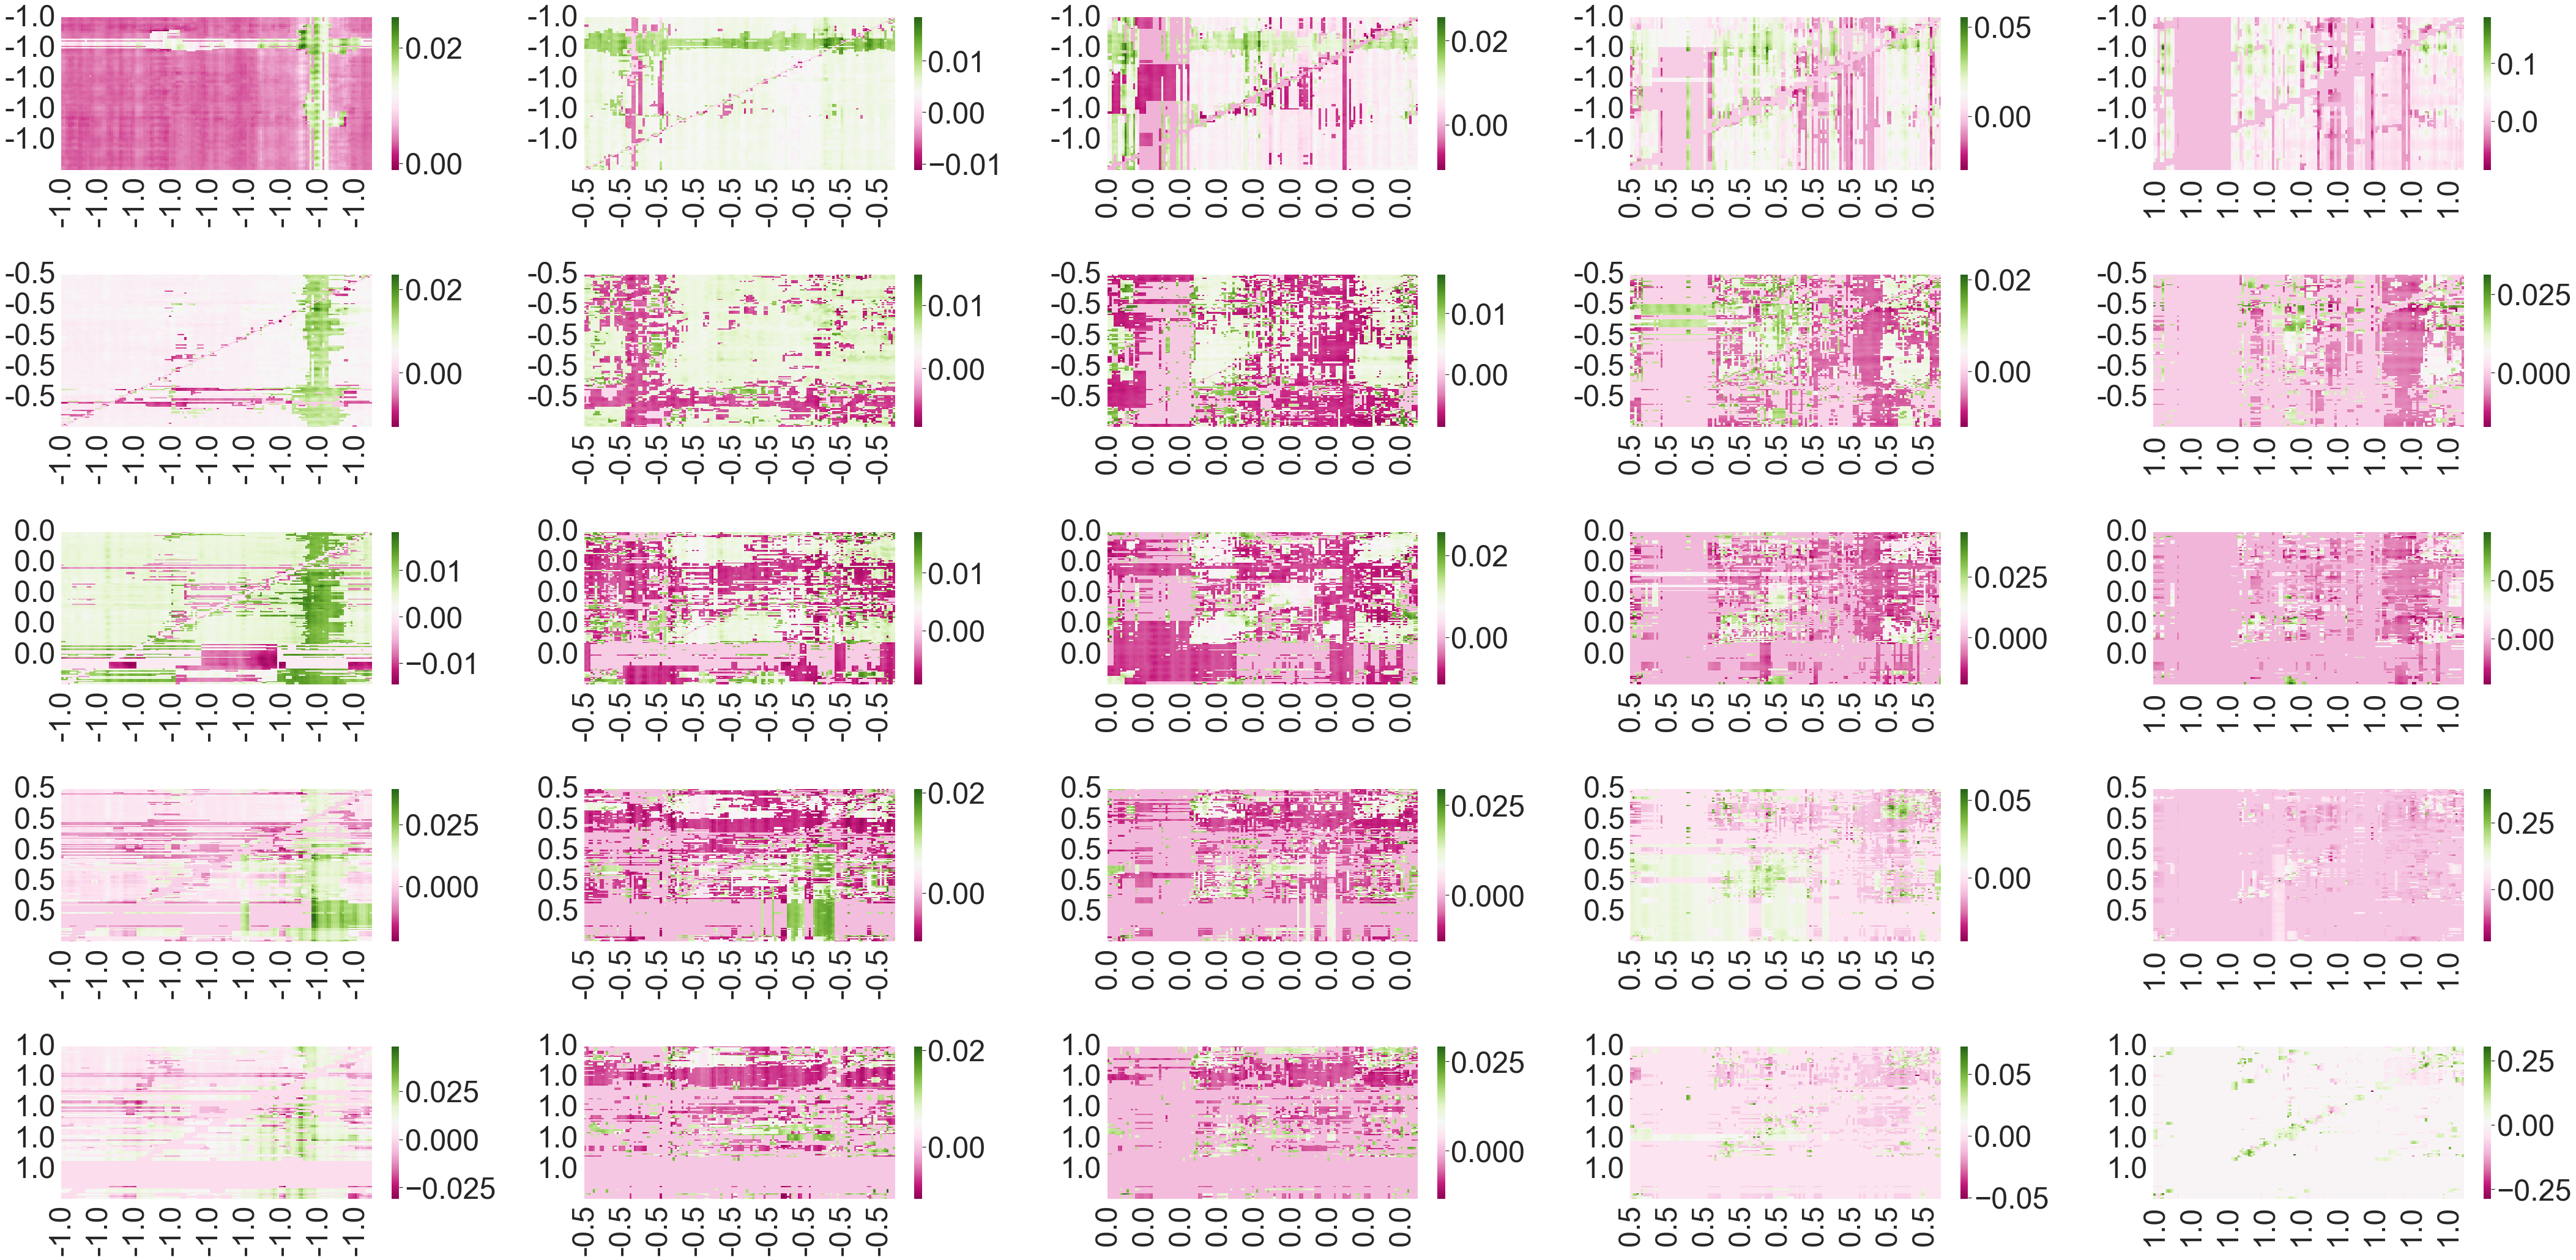

lable: 2


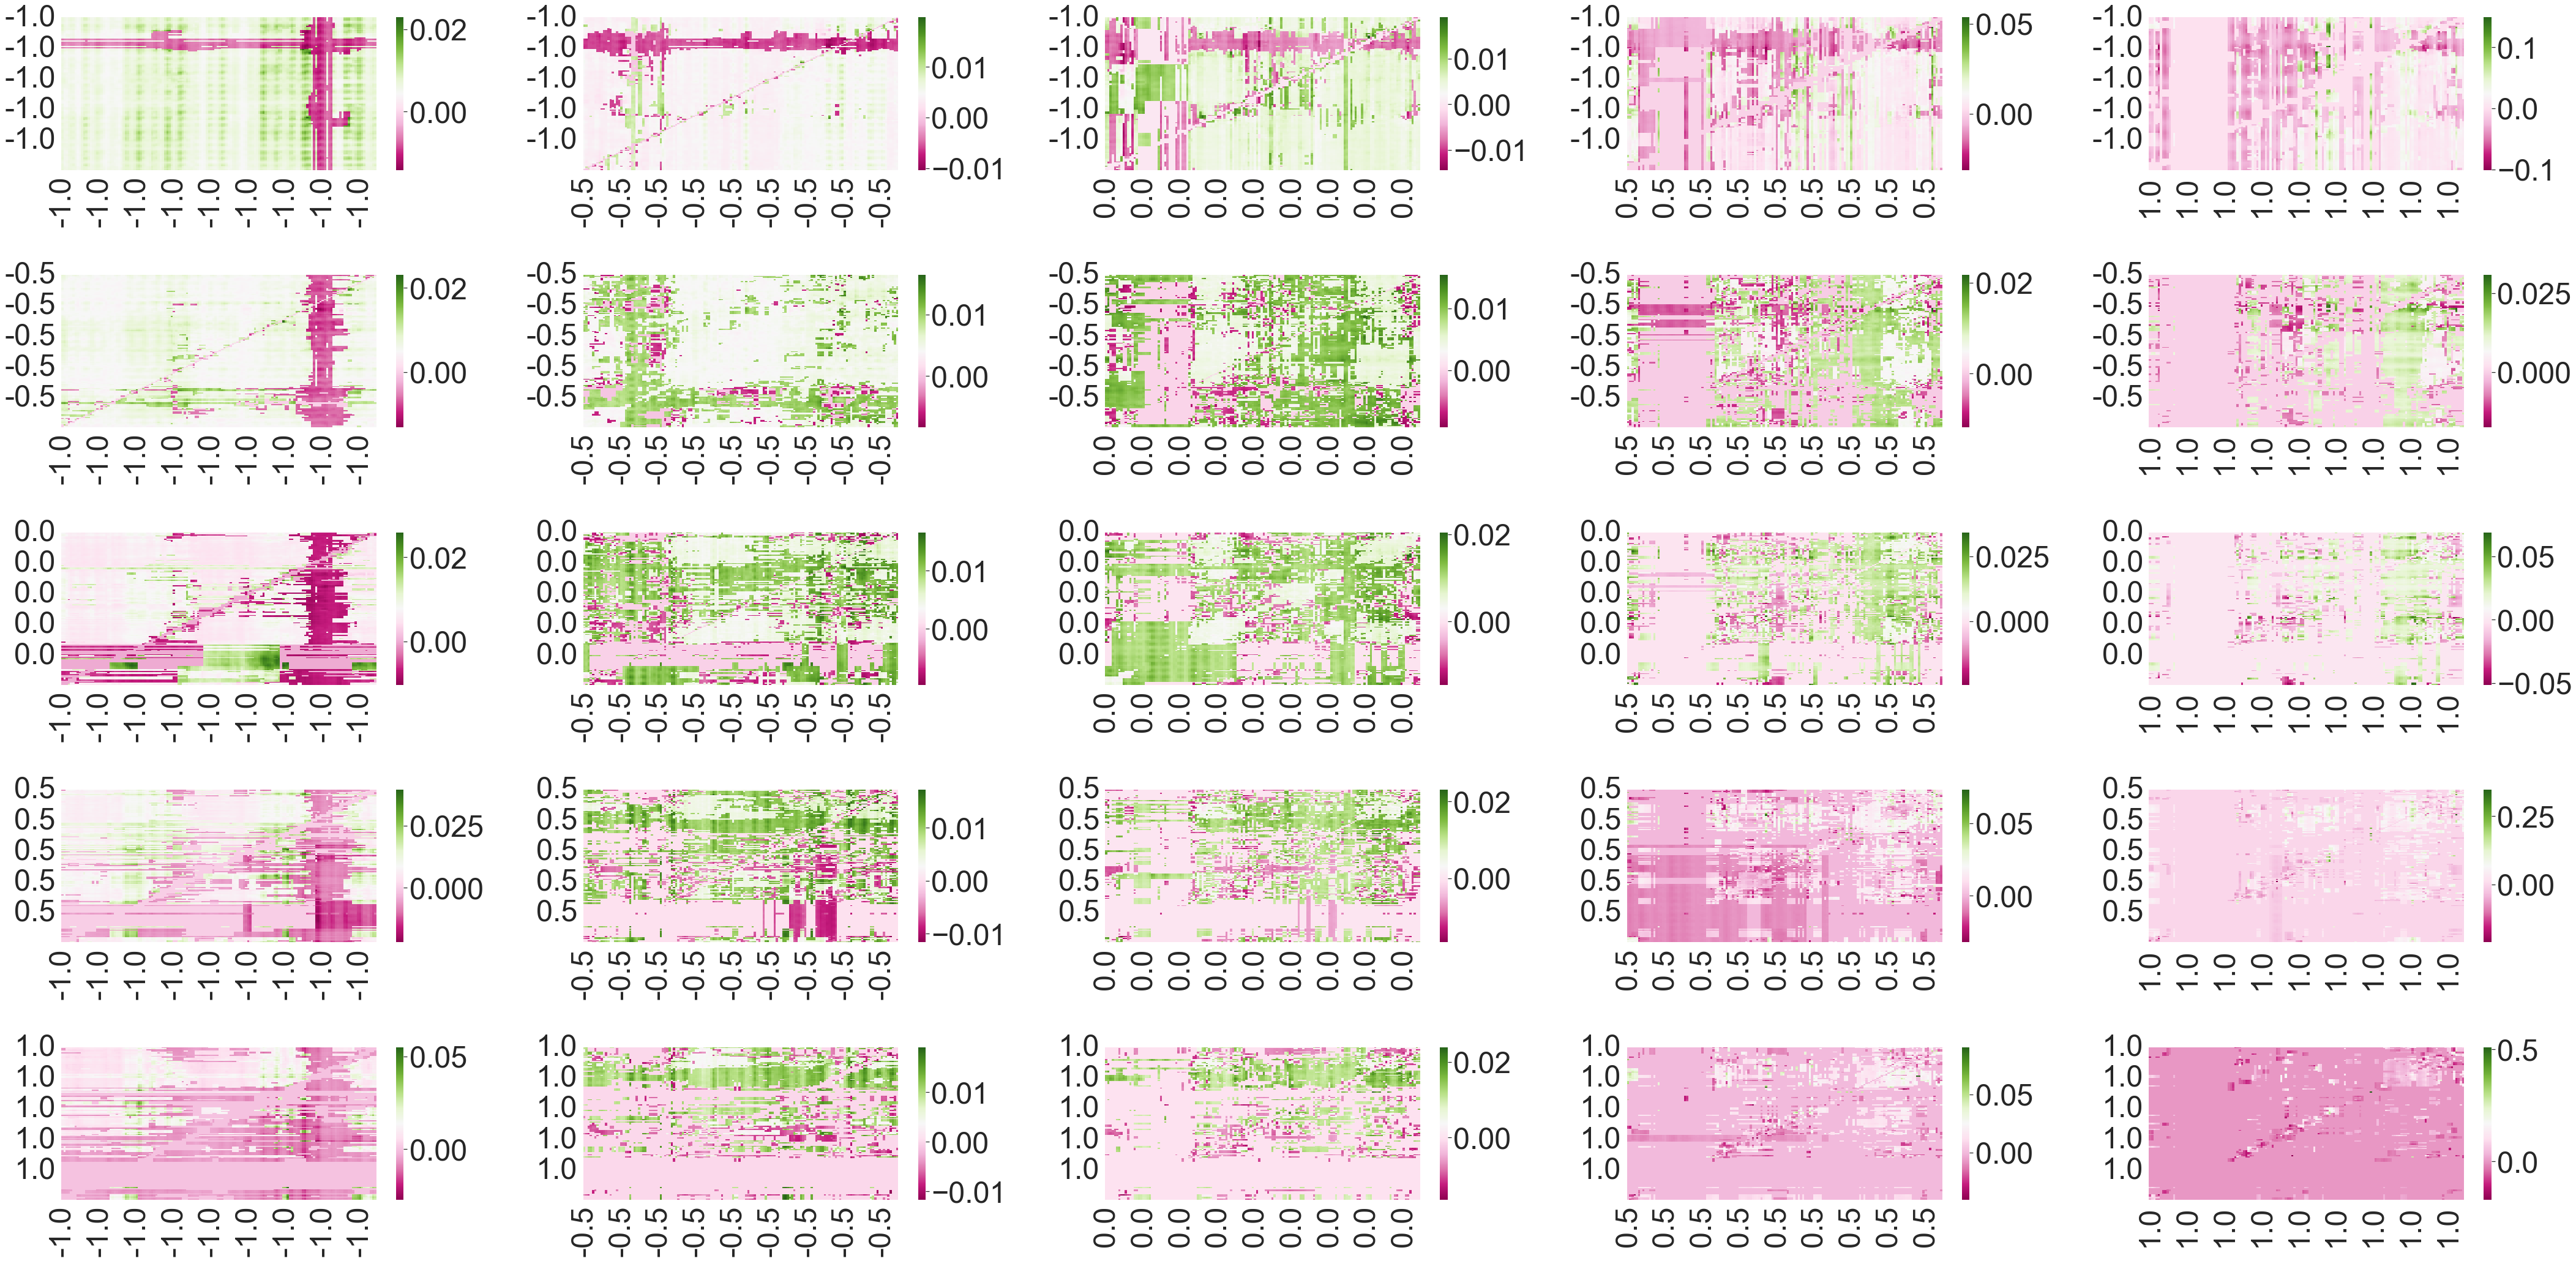

ValueError: Shape of passed values is (144, 144), indices imply (0, 0)

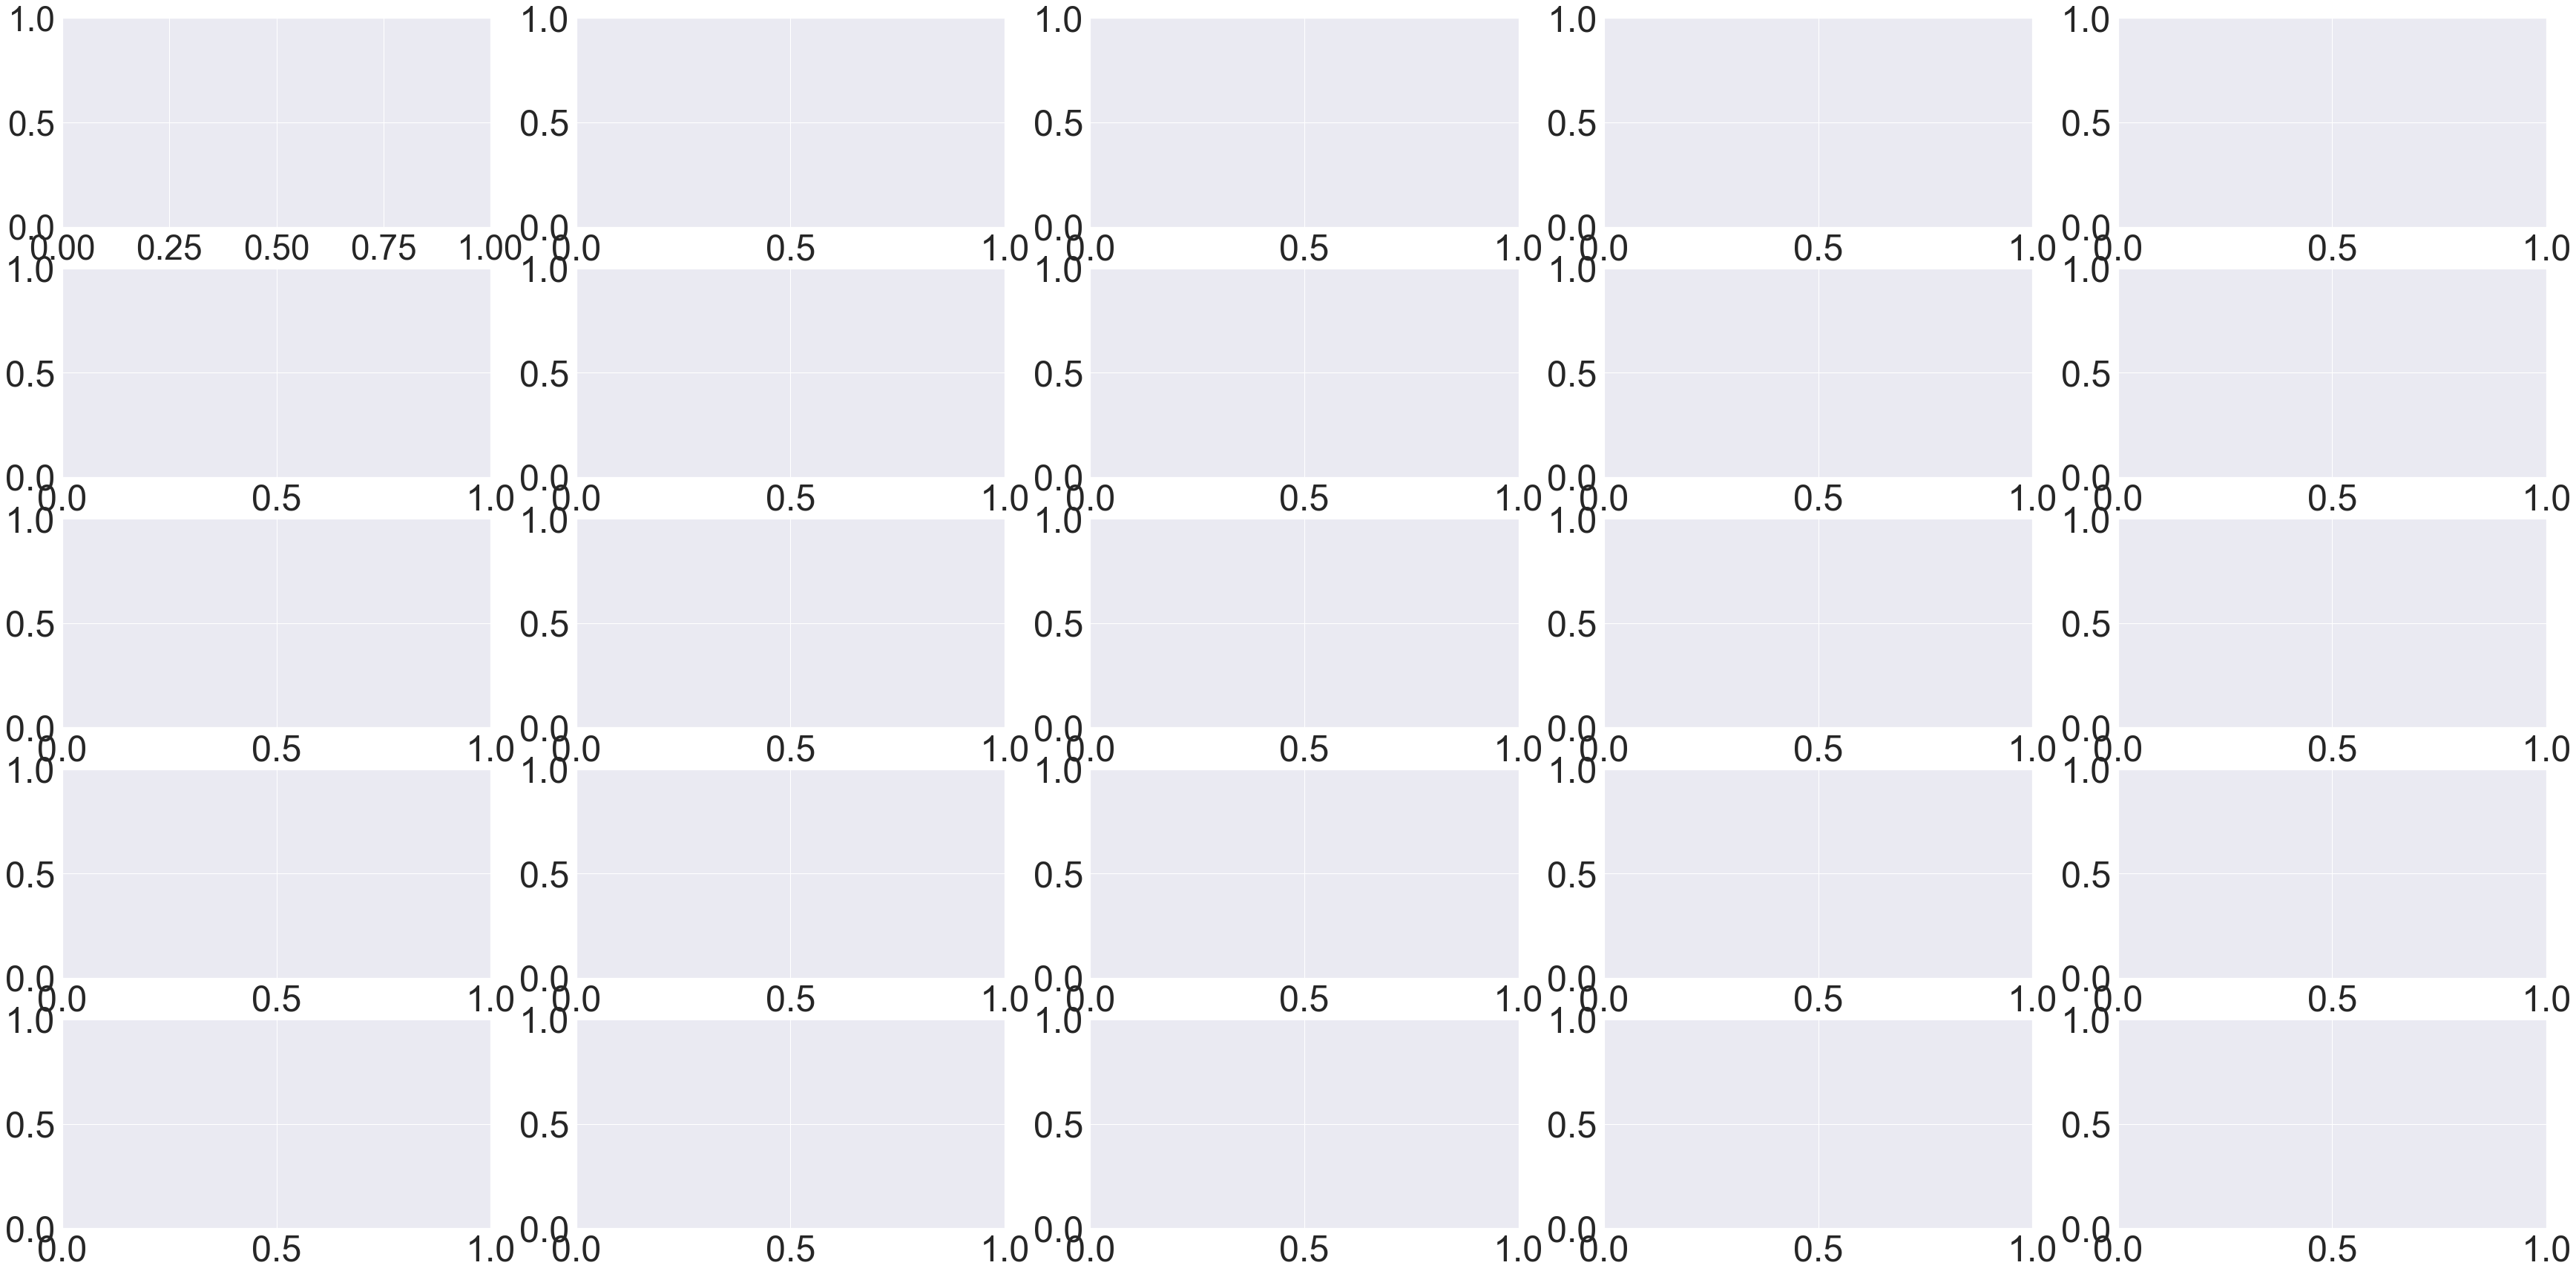

In [48]:
#TODO from local to global transition das OR betrachten? Wie sieht das aus!
#TODO schauen wenn ich nur genau eine klasse lerne? (derzeit ist vll das Problem, dass die Klassen sich zu stark überschneiden?)
#TODO mal die max werte berechnen und local werte berechnen?

#TODO wie vorher schon in der excel datei gedacht, anders dinge zusammen rechnen?
#TODO Dinge zusammenrechnen wie ich es tun würde bei der FCAM? Um so Positionswerte zu bestimmen? Oder im Avg vll?
#valuesA = [-1, -0.5, 0, 0.5, 1]

#which combination to display
combination = 'ravg'  #['sum', 'ravg']
sns.set(font_scale=4.4)

labelSize = num_of_classes

for lable in range(1,3):
    print('lable: '+ str(lable))
    
    fig, ax = plt.subplots(figsize=(60,30), nrows=len(valuesA), ncols=len(valuesA))

    for rowI, row in enumerate(ax):
        for colI, col in enumerate(row):
            #ax[rowI][colI].tick_params(labelsize=46)
            fromV = float(valuesA[rowI])
            toV = float(valuesA[colI])
            
            if combination == 'sum':
                data_att = rMS[lable][fromV][toV]
            elif combination == 'ravg':
                data_att = rMA[lable][fromV][toV]
            data_att = np.flip(np.array(data_att), axis=0)

            data_wordF = [fromV] * len(rMA[lable][fromV][toV])
            data_wordT = [toV] * len(rMA[lable][fromV][toV])
            d = pd.DataFrame(data = data_att,index = data_wordF, columns=data_wordT)
            #s = sns.heatmap(d, vmin=-0.015, vmax=0.015, ax=col, cmap="PiYG", annot=False) #OrRd
            s = sns.heatmap(d, ax=col, cmap="PiYG", annot=False) #OrRd
            #s = sns.heatmap(d, vmin=0, ax=col, cmap="OrRd", annot=True)
            #s.figure.axes[-1].set_ylabel('Accuracy %', size=96)
            
    fig.tight_layout()
    #plt.savefig('./Bilder/penalty/Class' + str(lable) +'fullmatrixR.png', dpi = 100)
    plt.show()
    
    
    
    
#diff
fig, ax = plt.subplots(figsize=(60,30), nrows=len(valuesA), ncols=len(valuesA))


lable = 3
class1Dif = 1
class2Dif = 2
for rowI, row in enumerate(ax):
    for colI, col in enumerate(row):
        ax[rowI][colI].tick_params(labelsize=46)
        fromV = valuesA[rowI]
        toV = valuesA[colI]

        if combination == 'sum':
            data_att = rMS[class1Dif][fromV][toV] - rMS[class2Dif][fromV][toV]
        elif combination == 'ravg':
            data_att = rMA[class1Dif][fromV][toV] - rMA[class2Dif][fromV][toV]
        data_att = np.flip(np.array(data_att), axis=0)
        data_wordF = [fromV] * len(rMA[lable][fromV][toV])
        data_wordT = [toV] * len(rMA[lable][fromV][toV])
        d = pd.DataFrame(data = data_att,index = data_wordF, columns=data_wordT)
        sns.heatmap(d, min=0, ax=col, cmap="OrRd")

fig.tight_layout()
#plt.savefig('./Bilder/penalty/Class' + str(lable) +'fullmatrix.png', dpi = 300)
plt.show()

In [45]:
rMA[3]

defaultdict(<function modules.GCRPlus.getddList()>,
            {-1.0: defaultdict(list, {-1.0: []})})

Plot CRCAM

1


NameError: name 'fromV' is not defined

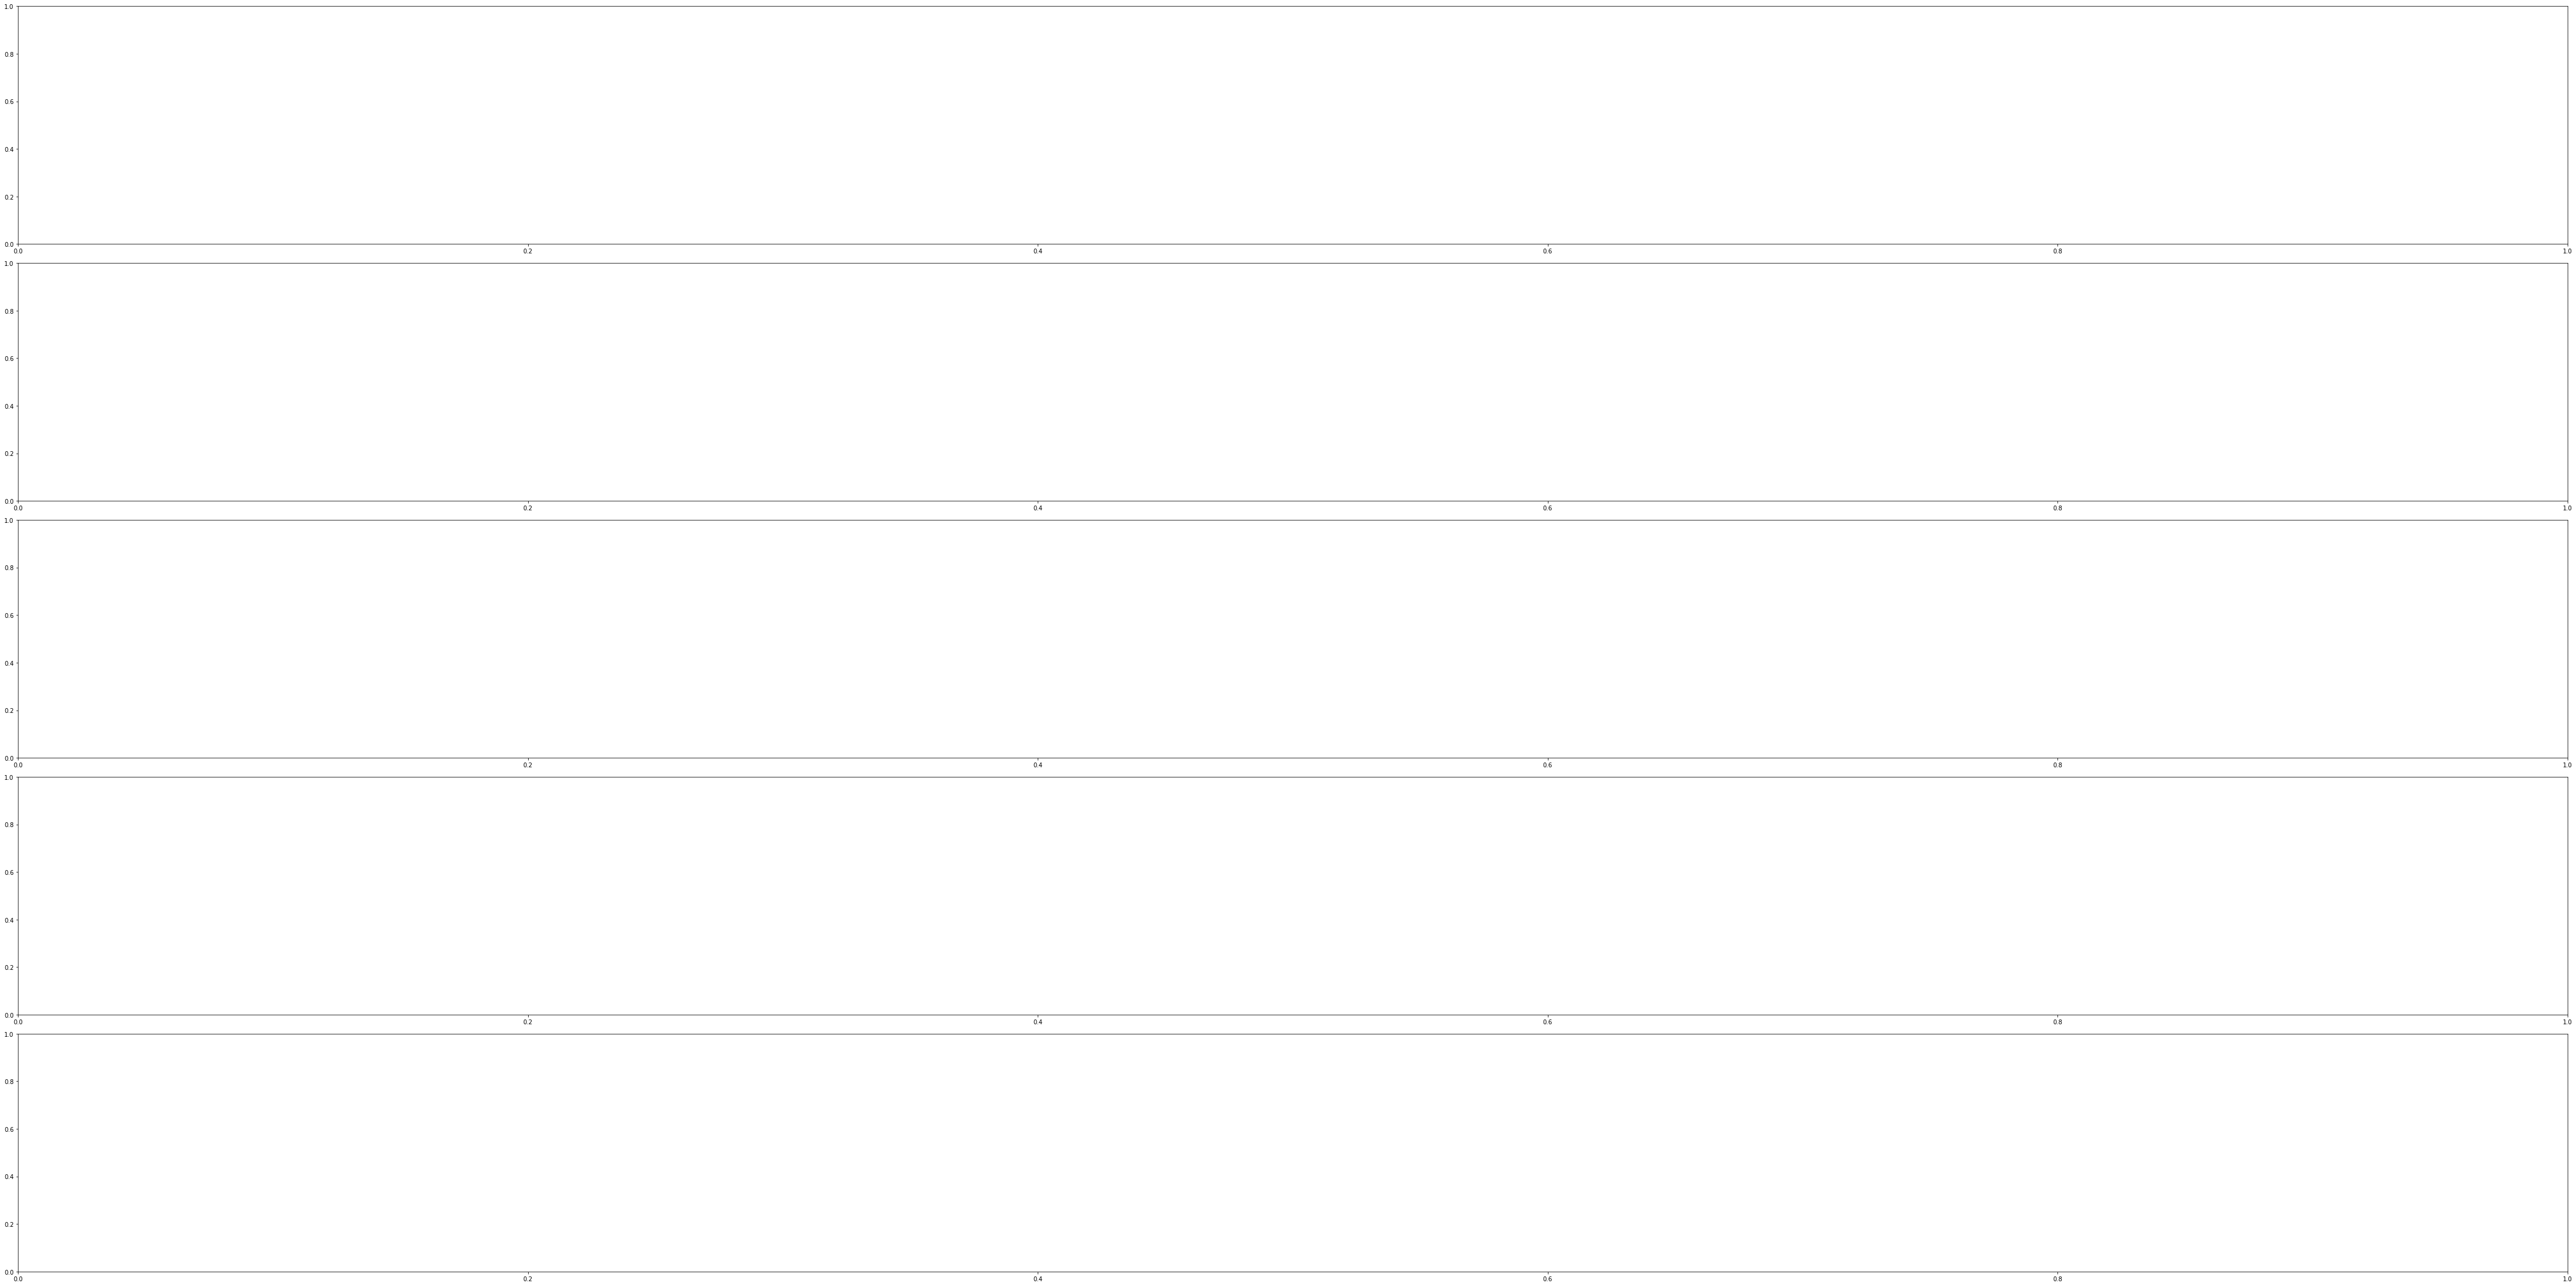

In [28]:
#valuesA = [-1, -0.5, 0, 0.5, 1]

combination = 'xAvg'  #['x', 'xAvg']


labelSize = num_of_classes
for lable in range(1,labelSize+1):

    print(lable)
    fig, ax = plt.subplots(figsize=(60,30), nrows=len(valuesA), ncols=1)
    fig.tight_layout()

    for rowI, row in enumerate(reversed(ax)):
                
            toV = valuesA[rowI]
            att_sum = rMA[lable][combination][toV]
            att_sum = np.flip(np.array(att_sum), axis=0)
            data_att = att_sum
            data_wordF = ['x'] * len(rMA[lable][fromV][toV])
            data_wordT = [toV] * len(rMA[lable][fromV][toV])
            d = pd.DataFrame(data = data_att,index = data_wordF, columns=data_wordT)

            #sns.heatmap(d, vmin=-0.26, vmax=0.16, ax=row, cmap="PiYG")
            sns.heatmap(d, center=0, ax=row, cmap="PiYG", annot=True)
            plt.tick_params(labelsize=26)
            label_y = row.get_yticklabels()
            plt.setp(label_y, rotation=360, horizontalalignment='right')
            label_x = row.get_xticklabels()
            plt.setp(label_x, rotation=45, horizontalalignment='right')
            
            plt.xlabel("X axis label")
            
    
    
    #plt.savefig('./Bilder/Red/Class' + str(lable) +'colmMatrix.png', dpi = 300)
    plt.show()

Plot GTM

lable: 1


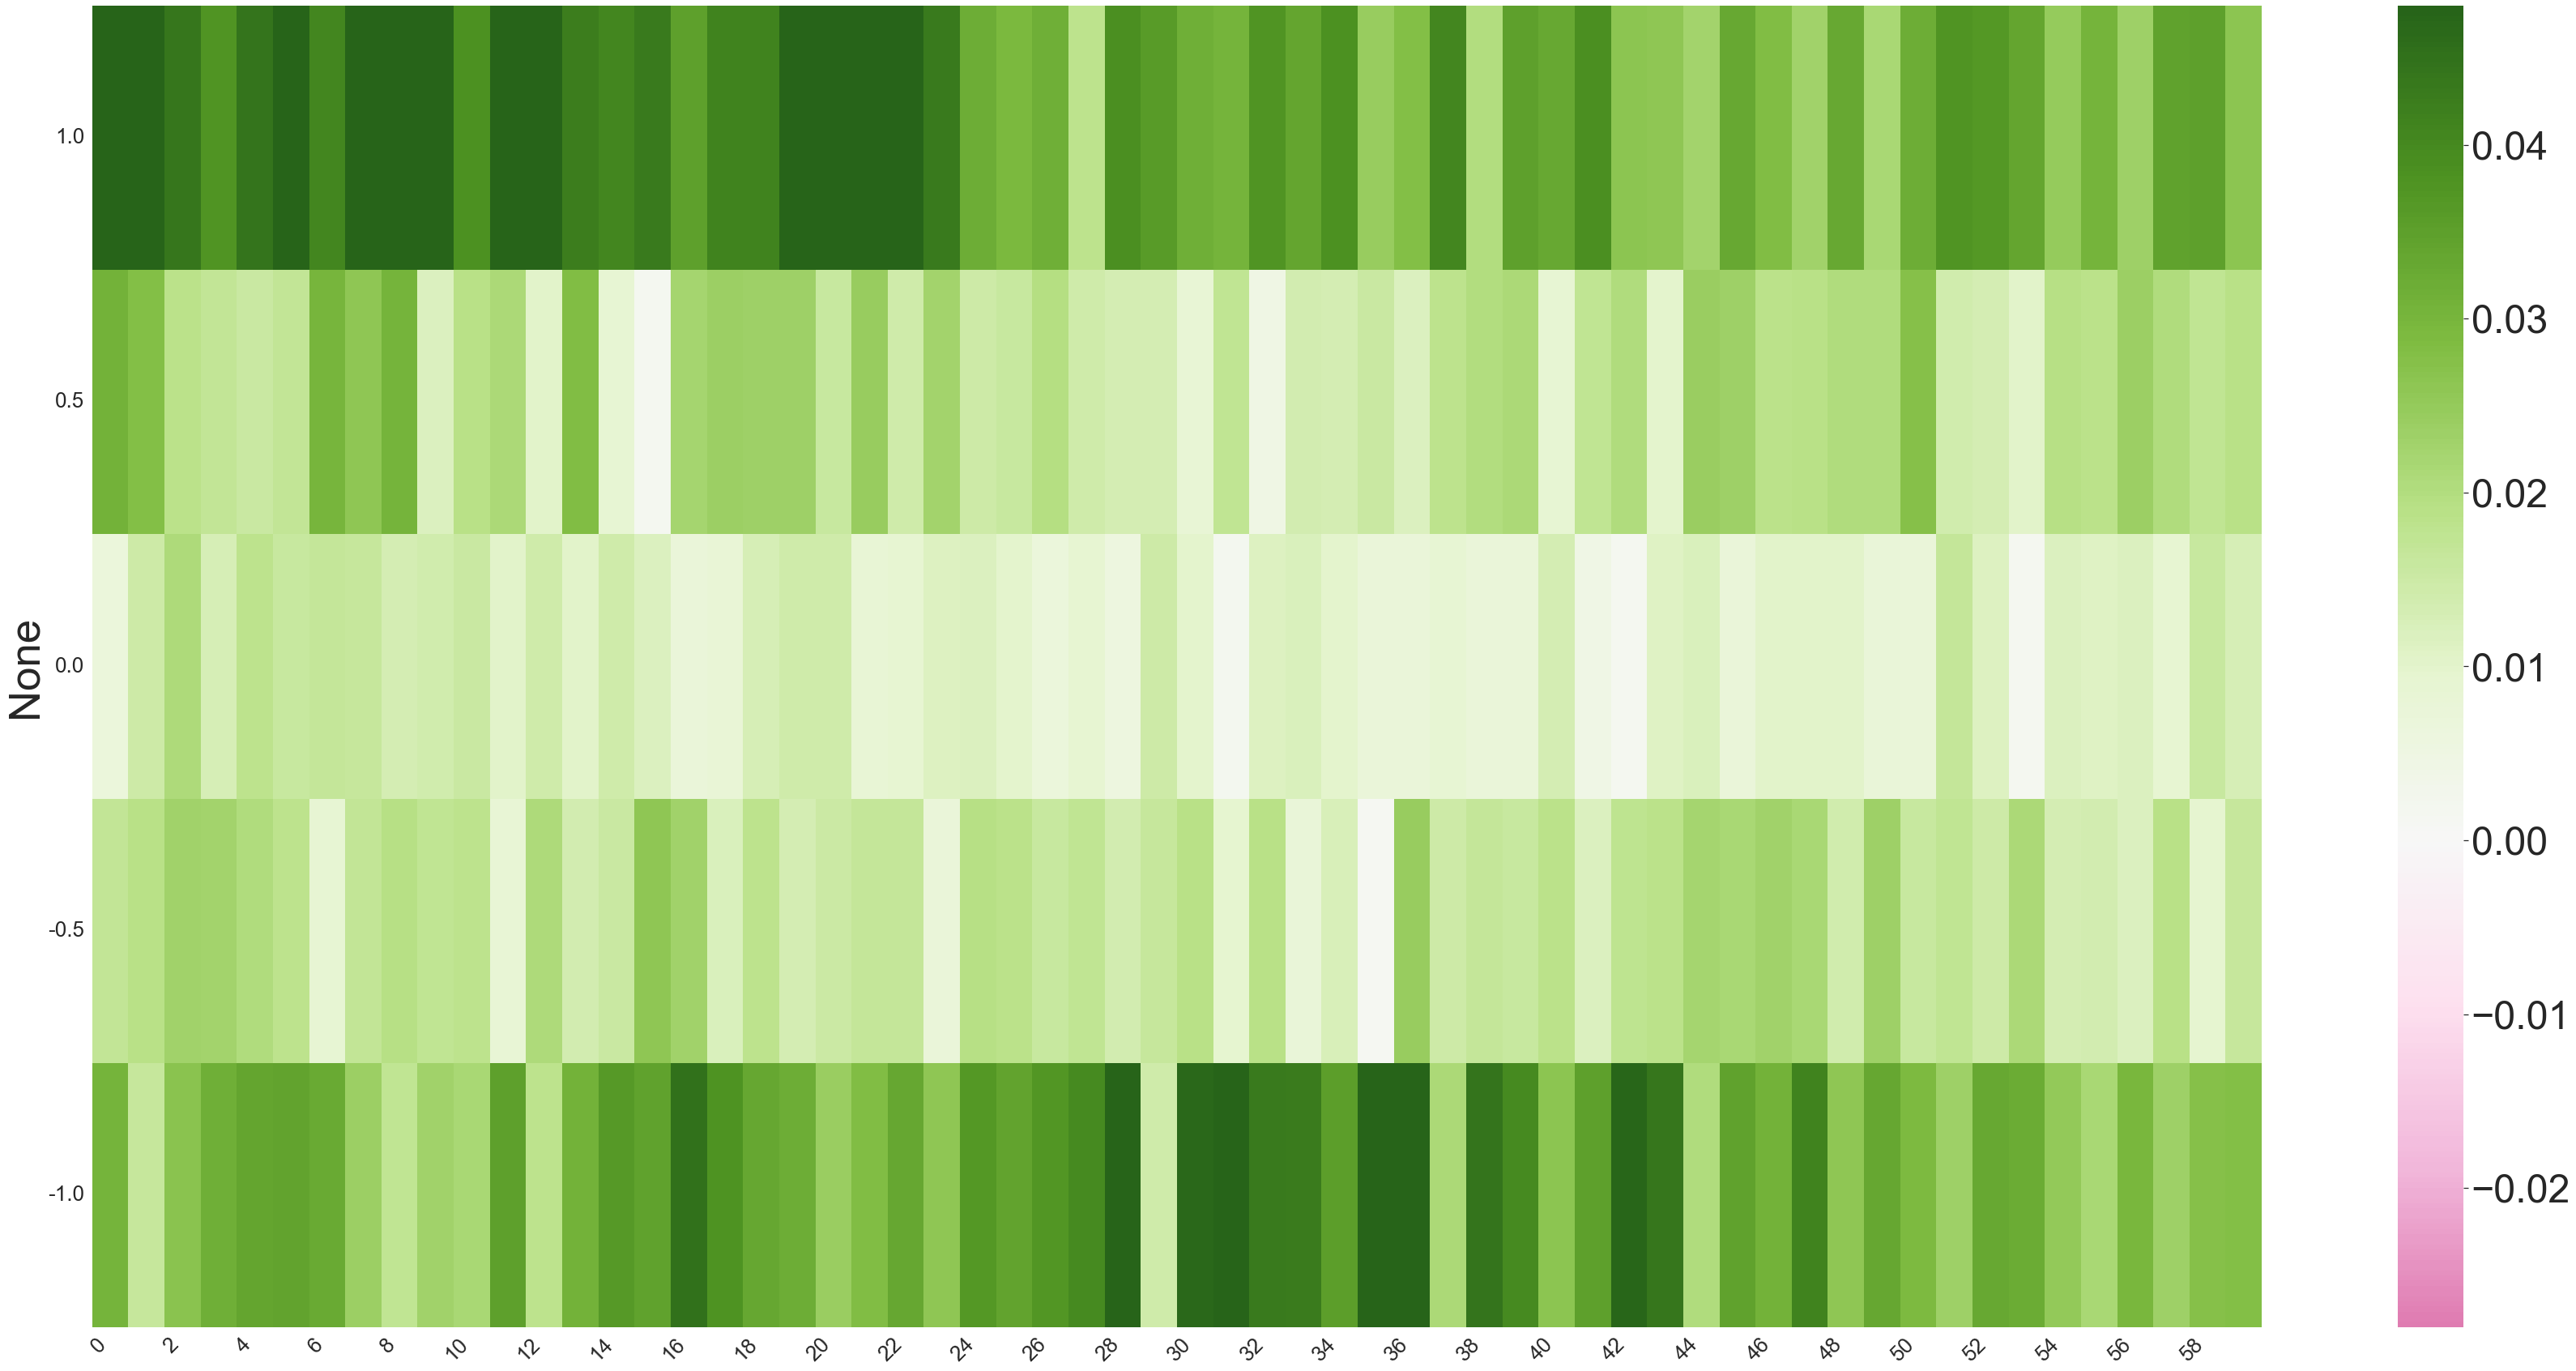

lable: 2


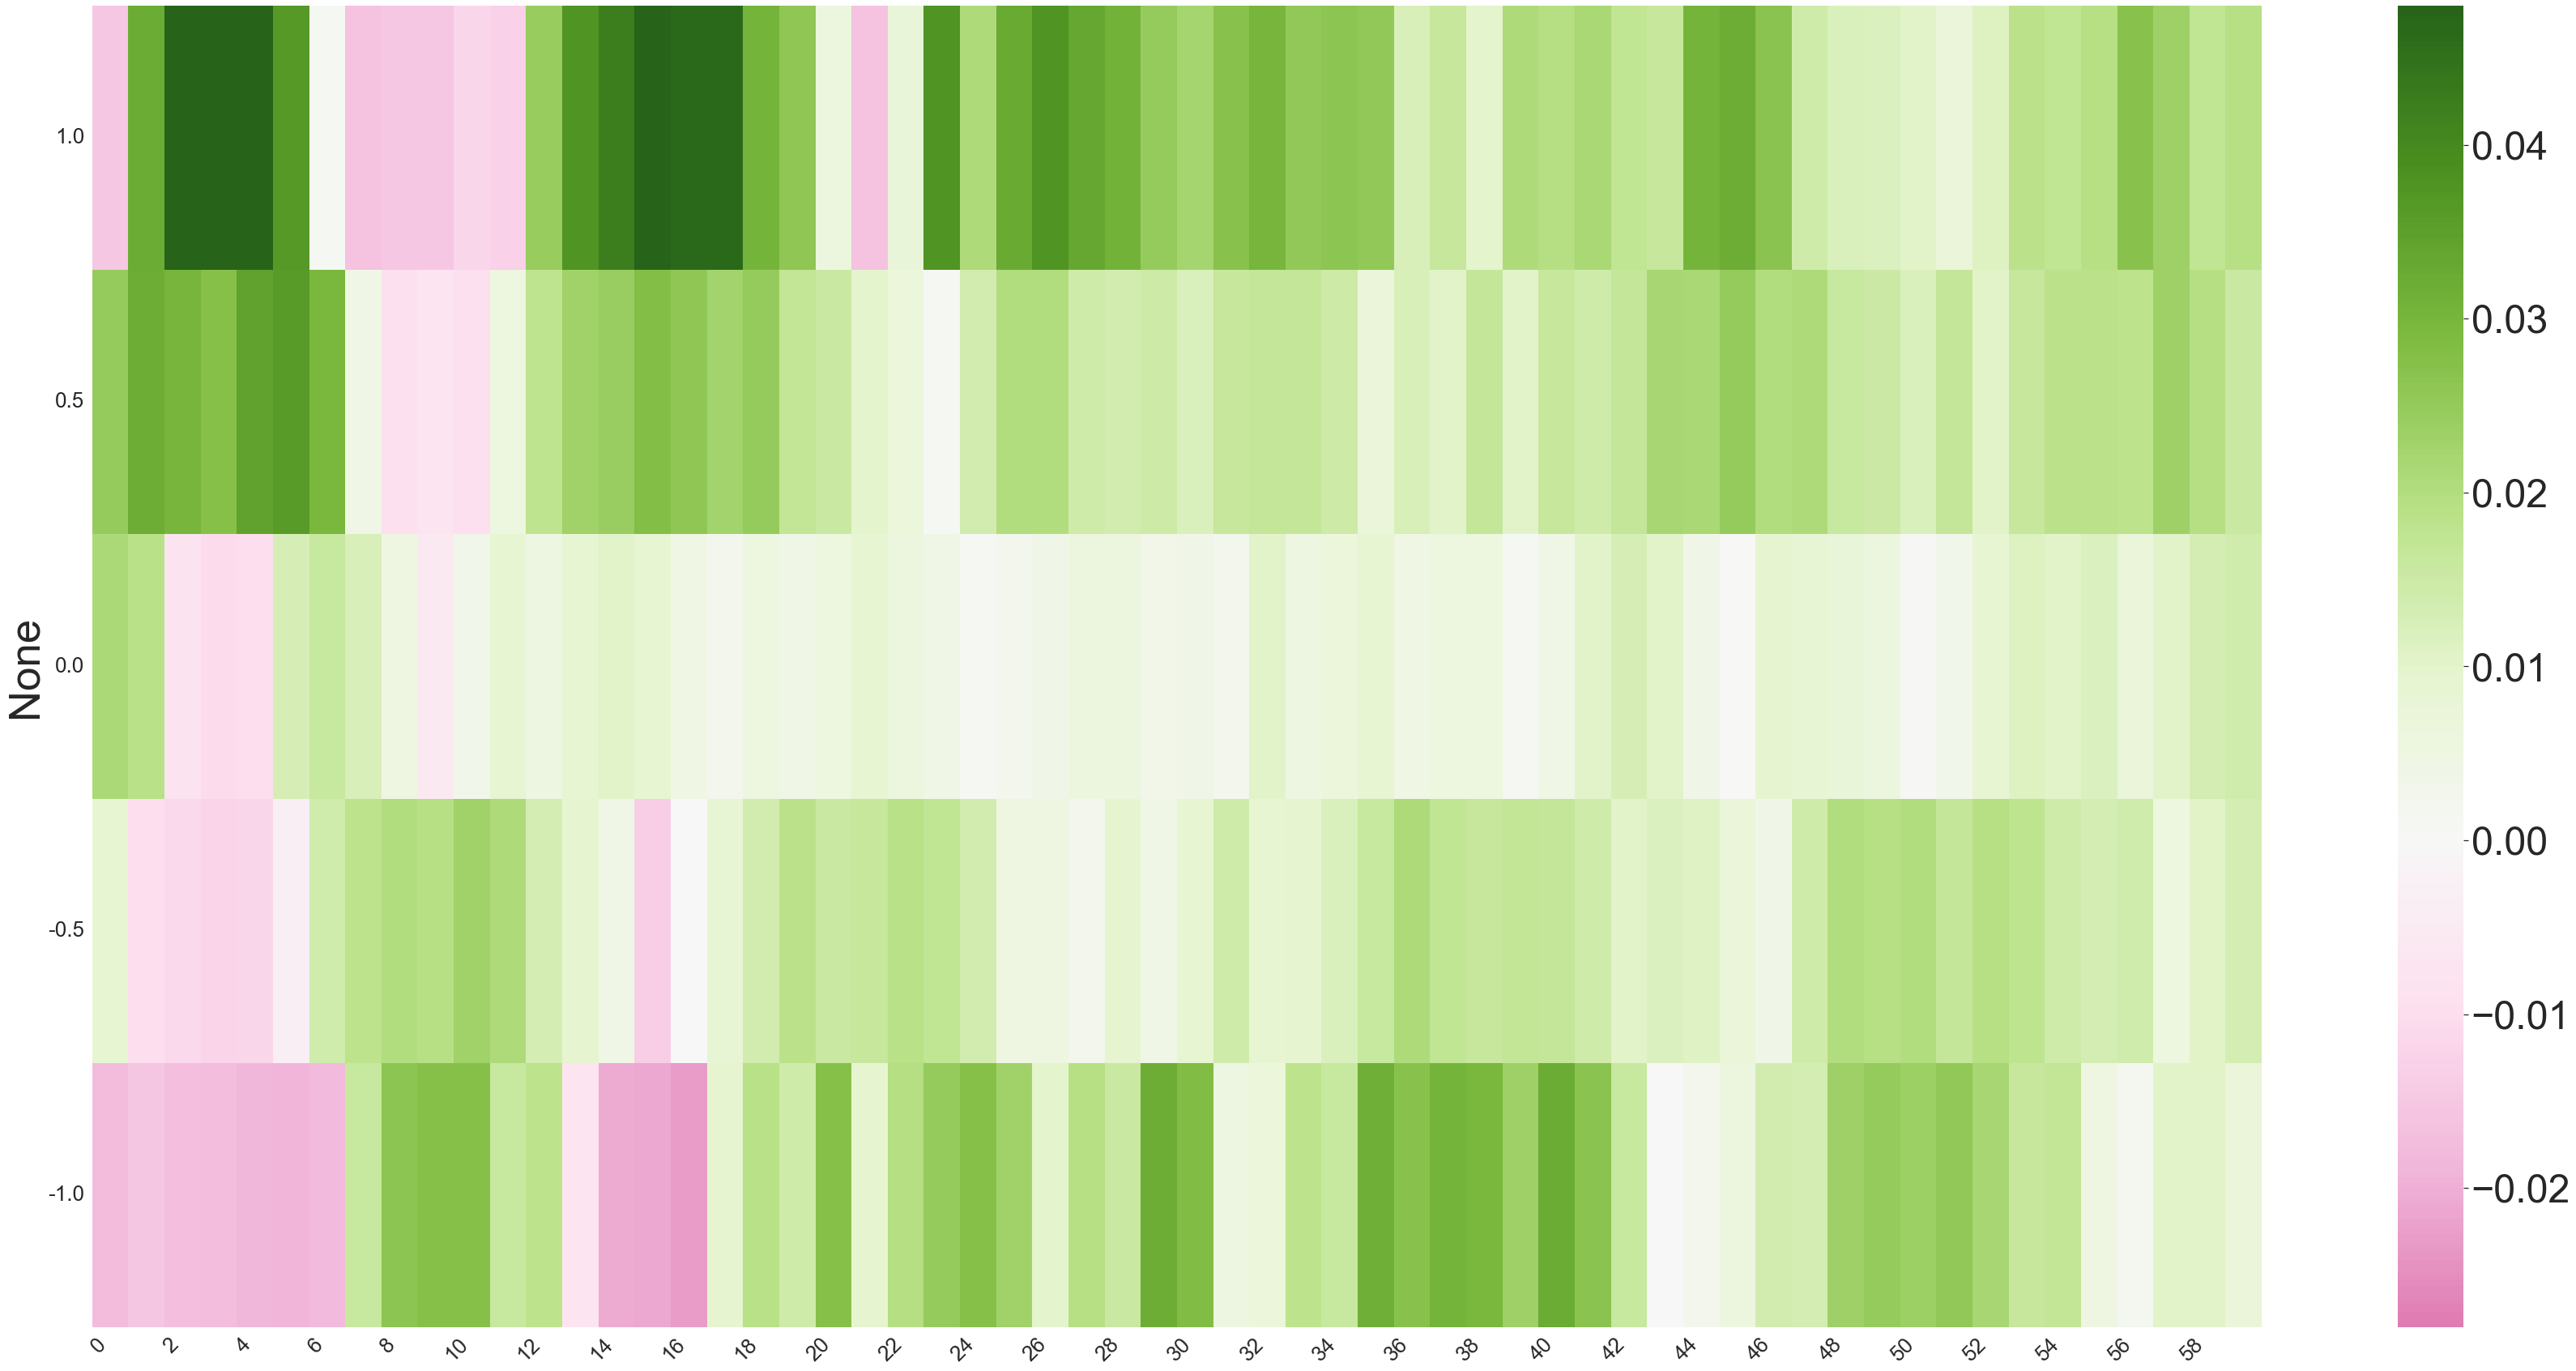

lable: 3


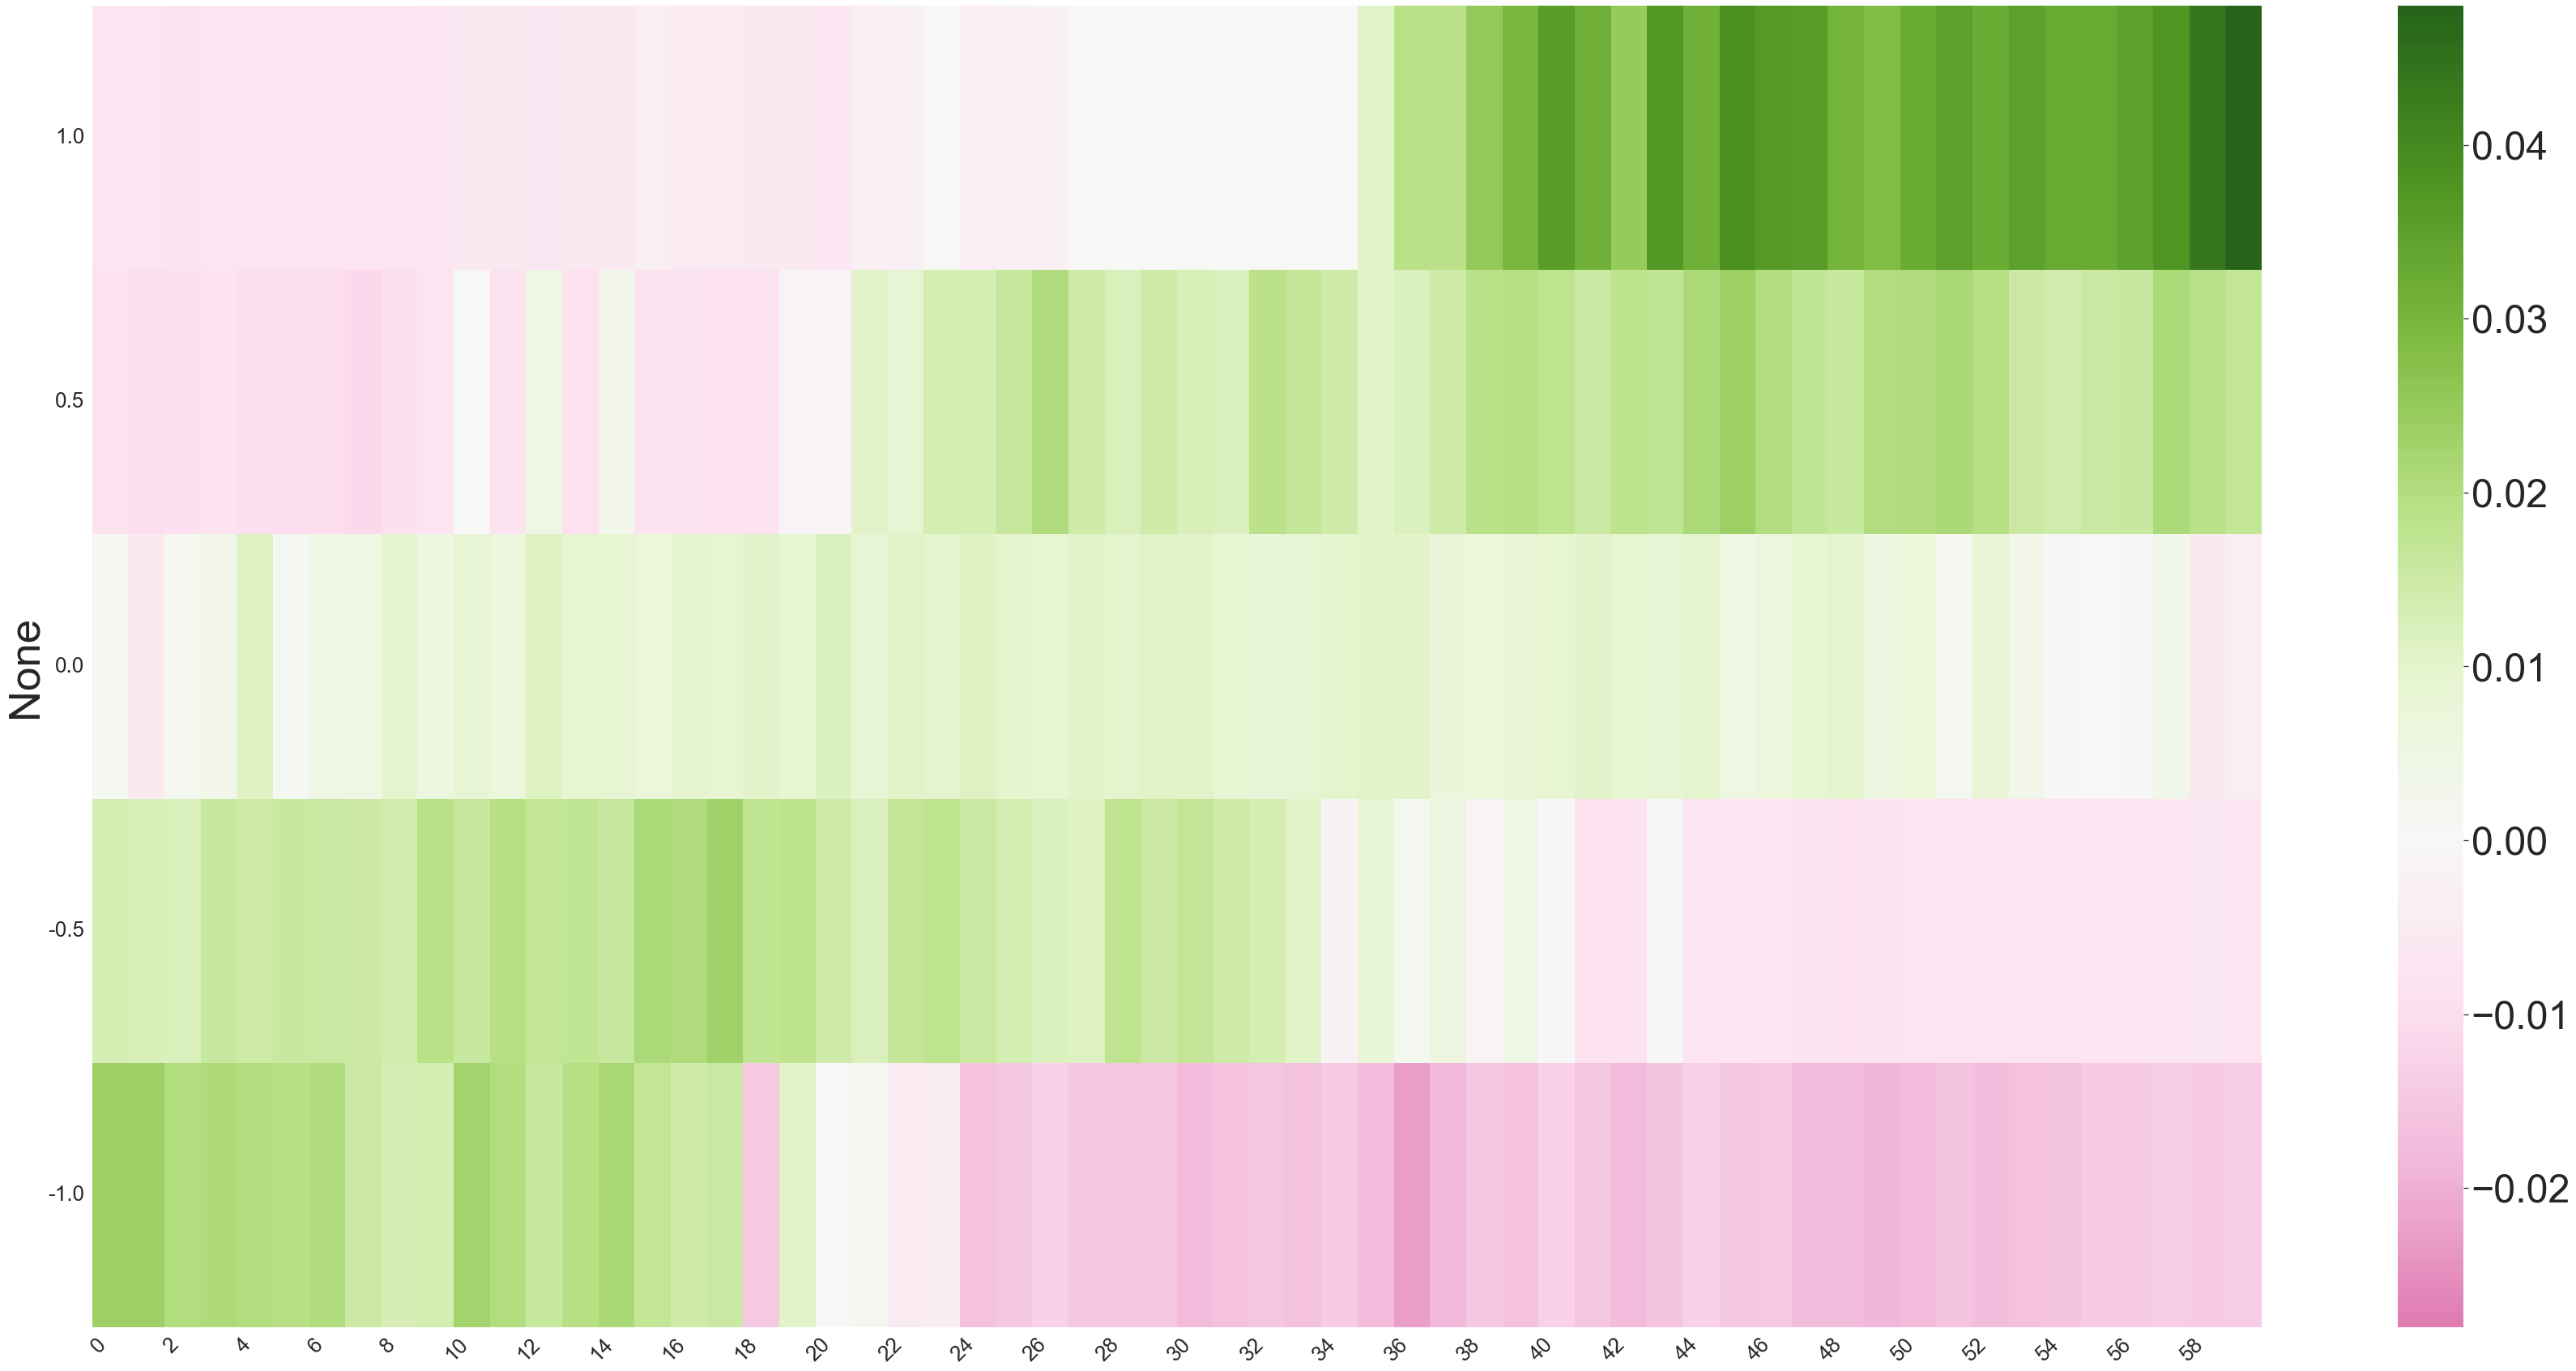

lable: 4


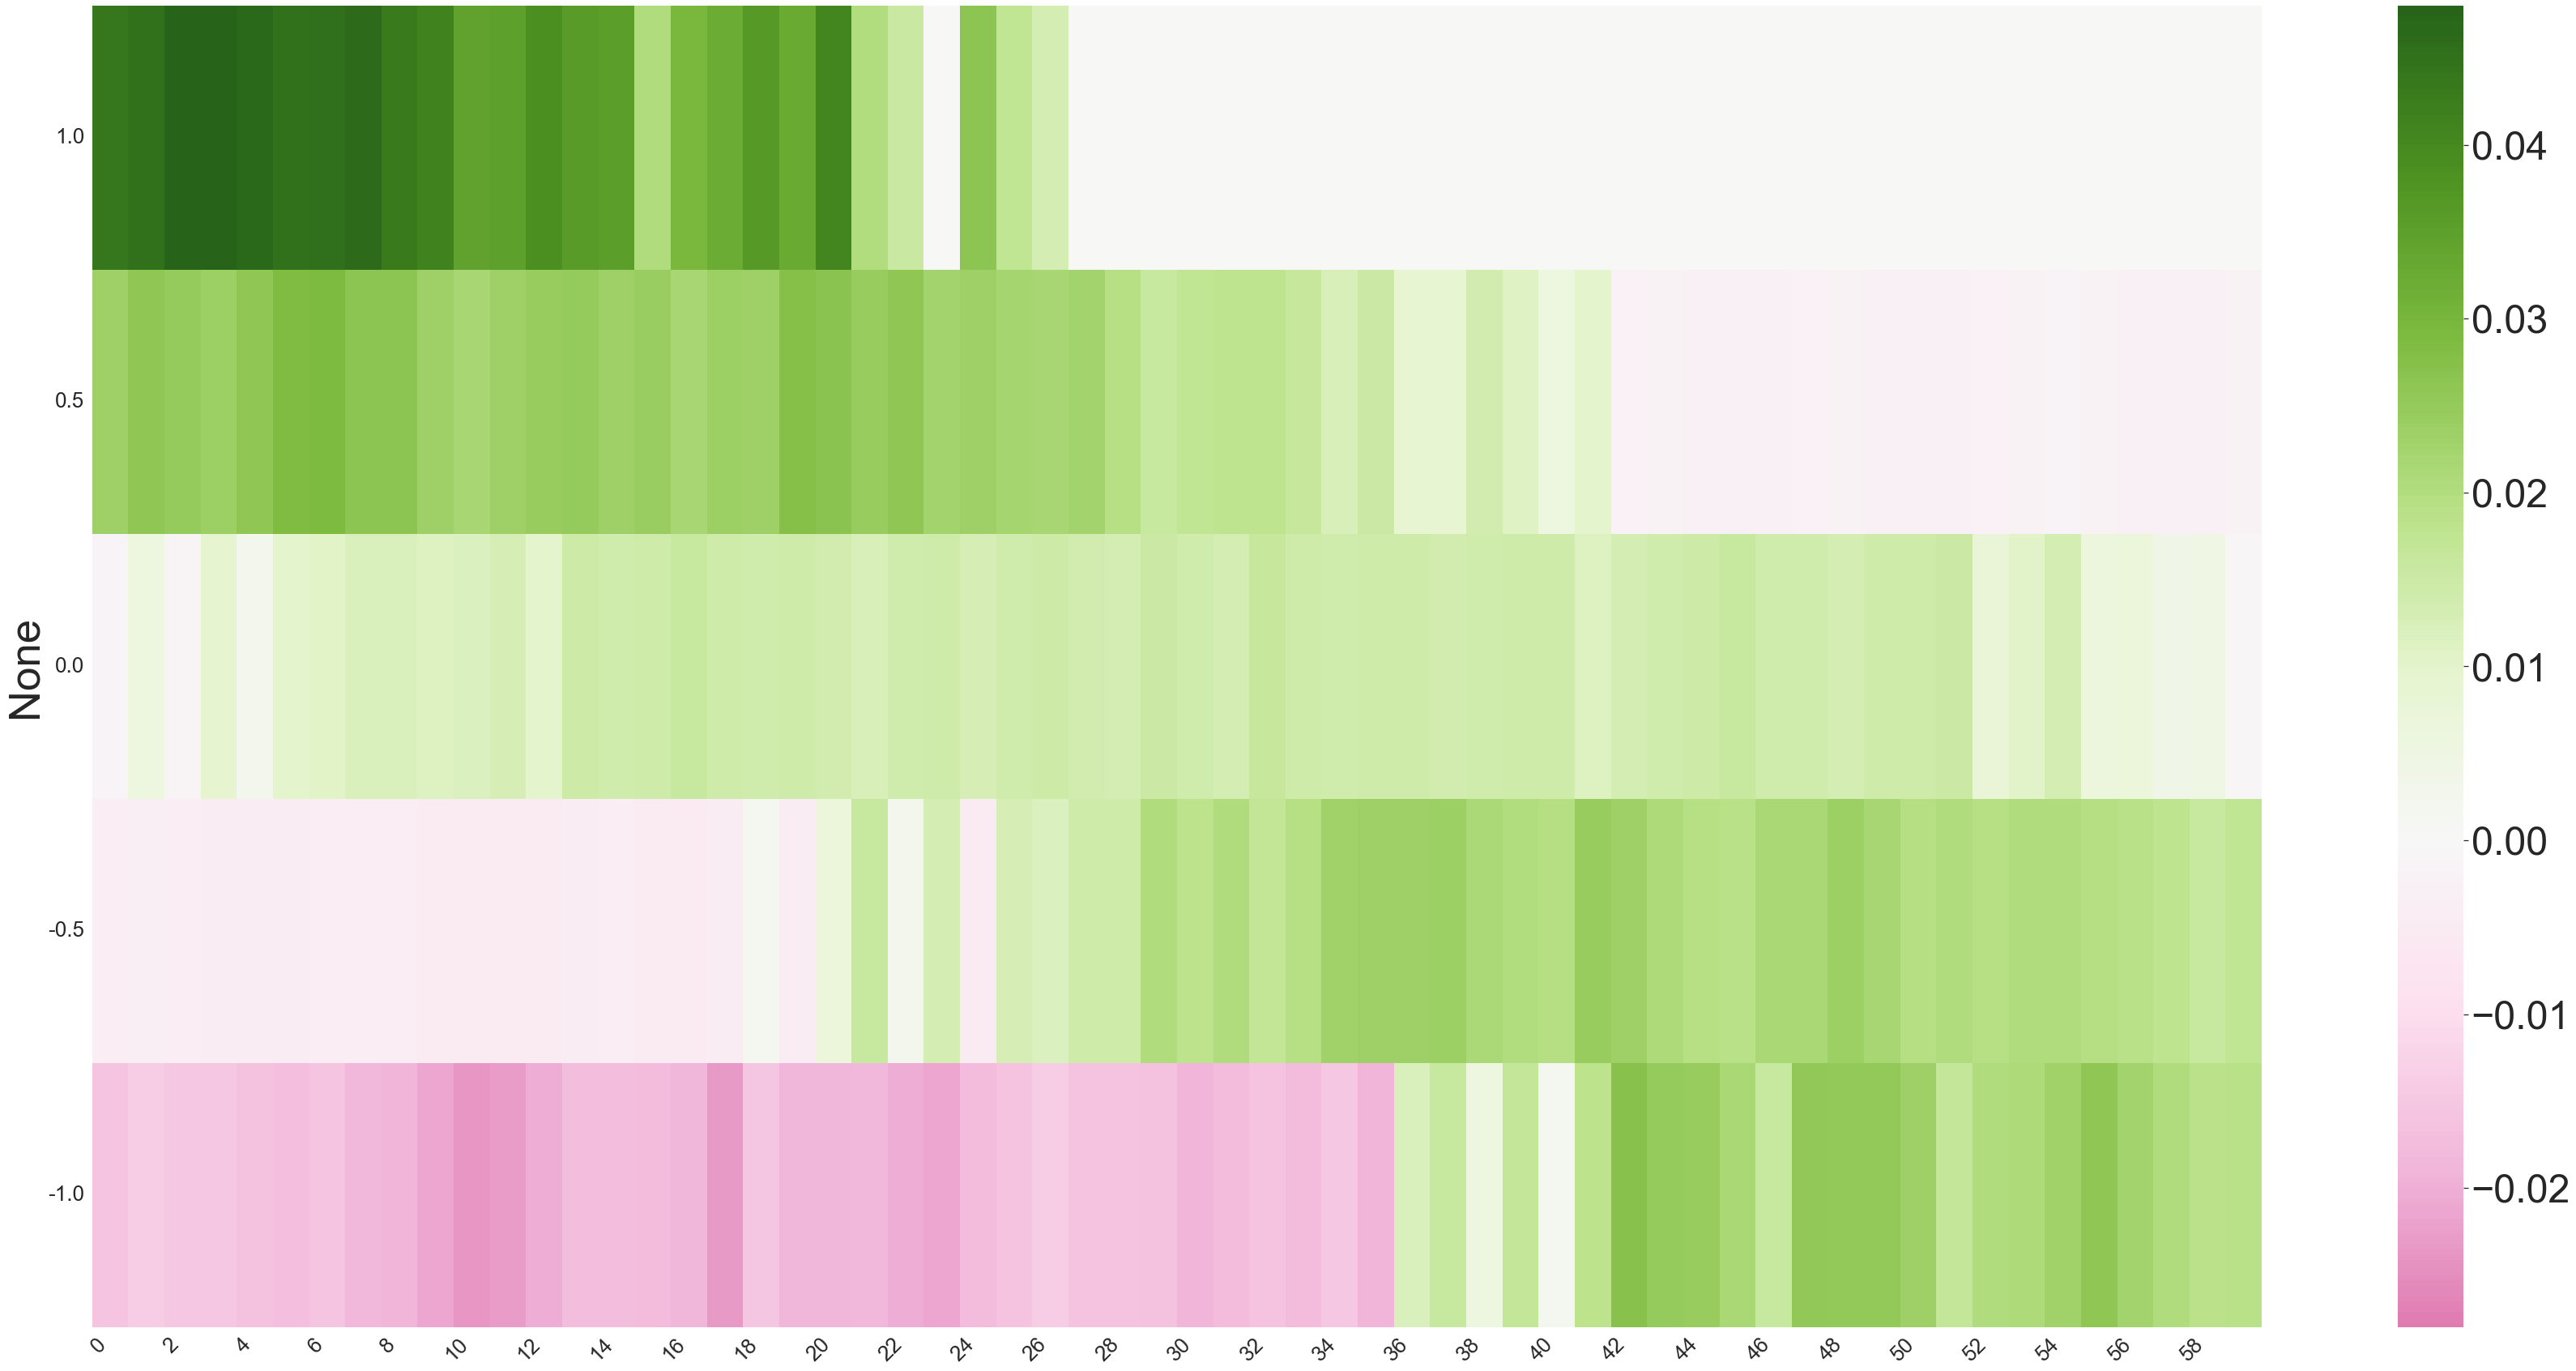

lable: 5


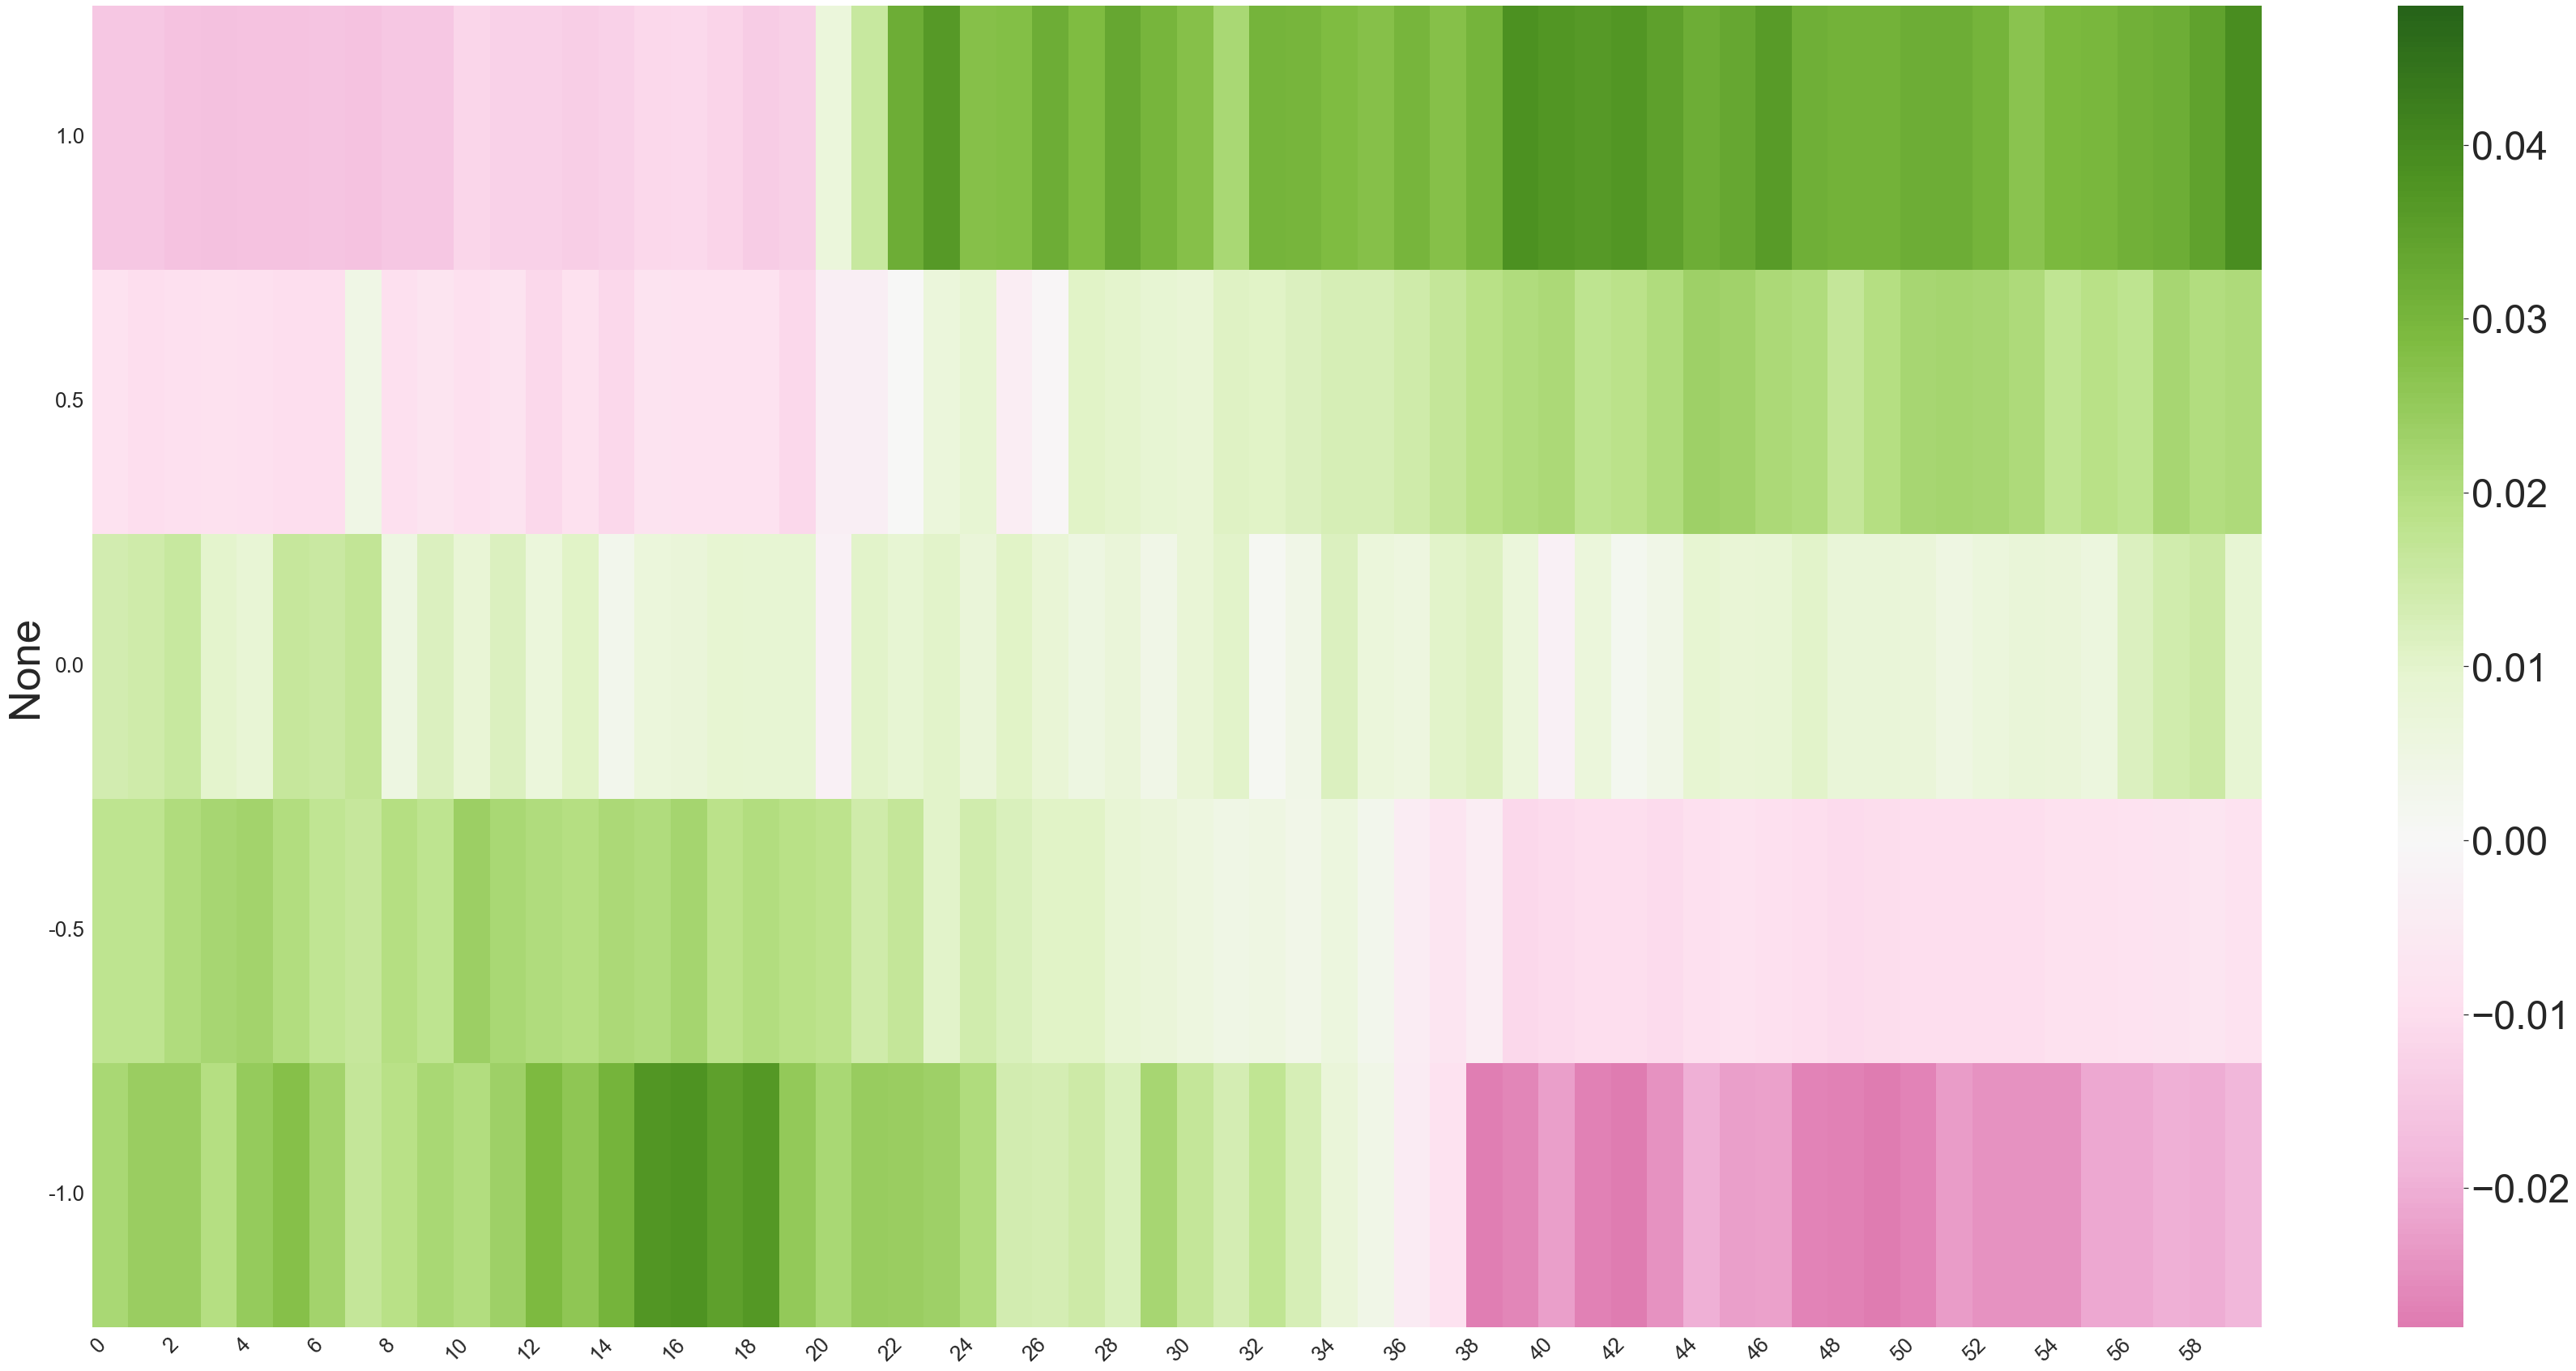

lable: 6


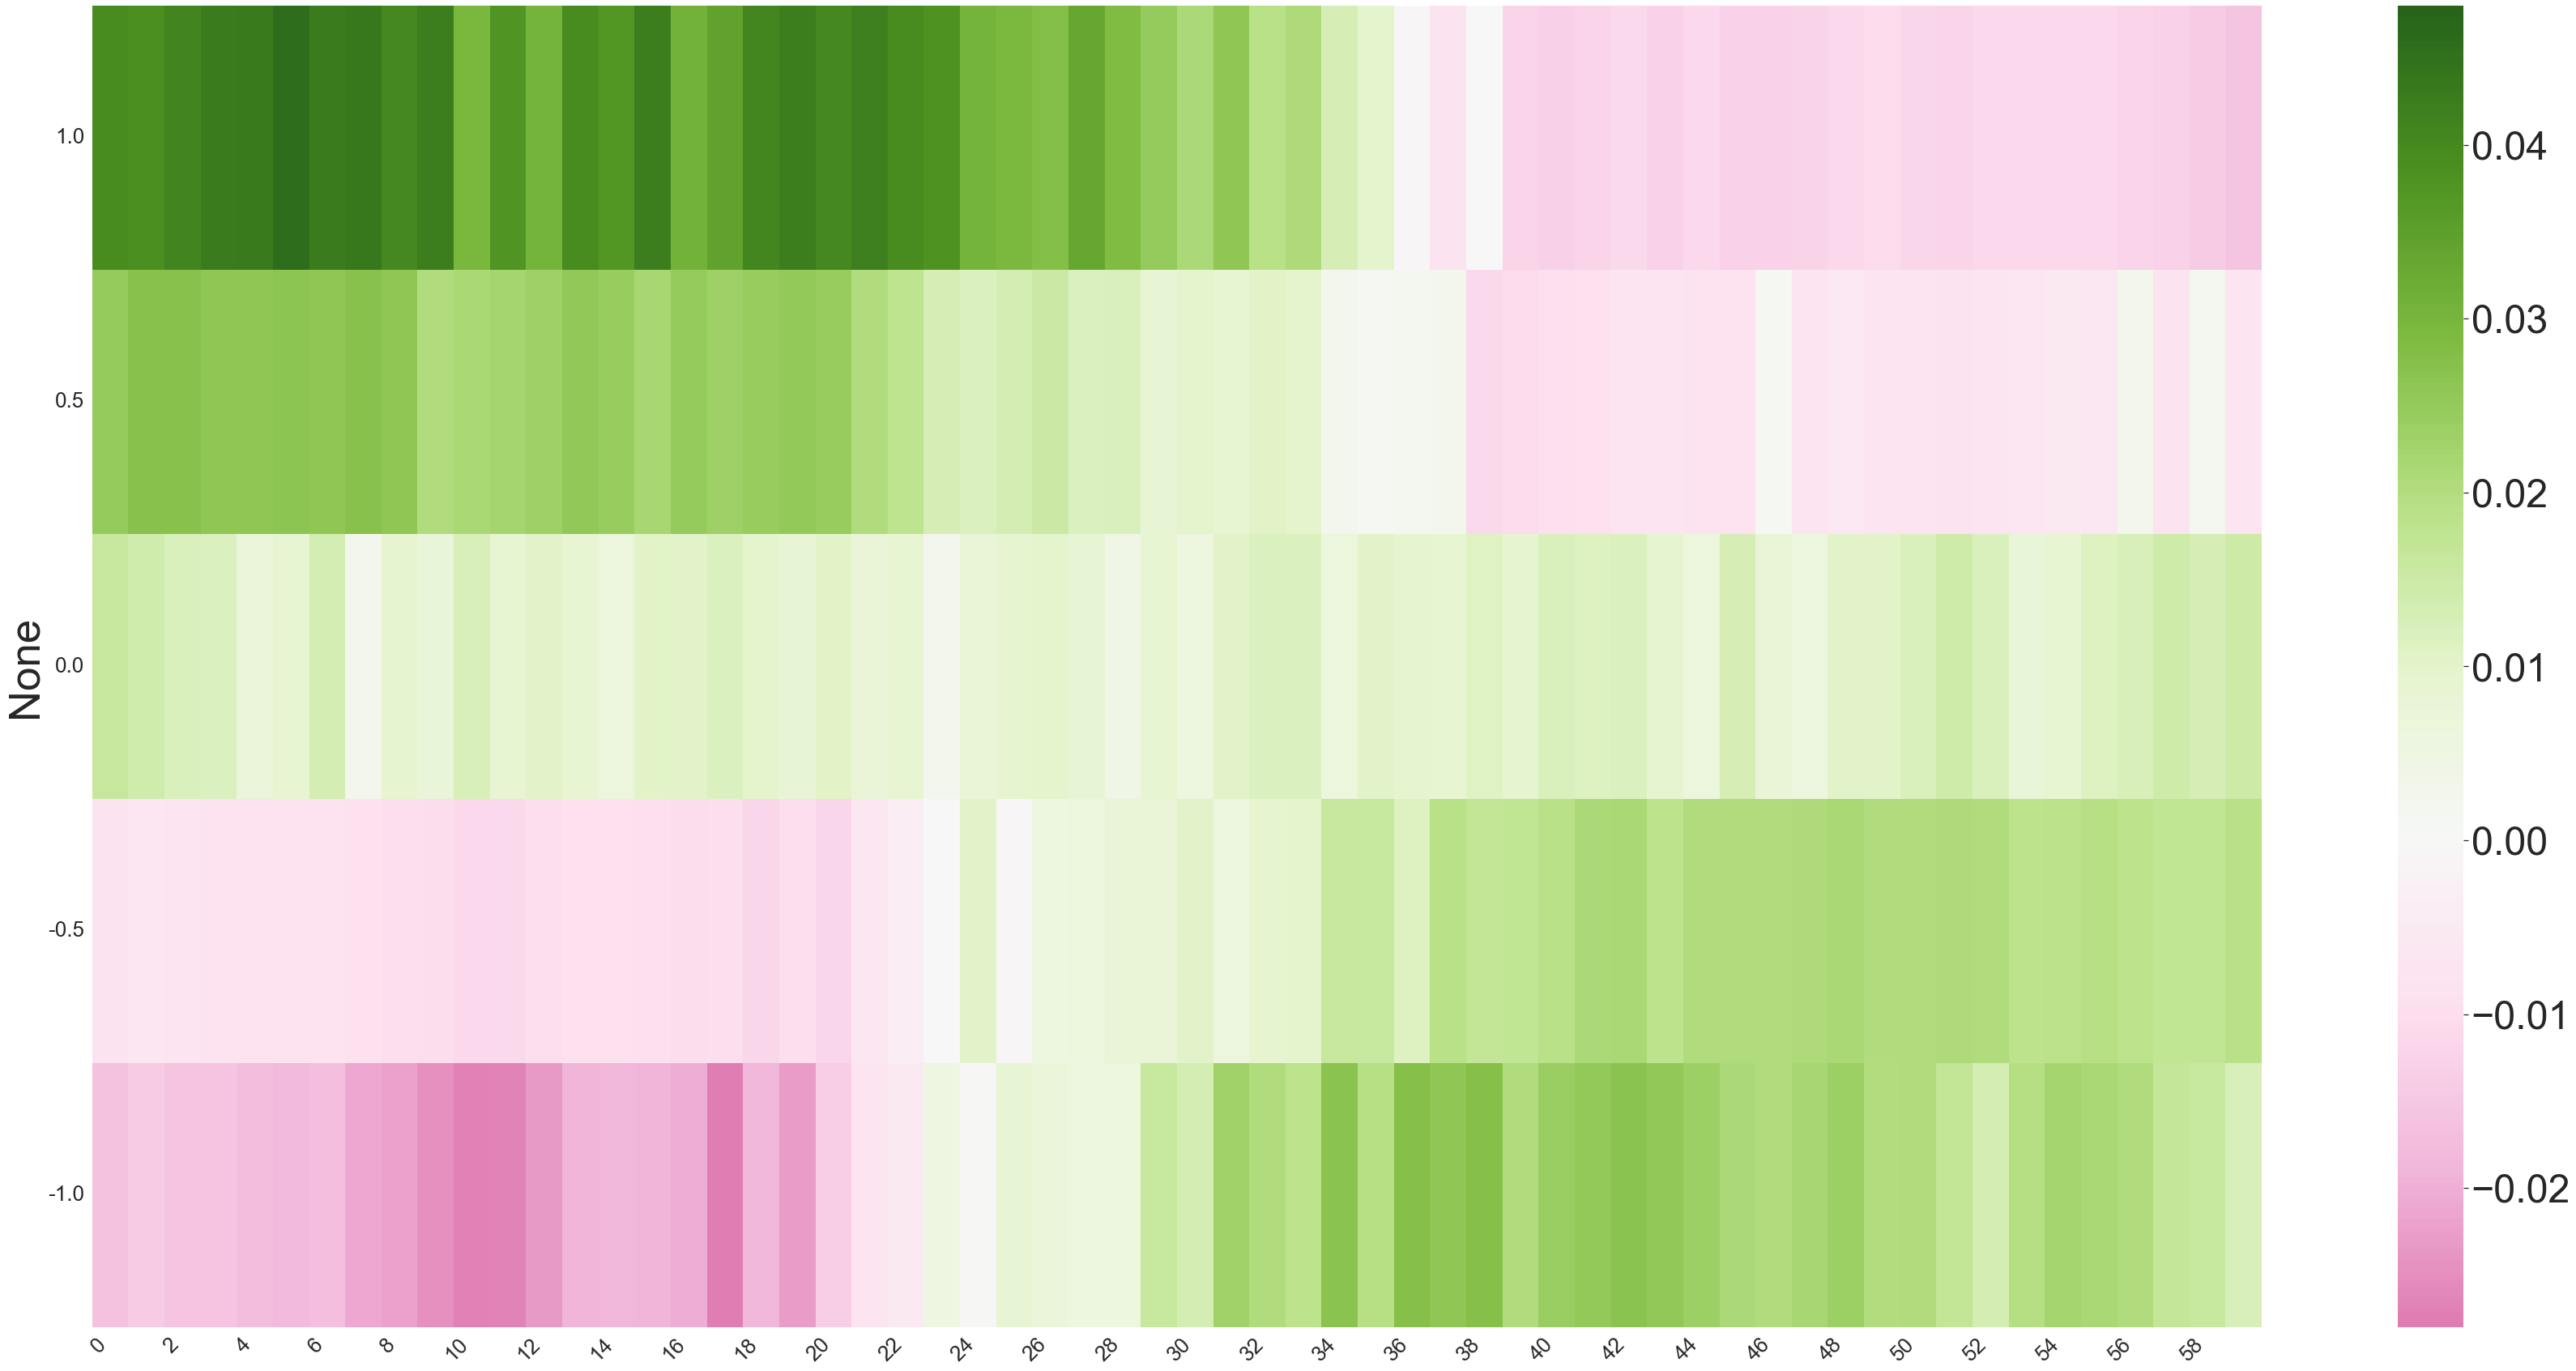

In [34]:
#valuesA = [-1, -0.5, 0, 0.5, 1]
#valuesA = [-1, 1]
sns.set(font_scale=4.4)
reductionWith = reduceString[3] # ['max','max+','average','average+','median','median+']

for lable in rMS.keys():
    print('lable: '+ str(lable))


    data_att = np.flip(np.array(list(rMA[lable][reductionWith].values())), axis=0)
    border = 0#np.max(data_att)/2.1
    data_wordF = [np.flip(np.array(valuesA))]
    data_wordT = range(len(data_att[0])) 
    d = pd.DataFrame(data = data_att,index = data_wordF, columns=data_wordT)
    f, ax = plt.subplots(figsize=(60,30))
    sns.heatmap(d, vmin=-0.028, vmax=0.048, center=border, ax=ax, cmap="PiYG")
    label_y = ax.get_yticklabels()
    plt.setp(label_y, rotation=360, horizontalalignment='right')
    label_x = ax.get_xticklabels()
    plt.setp(label_x, rotation=45, horizontalalignment='right')
    plt.tick_params(labelsize=26)
    plt.savefig('./Bilder/penalty/Class' + str(lable) +'minMatrix.png', dpi = 50)
    plt.show()

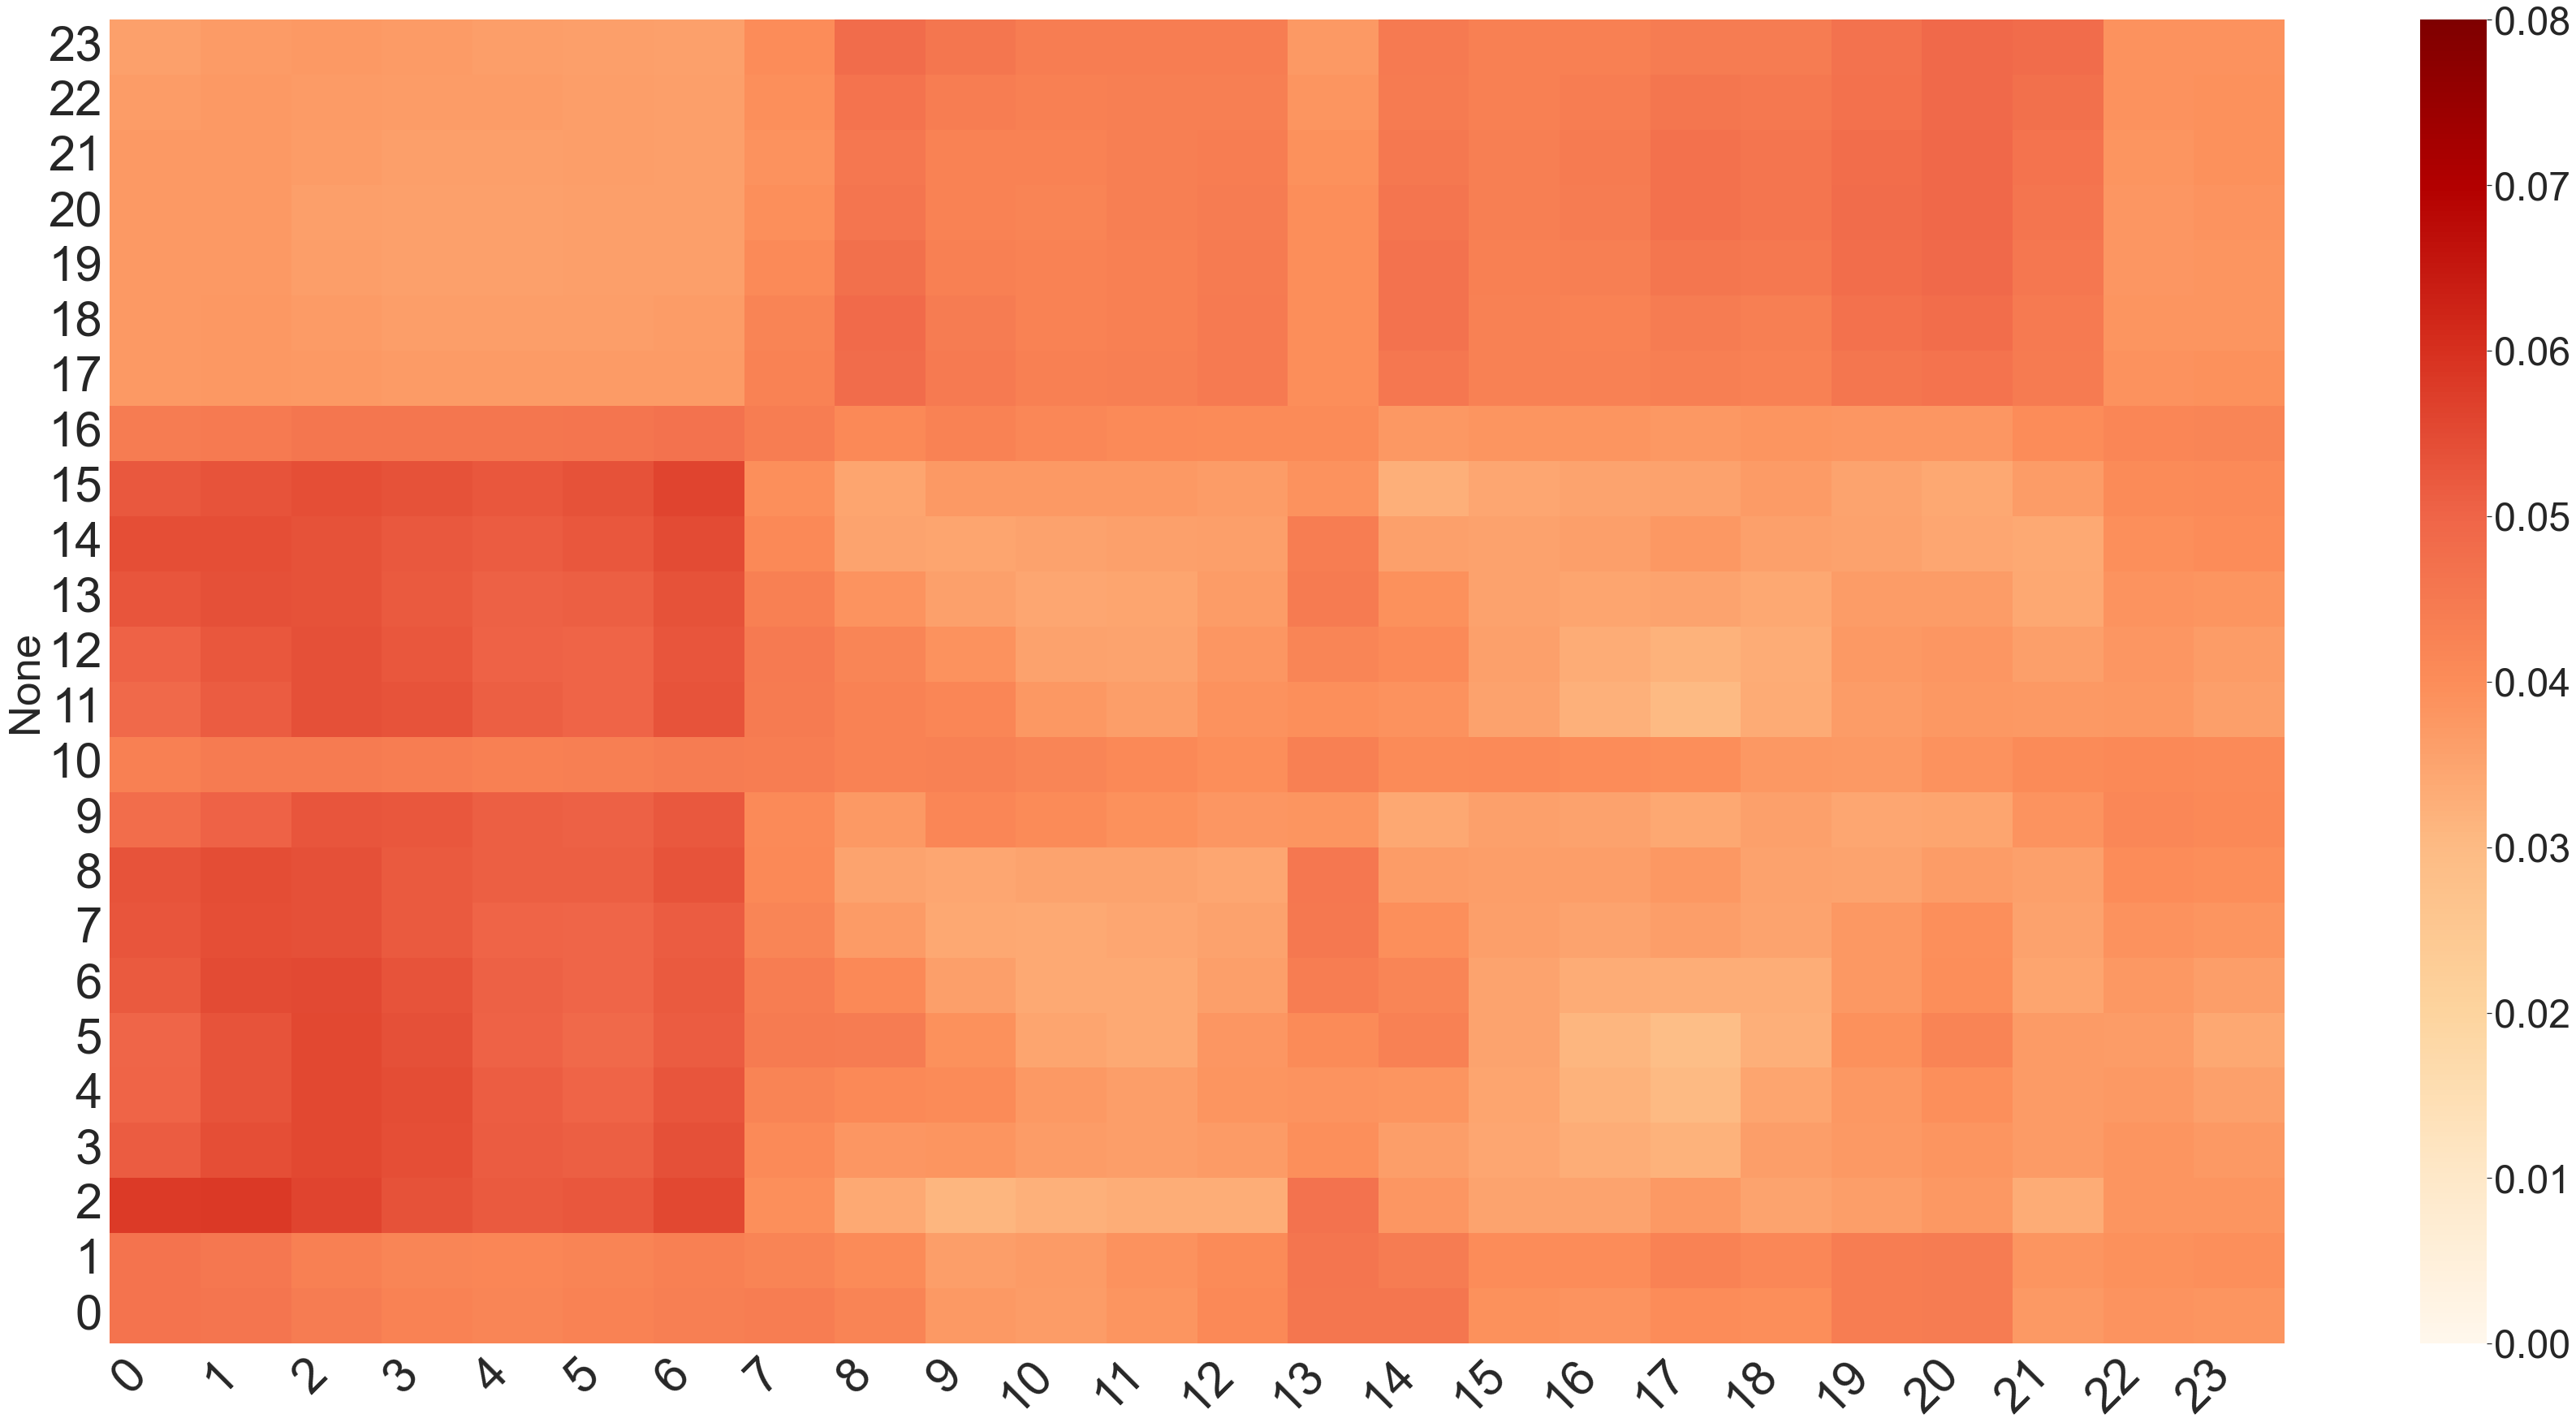

In [43]:
#valuesA = [-1, -0.5, 0, 0.5, 1]



sns.set(font_scale=4.4)
data_att = outSax[9][1][0][0]#np.array([[0.8,0.3],[0.5,0.1]])
data_wordF = [np.flip(np.array(list(range(0,24))))]
data_wordT = np.array(list(range(0,24)))
d = pd.DataFrame(data = data_att,index = data_wordF, columns=data_wordT)
f, ax = plt.subplots(figsize=(60,30))
sns.heatmap(d, vmin=0, vmax=0.08, ax=ax, cmap="OrRd")
label_y = ax.get_yticklabels()
plt.setp(label_y, rotation=360, horizontalalignment='right')
label_x = ax.get_xticklabels()
plt.setp(label_x, rotation=45, horizontalalignment='right')
plt.tick_params(labelsize=60)
plt.savefig('./Bilder/attentionExample.png', dpi = 50)
plt.show()

[ 0  2  4  6  8 10 12 14 16 18 20 22 24 26 28 30]


D:\programme\anaconda\lib\site-packages\ipykernel_launcher.py:29: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.


FileNotFoundError: [Errno 2] No such file or directory: './Bilder/min/all.png'

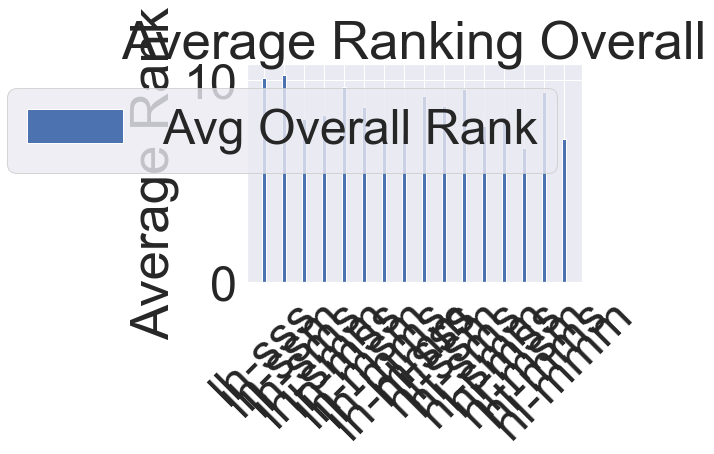

In [67]:
import matplotlib.pyplot as plt
import numpy as np


labels = ["lh-sss","lh-ssm","lh-sms","lh-smm","lh-mss","lh-msm","lh-mms","lh-mmm","hl-sss","hl-ssm","hl-sms","hl-smm","hl-mss","hl-msm","hl-mms","hl-mmm"]
#acc rank: men_means = [5.63,9.5,7.88,12.5,5.875,7.625,9.75,13.5,3.125,9,6,11.38,4,8.5,9.75,12]
#red rank: women_means = [14.5,11,8.25,4,13.38,9.63,5.25,1.13,15.25,8.38,13.13,4,12.25,4.75,9,2.13]
#thesholds:
#men_means = [11,10.63,7,8.88,10.38,7.63,7.88,7.3,9.88,7.63,10.38,7.13,8,5.88,9.63,6.89]
#women_means = [9.13,9.88,9.13,7.63,8.88,9.63,7.13,7.38,8.5,9.75,8.75,8.25,8.25,7.38,9.13,7.25]
men_means = [10.06,10.25,8.06,8.25,9.63,8.63,7.5,7.31,9.19,8.69,9.56,7.69,8.13,6.63,9.38,7.06]
x = np.arange(len(labels)*2, step=2)  # the label locations
print(x)
width = 0.45  # the width of the bars

fig, ax = plt.subplots()
ax = plt.gca()
rects1 = ax.bar(x - width/2, men_means, width, label='Avg Overall Rank',align='edge')
#rects2 = ax.bar(x + width/2, women_means, width, label='Max Threshold Rank',align='edge')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Average Rank')
ax.set_title('Average Ranking Overall')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.xticks(rotation=45)

fig.tight_layout()

plt.savefig('./Bilder/min/all.png', dpi = 100)
plt.show()

In [ ]:
import time

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

from sktime.datasets import load_osuleaf

##########################


#x_train = X_train
#x_train = np.array(outSax[6]).squeeze()
x_train = np.array(outAvgAverage[6]).squeeze()

predictions = np.argmax(y_train1,axis=1) +1  
#predictions = y_trainy

################################

dfArray = []
for x in x_train:
    ps = pd.Series(x)
    dfArray.append(ps)
dftrain = pd.DataFrame()
dftrain['dim_0'] = dfArray


train_x = dftrain
train_y = predictions


# How long (in minutes) to extract shapelets for.
# This is a simple lower-bound initially;
# once time is up, no further shapelets will be assessed
time_contract_in_mins = 2

# The initial number of shapelet candidates to assess per training series.
# If all series are visited and time remains on the contract then another
# pass of the data will occur
initial_num_shapelets_per_case = 10

# Whether or not to print on-going information about shapelet extraction.
# Useful for demo/debugging
verbose = 2

# example pipeline with 1 minute time limit
pipeline = Pipeline(
    [
        (
            "st",
            ContractedShapeletTransform(
                time_contract_in_mins=time_contract_in_mins,
                num_candidates_to_sample_per_case=initial_num_shapelets_per_case,
#                max_shapelets_to_store_per_class=1,
                min_shapelet_length=3,
                verbose=False,
            ),
        ),
        ("rf", RandomForestClassifier(n_estimators=100)),
    ]
)

start = time.time()
pipeline.fit(train_x, train_y)
end_build = time.time()

In [ ]:

#x_test = X_test
#x_test = np.array(outSax[7]).squeeze()
x_test = np.array(outAvgAverage[7]).squeeze()

dfArray = []
for x in x_test:
    ps = pd.Series(x)
    dfArray.append(ps)
dftest = pd.DataFrame()
dftest['dim_0'] = dfArray

test_x = dftest
test_y = y_testy


preds = pipeline.predict(test_x)
end_test = time.time()

print("Results:")
print("Correct:")
correct = sum(preds == test_y)
print("\t" + str(correct) + "/" + str(len(test_y)))
print("\t" + str(correct / len(test_y)))
print("\nTiming:")
print("\tTo build:   " + str(end_build - start) + " secs")
print("\tTo predict: " + str(end_test - end_build) + " secs")

#anzahl shapelets
#avg größe shapelets
#avg complexity
#overall complexity
#nur top n shapelets und von denen sum informationsgrad und co vergleichen?

In [ ]:
def ceFull(data):
    complexDists = []
    for d in data:
        complexDists.append[ce(d)]
        
    return complexDist, np.mean(complexDist) 

def ce(data):
    summer = 0
    for i in range(len(data)-1):
        summer += math.pow(data[i] - data[i+1], 2)
    return math.sqrt(summer)

#TODO was wenn keine top5 gibt?

print('Acc:')
correct = sum(preds == test_y)
print(str(correct) + "/" + str(len(test_y)))
print(str(correct / len(test_y)))

print('len:')
print(len(pipeline['st'].shapelets))
infoGain = [s.info_gain for s in pipeline['st'].shapelets]
infoGain = np.array(infoGain)
print('avg info gain')
print(np.mean(infoGain))
print('avg info gain top 5')
print(np.mean(infoGain[:5]))
lenGain = [s.length for s in pipeline['st'].shapelets]
print('avg len')
lenGain = np.array(lenGain)
print(np.mean(lenGain))
print('avg len top 5')
print(np.mean(lenGain[:5]))

complexGain = []
for s in pipeline['st'].shapelets:
    complexGain.append(ce(train_x.iloc[s.series_id, 0][s.start_pos : s.start_pos + s.length].array))
    
print('avg CE')
print(np.mean(complexGain))
print('avg CE top 5')
print(np.mean(complexGain[:5]))

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

# for each extracted shapelet (in descending order of quality/information gain)
for s in pipeline['st'].shapelets:

    # summary info about the shapelet
    print(s)

    # plot the series that the shapelet was extracted from
    plt.plot(train_x.iloc[s.series_id, 0], "gray")

    # overlay the shapelet onto the full series
    plt.plot(
        list(range(s.start_pos, (s.start_pos + s.length))),
        train_x.iloc[s.series_id, 0][s.start_pos : s.start_pos + s.length],
        "r",
        linewidth=3.0,
    )
    plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pyts.datasets import load_gunpoint
from pyts.transformation import ShapeletTransform

# Shapelet transformation
st = ShapeletTransform(window_sizes=[12, 24, 36, 48],
                       random_state=42, sort=True)
X_new = st.fit_transform(x_train, predictions)

# Visualize the four most discriminative shapelets
plt.figure(figsize=(6, 4))
for i, index in enumerate(st.indices_[:4]):
    idx, start, end = index
    plt.plot(x_train[idx], color='C{}'.format(i),
             label='Sample {}'.format(idx))
    plt.plot(np.arange(start, end), x_train[idx, start:end],
             lw=5, color='C{}'.format(i))

plt.xlabel('Time', fontsize=12)
plt.title('The four most discriminative shapelets', fontsize=14)
plt.legend(loc='best', fontsize=8)
plt.show()

In [2]:
#avg abstract:

Acc:                              
~0.95
höhste: 0.9766666666666667        
len:
15
avg info gain
0.3992682586710572
avg info gain top 5
0.5915860207662806
avg len
29.266666666666666
avg len top 5
23.2
avg CE
1.9796580931615644
avg CE top 5
1.1253042649967109

Acc:
283/300
0.9433333333333334
len:
16
avg info gain
0.38839062593984547
avg info gain top 5
0.5363834769045515
avg len
17.75
avg len top 5
18.4
avg CE
1.1728480344400047
avg CE top 5
1.2388351065796015



#original data
Acc:
	284/300
	0.9466666666666667
len:
10
avg info gain
0.3514996151254673
avg info gain top 5
0.443597332912704
avg len
33.1
avg len top 5
30.6
avg CE
5.1307445387829675
avg CE top 5
3.91083672499755

#ori data klappt auch ganz gut auf sax?
~0.93


#sax:
Acc:
286/300
0.9533333333333334
len:
17
avg info gain
0.3718401555896266
avg info gain top 5
0.5286775042376439
avg len
27.294117647058822
avg len top 5
17.0
avg CE
3.111374947118865
avg CE top 5
1.773965638593308

#sax on ori data:
Acc:
289/300
0.9633333333333334
len:
17
avg info gain
0.36490704882913066
avg info gain top 5
0.5362545034579775
avg len
20.764705882352942
avg len top 5
20.8
avg CE
2.496702935700862
avg CE top 5
1.8857554421596128

#sax auch gut auf avg abstraction data?
0.9833333333333333

SyntaxError: invalid syntax (TEMP/ipykernel_20616/1796230063.py, line 3)

In [ ]:
import numpy as np
a = [[1,2],[3,4]]
np.max(a, axis=1)